# LCA Disclosure Data for Fiscal Year 2023 Analysis

This notebook contains code and notes to analyze data that has been disclosed by the Office of Foreign Labor Certification under the Employment and Training Administration of the U.S. Department of Labor. The datasets used have been downloaded directly from the LCA Programs (H-1B, H-1B1, E-3) under the Performance Data tab of the webpage linked [here](https://www.dol.gov/agencies/eta/foreign-labor/performance).

The aim of this analysis is to extract key insights related to the H-1B program. My hope is to bring this data to the people in the form of informative visualizations. I hope to share key information regarding items such as job titles, employer names, job classifications, industry classifications, and prevailing wages for specific job positions, among many other key features.

A certified Labor Condition Application (LCA) is a requirement that must be obtained prior to the submission of an employer's H-1B visa petition to the USCIS on behalf of an employee (or beneficiary). This application is completed by the filing of Form ETA-9035 to the Department of Labor, and its purpose is for employers to testify that the workers for whom this application is being completed are performing in safe working conditions and are being compensated fairly, among other reasons detailed by the Department of Labor. The Office of Foreign Labor Certification is mandated to release the data obtained from this form for public use. 

As I have provided the context that details at what point during an H-1B visa petition this application is completed, it is important to note that the data used in this analysis should not be confused with the H-1B visa petition data released by the United States Citizenship and Immigration Services (USCIS).

Using this data as the basis of an H-1B analysis is part of an effort to obtain as much data as possible that is relevant to the H-1B program in order to better inform those who are pursuing the program as a path to securing temporary and full-time employment opportunities in the U.S. 

Here, we import the relevant libraries for our analysis.

We will time the code for the first cell.

In [1]:
%load_ext autotime

time: 380 µs (started: 2024-06-11 15:03:01 -04:00)


In [2]:
# Import the following libraries for their specific purposes:
# pandas for manipulating data
# numpy for numerical operations
# matplotlib, seaborn, plotly.express, plotly.graph_objects for plotting and visualization
# datetime for date and time operations
# dash, dash_core_components, dash_html_components for creating web applications
# string for string operations

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from plotly import express as px
from plotly import graph_objects as go
import dash
from dash import dcc
from dash import html
import string

time: 7.53 s (started: 2024-06-11 15:03:01 -04:00)


Then, we read in the data files that will be used in our analysis. Both files have been made available thanks to the Department of Labor's Office of Foreign Labor Certification and the Bureau of Labor Statistics. The two files we will use are detailed as follows:
- The first file contains Labor Condition Application data on the Employment and Training Administration's LCA Program:
    * Each quarter, the OFLC avails files that contain administrative data from the Labor Condition Applications of employers, and the final determinations given by the OFLC in the fiscal year of 2023 (Oct. 1 2022 to Sep. 30, 2023).
    * The 4 files from fiscal year 2023 were downloaded locally and concatenated using RStudio to produce one large file with all of the Labor Condition Applications for the entire fiscal year.
- The second file contains 2018 SOC Definitions data from the Standard Occupational System used by the Bureau of Labor Statistics to classify all public, private, and military occupations in the U.S.:
    * The BLS has made available the 2018 SOC Definitions downloadable on their website.
    * The file was downloaded locally.

The files were retrieved in May 2024.

In [3]:
# Create a new dataframe from the file 'LCA_Disclosure_Data_FY2023_final_copy.xlsx' and copy the file to a new dataframe
initial_data = pd.read_csv('files/combined_lca_data.csv',
                           low_memory=False,
                           dtype={'PW_TRACKING_NUMBER': 'str'},
                           parse_dates=['DECISION_DATE', 'RECEIVED_DATE', 'ORIGINAL_CERT_DATE', 'BEGIN_DATE', 'END_DATE'])
df = initial_data.copy()

# Create a new dataframe from the file 'soc_2018_definitions_detailed_occupations.xlsx'
soc_definitions = pd.read_excel('/Users/tinashem/Github Repos/CareerPalz/files/soc_2018_definitions_detailed_occupations.xlsx')

time: 31.7 s (started: 2024-06-11 15:03:09 -04:00)


Our analysis will start with the cleaning of the first dataset with the Labor Condition Application data. The second dataset will come into use to help in cleaning the first dataset.

## Data Cleaning

Before previewing the dataset, let's use the `pd.set_option` method to view all of the column entries in a single row in this dataset.

In [4]:
# Use pd.set_option to display all columns in the dataset and preview the first 10 rows of the dataset
pd.set_option('display.max_columns', None)
df.head(10)

CASE_NUMBER            CASE_STATUS RECEIVED_DATE DECISION_DATE  \
0  I-200-23244-317261  Certified - Withdrawn    2023-09-01    2023-09-30   
1  I-202-23242-306442  Certified - Withdrawn    2023-08-30    2023-09-30   
2  I-200-23242-308144  Certified - Withdrawn    2023-08-30    2023-09-30   
3  I-200-23172-131625  Certified - Withdrawn    2023-06-21    2023-09-30   
4  I-200-23170-125146  Certified - Withdrawn    2023-06-19    2023-09-30   
5  I-200-23170-123899  Certified - Withdrawn    2023-06-19    2023-09-30   
6  I-200-23046-776502  Certified - Withdrawn    2023-02-15    2023-09-30   
7  I-203-22333-610021  Certified - Withdrawn    2022-11-29    2023-09-30   
8  I-200-22216-395597  Certified - Withdrawn    2022-08-03    2023-09-30   
9  I-203-23274-403704              Withdrawn    2023-09-30    2023-09-30   

  ORIGINAL_CERT_DATE       VISA_CLASS                          JOB_TITLE  \
0         2023-09-11             H-1B               Analyst, Business Sr   
1         2023-09-07  H-1B1 Singapore   Board Certified Behavior Analyst   
2         2023-09-07             H-1B     Manager - Software Engineering   
3         2023-06-28             H-1B                 SOFTWARE DEVELOPER   
4         2023-06-26             H-1B                 SOFTWARE DEVELOPER   
5         2023-06-26             H-1B                 SOFTWARE DEVELOPER   
6         2023-02-22             H-1B  Senior Manager, Americas Division   
7         2022-12-06   E-3 Australian        Vice President, Engineering   
8         2022-08-10             H-1B                   BUSINESS ANALYST   
9                NaT   E-3 Australian                     CEO of BioBrew   

     SOC_CODE                                  SOC_TITLE FULL_TIME_POSITION  \
0  15-2031.00               Operations Research Analysts                  Y   
1  19-3034.00                       School Psychologists                  Y   
2  15-1252.00                        Software Developers                  Y   
3  15-1252.00                        Software Developers                  Y   
4  15-1252.00                        Software Developers                  Y   
5  15-1252.00                        Software Developers                  Y   
6  13-1111.00                        Management Analysts                  Y   
7  11-3021.00  Computer and Information Systems Managers                  Y   
8  15-1211.00                  Computer Systems Analysts                  Y   
9  11-1021.00            General and Operations Managers                  Y   

  BEGIN_DATE   END_DATE  TOTAL_WORKER_POSITIONS  NEW_EMPLOYMENT  \
0 2024-03-01 2027-02-28                       1               0   
1 2023-10-17 2026-10-16                       1               0   
2 2024-01-01 2026-12-31                       1               0   
3 2023-10-01 2026-09-30                       1               1   
4 2023-10-01 2026-09-30                       1               1   
5 2023-10-01 2026-09-30                       1               1   
6 2023-02-15 2024-06-11                       1               0   
7 2023-01-01 2024-12-31                       1               0   
8 2022-08-08 2025-08-07                       1               0   
9 2023-12-16 2025-12-15                       1               0   

   CONTINUED_EMPLOYMENT  CHANGE_PREVIOUS_EMPLOYMENT  \
0                     1                           0   
1                     1                           0   
2                     1                           0   
3                     0                           0   
4                     0                           0   
5                     0                           0   
6                     0                           0   
7                     0                           0   
8                     0                           0   
9                     1                           0   

   NEW_CONCURRENT_EMPLOYMENT  CHANGE_EMPLOYER  AMENDED_PETITION  \
0                          0                0          

time: 173 ms (started: 2024-06-11 15:03:41 -04:00)


Inspecting the dataset further will help reveal how many entries (or rows) that it has, how many columns are contained within the dataset, the data types of the columns, and how many records have entries that are *not null* for that specific column (in other words, how many records have values that have been entered).

In [5]:
# Preview the information from all of the columns in the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 644607 entries, 0 to 644606
Data columns (total 96 columns):
 #   Column                          Non-Null Count   Dtype         
---  ------                          --------------   -----         
 0   CASE_NUMBER                     644607 non-null  object        
 1   CASE_STATUS                     644607 non-null  object        
 2   RECEIVED_DATE                   644607 non-null  datetime64[ns]
 3   DECISION_DATE                   644607 non-null  datetime64[ns]
 4   ORIGINAL_CERT_DATE              41957 non-null   datetime64[ns]
 5   VISA_CLASS                      644607 non-null  object        
 6   JOB_TITLE                       644607 non-null  object        
 7   SOC_CODE                        644607 non-null  object        
 8   SOC_TITLE                       644607 non-null  object        
 9   FULL_TIME_POSITION              644607 non-null  object        
 10  BEGIN_DATE                      644607 non-null  datetim

Previewing the dataset allows us to see that the CASE_NUMBER will be the unique identifier for each entry made in the dataset. Let's check if we have any duplicates in our dataset.

In [6]:
# Show the number of duplicate values that appear in the entire dataset
df.duplicated().sum()

98001

time: 8.51 s (started: 2024-06-11 15:03:44 -04:00)


It appears that the dataset has 98,001 duplicate values that will need to be removed. 

Before we carry on to remove the duplicate values, let's make sure that each entry in the unique field follows the desired format. According to the H1B Grader website [here](https://h1bgrader.com/lca-search#:~:text=The%20H1B%20LCA%20Case%20Number,%2D200%2D10216%2D614928.), the case number follows the I-XXX-XXXXX-XXXXXX format where each X is a number from 0-9.

Let's verify that each entry follows this format.

In [7]:
# Use a regular expression to ensure that each of the CASE_NUMBER entries follows the pattern 'I-200-12345-123456'
df['CASE_NUMBER'].str.match(r'I-\d{3}-\d{5}-\d{6}').all()

True

time: 711 ms (started: 2024-06-11 15:03:53 -04:00)


All of the entries match! Let's go ahead and remove the duplicate values.

In [8]:
# Remove the duplicate values from the CASE_NUMBER column
df = df.drop_duplicates()

time: 9.43 s (started: 2024-06-11 15:03:54 -04:00)


Let's look at the dataset again to see how the cleaning operation has altered the dataset.

In [9]:
# Show the number of duplicate values that appear in the entire dataset
df.duplicated().sum()

0

time: 7.41 s (started: 2024-06-11 15:04:03 -04:00)


In [10]:
# Preview the information from all of the columns in the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 546606 entries, 0 to 633773
Data columns (total 96 columns):
 #   Column                          Non-Null Count   Dtype         
---  ------                          --------------   -----         
 0   CASE_NUMBER                     546606 non-null  object        
 1   CASE_STATUS                     546606 non-null  object        
 2   RECEIVED_DATE                   546606 non-null  datetime64[ns]
 3   DECISION_DATE                   546606 non-null  datetime64[ns]
 4   ORIGINAL_CERT_DATE              33482 non-null   datetime64[ns]
 5   VISA_CLASS                      546606 non-null  object        
 6   JOB_TITLE                       546606 non-null  object        
 7   SOC_CODE                        546606 non-null  object        
 8   SOC_TITLE                       546606 non-null  object        
 9   FULL_TIME_POSITION              546606 non-null  object        
 10  BEGIN_DATE                      546606 non-null  datetime64[n

Previewing the dataset revealed that there is a lot of text data contained in our dataset. Let's do a couple of operations to clean our text data.

In [11]:
%%time

# Go into each column that is of dtype object and strip each value in the column of any leading or trailing whitespace
# Check for the test case where the value is a string and strip the leading and trailing whitespace, otherwise leave the value as is
# Use the %%time magic command to time the execution of the for loop

for col in df.select_dtypes(include='object').columns:
    df[col] = [x.strip() if type(x) == 'str' else x for x in df[col]]

CPU times: user 6.92 s, sys: 694 ms, total: 7.61 s
Wall time: 7.98 s
time: 7.98 s (started: 2024-06-11 15:04:12 -04:00)


Looking at all of the columns in the dataset, the key columns for our analysis include:

- CASE_STATUS
- VISA_CLASS
- JOB_TITLE
- SOC_CODE 
- SOC_TITLE
- FULL_TIME_POSITION
- NEW_EMPLOYMENT
- EMPLOYER_NAME
- EMPLOYER_CITY 
- EMPLOYER_STATE
- EMPLOYER_PHONE
- NAICS_CODE
- WAGE_RATE_OF_PAY_FROM
- WAGE_RATE_OF_PAY_TO
- WAGE_UNIT_OF_PAY
- PREVAILING_WAGE
- PW_UNIT_OF_PAY
- TOTAL_WORKER_POSITIONS,

and others that might be added to the analysis in the future.

The SOC title and code both come from the Standard Occupational Code (SOC) system created by the Department of Labor's Bureau of Labor Statistics, in order to collect, calculate, and share data about occupations in the U.S. labor market across multiple agencies and organizations. 

According to the page 1 of the 2018 SOC Manual, "the SOC covers all jobs in the national economy, including occupations in the public, private, and military sectors." And it has done so by creating a system such that each job title falls under a group called its _detailed occupation_. That job title's detailed occupation is one of *867* detailed occupations as defined by the SOC system. 

Each job title therefore is associated with an SOC title and a corresponding SOC code to help classify it. For example, looking at the Software Engineer job title, that would be classified under the SOC title "Software Developers" with the SOC code 15-1252. 

The classification system uses different levels beyond just the detailed occupation classification, and more information about the system including its definitions, codes, its uses, and its history can be found [here](https://www.bls.gov/soc/).

Let's use this information to explore the SOC Definitions dataset that has thankfully been made available by the Bureau of Labor Statistics [here](https://www.bls.gov/soc/2018/).

We'll start by checking the dataset for duplicate and null values.

In [12]:
# Preview the files in the soc_definitions dataframe
soc_definitions.head(10)

SOC_GROUP SOC_CODE                                          SOC_TITLE  \
0     Major  11-0000                             Management Occupations   
1     Minor  11-1000                                     Top Executives   
2     Broad  11-1010                                   Chief Executives   
3  Detailed  11-1011                                   Chief Executives   
4     Broad  11-1020                    General and Operations Managers   
5  Detailed  11-1021                    General and Operations Managers   
6     Broad  11-1030                                        Legislators   
7  Detailed  11-1031                                        Legislators   
8     Minor  11-2000  Advertising, Marketing, Promotions, Public Rel...   
9     Broad  11-2010                Advertising and Promotions Managers   

                                      SOC_DEFINITION  
0                                                NaN  
1                                                NaN  
2                                                NaN  
3  Determine and formulate policies and provide o...  
4                                                NaN  
5  Plan, direct, or coordinate the operations of ...  
6                                                NaN  
7  Develop, introduce, or enact laws and statutes...  
8                                                NaN  
9                                                NaN

time: 9.74 ms (started: 2024-06-11 15:04:20 -04:00)


In [13]:
# Find the number of duplicate values in the soc_definitions dataframe
soc_definitions.duplicated().sum()

0

time: 9.66 ms (started: 2024-06-11 15:04:20 -04:00)


We have no duplicates in our dataset, but it contains some null values. A key observation here is that the entries in the SOC_DEFINITION column correspond to the 'Detailed' entries in the SOC_GROUP column.

Let's preview the dataset to investigate the presence of NaN values.

In [14]:
# Preview the information from all of the columns in the soc_definitions dataframe
soc_definitions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1447 entries, 0 to 1446
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   SOC_GROUP       1447 non-null   object
 1   SOC_CODE        1447 non-null   object
 2   SOC_TITLE       1447 non-null   object
 3   SOC_DEFINITION  867 non-null    object
dtypes: object(4)
memory usage: 45.3+ KB
time: 5.44 ms (started: 2024-06-11 15:04:20 -04:00)


Out of the 4 columns, only the SOC_DEFINITIONS column has null entries. But before investigating the presence of null values, let's clean this new dataset by checking for whitespace characters in the string.

In [15]:
# Go into each column  of the soc_definitions dataframe and clean the whitespace
for col in soc_definitions.select_dtypes(include='object').columns:
    soc_definitions[col] = [x.strip() if type(x) == 'str' else x for x in soc_definitions[col]]

time: 5.48 ms (started: 2024-06-11 15:04:20 -04:00)


To address the null values, we need to look at the preview and numbers displayed above. 

The number of non-null entries in the SOC_DEFINITION column is 867, which is the same number of occupations listed in the SOC system. And going back to our key observation, it is likely that each entry in the SOC_GROUP column that is not 'Detailed' does not have a corresponding entry in the SOC_DEFINITION column. 

Let's look at the different values in the SOC_GROUP column.

In [16]:
# Find the values in the SOC_GROUP column
soc_definitions['SOC_GROUP'].unique()

array(['Major', 'Minor', 'Broad', 'Detailed'], dtype=object)

time: 4.14 ms (started: 2024-06-11 15:04:20 -04:00)


As mentioned before, the SOC classifications go beyond the detailed occupations. Namely, the SOC_GROUP column of this new file has the Major, Minor, Broad, and Detailed groups. Let's narrow it down to only the detailed occupations.

In [17]:
# Create a new dataframe that has only the detailed occupations
soc_definitions_detailed = soc_definitions[soc_definitions['SOC_GROUP'] == 'Detailed']
soc_definitions_detailed.head()

SOC_GROUP SOC_CODE                            SOC_TITLE  \
3   Detailed  11-1011                     Chief Executives   
5   Detailed  11-1021      General and Operations Managers   
7   Detailed  11-1031                          Legislators   
10  Detailed  11-2011  Advertising and Promotions Managers   
12  Detailed  11-2021                   Marketing Managers   

                                       SOC_DEFINITION  
3   Determine and formulate policies and provide o...  
5   Plan, direct, or coordinate the operations of ...  
7   Develop, introduce, or enact laws and statutes...  
10  Plan, direct, or coordinate advertising polici...  
12  Plan, direct, or coordinate marketing policies...

time: 6.37 ms (started: 2024-06-11 15:04:20 -04:00)


Let's check how many entries are in the dataset.

In [18]:
# Show the information from all of the columns in the soc_definitions_detailed dataframe
soc_definitions_detailed.info()

<class 'pandas.core.frame.DataFrame'>
Index: 867 entries, 3 to 1446
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   SOC_GROUP       867 non-null    object
 1   SOC_CODE        867 non-null    object
 2   SOC_TITLE       867 non-null    object
 3   SOC_DEFINITION  867 non-null    object
dtypes: object(4)
memory usage: 33.9+ KB
time: 5.03 ms (started: 2024-06-11 15:04:20 -04:00)


Now, we see that the number of entries in each column of this new dataset match the number of detailed occupations defined by the SOC system.

Using this new dataset, let's check for data types.

In [19]:
# Show the data type of the first entry in each column of the soc_definitions_detailed dataframe
for col in soc_definitions_detailed.columns:
    print(f"{col}: {soc_definitions_detailed[col].values[0]}: {type(soc_definitions_detailed[col].values[0])}")

SOC_GROUP: Detailed: <class 'str'>
SOC_CODE: 11-1011: <class 'str'>
SOC_TITLE: Chief Executives: <class 'str'>
SOC_DEFINITION: Determine and formulate policies and provide overall direction of companies or private and public sector organizations within guidelines set up by a board of directors or similar governing body. Plan, direct, or coordinate operational activities at the highest level of management with the help of subordinate executives and staff managers.: <class 'str'>
time: 511 µs (started: 2024-06-11 15:04:20 -04:00)


Our dataset is clean! Now, we can compare the entries in this dataset to those in the SOC_TITLE column of the LCA dataset.

Since we established that the SOC_TITLE and SOC_CODE columns contain strings, let's start by counting the number of entries in each column of each of the two data frames.

In [20]:
# Print out the number of unique SOC titles in the df data frame
print(f"There are {df['SOC_TITLE'].nunique():,} unique SOC titles in the df data frame.")

# Print out the number of unique SOC titles in the soc_definitions_detailed data frame
print(f"There are {soc_definitions_detailed['SOC_TITLE'].nunique():,} unique SOC titles in the soc_definitions_detailed data frame.")

There are 1,002 unique SOC titles in the df data frame.
There are 867 unique SOC titles in the soc_definitions_detailed data frame.
time: 58.1 ms (started: 2024-06-11 15:04:20 -04:00)


The dataframe has more unique SOC titles than the SOC definitions dataframe, so let's cross-validate the two data frames by checking how many common entries exist across the SOC_TITLE column of the two dataframes.


In [21]:
# Create variables for the number of unique SOC titles in each dataframe
soc_definitions_detailed_soc_titles = soc_definitions_detailed['SOC_TITLE'].unique()
data_soc_titles = df['SOC_TITLE'].unique()

# Find the SOC titles that are in the BIG data frame but not in the soc_definitions_detailed data frame
missing_from_data = [title for title in data_soc_titles if title not in soc_definitions_detailed_soc_titles]
print(f"There are {len(missing_from_data):,} SOC titles in the BIG data frame that are not in the soc_definitions_detailed data frame.")

# Find the SOC titles that are in the soc_definitions_detailed data frame but not in the BIG data frame
missing_from_soc_definitions = [title for title in soc_definitions_detailed_soc_titles if title not in data_soc_titles]
print(f"There are {len(missing_from_soc_definitions):,} SOC titles in the soc_definitions_detailed data frame that are not in the BIG data frame.")

# Find the SOC titles that are in both the df data frame and the soc_definitions_detailed data frame
common_soc_titles = [title for title in data_soc_titles if title in soc_definitions_detailed_soc_titles]
print(f"There are {len(common_soc_titles):,} SOC titles that are in both the certified_h1b data frame and the soc_definitions_detailed data frame.")

There are 508 SOC titles in the BIG data frame that are not in the soc_definitions_detailed data frame.
There are 373 SOC titles in the soc_definitions_detailed data frame that are not in the BIG data frame.
There are 494 SOC titles that are in both the certified_h1b data frame and the soc_definitions_detailed data frame.
time: 129 ms (started: 2024-06-11 15:04:21 -04:00)


It appears that there are 494 common entries for detailed occupations in the two datasets, which is just under a half of the total of 867 detailed occupations. Let's investigate the entries that are not in the SOC definitions dataframe.

In [22]:
print(f"The first 10 SOC titles that are in the data df that are not in the soc_definitions_detailed df are:")
for i in range(10):
    print(f"{i+1}. {missing_from_data[i]}")

The first 10 SOC titles that are in the data df that are not in the soc_definitions_detailed df are:
1. Computer Systems Engineers/Architects
2. Manufacturing Engineers
3. Bioinformatics Scientists
4. Electrical Engineer
5. Hospitalists
6. Molecular & Cellular Biologists
7. Regulatory Affairs Specialists
8. Mechanical Engineers, R&D
9. Software Developers, Applications
10. Financial Analysts
time: 2.49 ms (started: 2024-06-11 15:04:21 -04:00)


Let's look at the job titles for one of these 10 SOC titles.

In [23]:
# Find the job titles from the LCAs whose SOC_TITLE entry is Computer Systems Engineers/Architects
computer_systems_engineers = df[df['SOC_TITLE'] == 'Computer Systems Engineers/Architects']
print(f"There are {computer_systems_engineers['JOB_TITLE'].nunique():,} unique job titles for Computer Systems Engineers/Architects.")

There are 5,299 unique job titles for Computer Systems Engineers/Architects.
time: 315 ms (started: 2024-06-11 15:04:21 -04:00)


In [24]:
computer_systems_engineers['JOB_TITLE'].value_counts().head(10)

JOB_TITLE
Architect                                                       2225
Manager JC50 - Computer Systems Engineers/Architects            1862
Senior Associate JC60 -Computer Systems Engineers/Architects    1559
ARCHITECT                                                        919
Software Engineer                                                522
Technology Architect - US                                        373
Systems Engineer                                                 367
Senior Manager JC45 - Computer Systems Engineers/Architects      360
System Architect - III                                           346
Technology Analyst - US                                          295
Name: count, dtype: int64

time: 10.2 ms (started: 2024-06-11 15:04:21 -04:00)


Looking at the job titles and cross-checking with those listed in the SOC definitions, it appears that there may have been incorrect entries made by employers in the SOC title of their Labor Condition Applications.

In [25]:
df[df['SOC_TITLE'].isin(missing_from_data)].head()

CASE_NUMBER            CASE_STATUS RECEIVED_DATE DECISION_DATE  \
14  I-200-23267-376246  Certified - Withdrawn    2023-09-23    2023-09-29   
31  I-200-23244-316204  Certified - Withdrawn    2023-09-01    2023-09-29   
32  I-200-23243-310587  Certified - Withdrawn    2023-08-31    2023-09-29   
42  I-200-23174-141467  Certified - Withdrawn    2023-06-23    2023-09-29   
52  I-200-23089-890148  Certified - Withdrawn    2023-03-30    2023-09-29   

   ORIGINAL_CERT_DATE VISA_CLASS                            JOB_TITLE  \
14         2023-09-29       H-1B           SAP - Technical Consultant   
31         2023-09-11       H-1B          Senior Transceiver Engineer   
32         2023-09-08       H-1B  Computer Systems Engineer/Architect   
42         2023-06-30       H-1B          Assistant Project Scientist   
52         2023-04-06       H-1B                          RF Engineer   

      SOC_CODE                              SOC_TITLE FULL_TIME_POSITION  \
14  15-1299.08  Computer Systems Engineers/Architects                  Y   
31  17-2112.03                Manufacturing Engineers                  Y   
32  15-1299.08  Computer Systems Engineers/Architects                  Y   
42  19-1029.01              Bioinformatics Scientists                  Y   
52     17-2071                    Electrical Engineer                  Y   

   BEGIN_DATE   END_DATE  TOTAL_WORKER_POSITIONS  NEW_EMPLOYMENT  \
14 2023-09-30 2026-09-29                       1               0   
31 2023-10-01 2026-09-30                       1               1   
32 2023-10-01 2026-09-30                       1               1   
42 2023-08-06 2026-08-05                       1               1   
52 2023-09-11 2026-09-10                       1               0   

    CONTINUED_EMPLOYMENT  CHANGE_PREVIOUS_EMPLOYMENT  \
14                     0                           0   
31                     0                           0   
32                     0                           0   
42                     0                           0   
52                     1                           0   

    NEW_CONCURRENT_EMPLOYMENT  CHANGE_EMPLOYER  AMENDED_PETITION  \
14                          0                1                 0   
31                          0                0                 0   
32                          0                0                 0   
42                          0                0                 0   
52                          0                0                 0   

                          EMPLOYER_NAME TRADE_NAME_DBA  \
14                      ATOS SYNTEL INC            NaN   
31                        COHERENT CORP            NaN   
32                  LTIMindtree Limited            NaN   
42  UNIVERSITY OF CALIFORNIA, SAN DIEGO            NaN   
52    Global Technology Associates, LLC            NaN   

                  EMPLOYER_ADDRESS1     EMPLOYER_ADDRESS2 EMPLOYER_CITY  \
14         525 EAST BIG BEAVER ROAD             SUITE 300          TROY   
31          375 Saxonburg Boulevard                   NaN     Saxonburg   
32            25 Independence Blvd,             Suite 401        Warren   
42  INT'L FACULTY & SCHOLARS OFFICE  9500 GILMAN DR #0123      LA JOLLA   
52           1890 Preston White Dr.              Ste. 150        Reston   

   EMPLOYER_STATE EMPLOYER_POSTAL_CODE          EMPLOYER_COUNTRY  \
14             MI                48083  UNITED STATES OF AMERICA   
31             PA                16056  UNITED STATES OF AMERICA   
32             NJ                07059  UNITED STATES OF AMERICA   
42             CA                92093  UNITED STATES OF AMERICA   
52             VA                20191  UNITED STATES OF AMERICA   

   EMPLOYER_PROVINCE  EMPLOYER_PHONE  EMPLOYER_PHONE_EXT  NAICS_CODE  \
14               NaN     12488423133                 NaN      541511   
31               NaN     14085481000                 NaN      333310   
32               NaN     17322486147                 NaN      541511   


time: 306 ms (started: 2024-06-11 15:04:21 -04:00)


In [26]:
df[df['SOC_TITLE'].isin(missing_from_data)].info()

<class 'pandas.core.frame.DataFrame'>
Index: 88270 entries, 14 to 633743
Data columns (total 96 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   CASE_NUMBER                     88270 non-null  object        
 1   CASE_STATUS                     88270 non-null  object        
 2   RECEIVED_DATE                   88270 non-null  datetime64[ns]
 3   DECISION_DATE                   88270 non-null  datetime64[ns]
 4   ORIGINAL_CERT_DATE              12704 non-null  datetime64[ns]
 5   VISA_CLASS                      88270 non-null  object        
 6   JOB_TITLE                       88270 non-null  object        
 7   SOC_CODE                        88270 non-null  object        
 8   SOC_TITLE                       88270 non-null  object        
 9   FULL_TIME_POSITION              88270 non-null  object        
 10  BEGIN_DATE                      88270 non-null  datetime64[ns]
 11  END_D

After looking through some of the entries in the two dataframes being investigated, it appears that entries that are missing were likely due to incorrect entry on the part of the employer. For example, "Software Developers" is incorrectly entered as "Software Developers, Applications". 

For another example, "Business Intelligence Analysts" and "Bioinformatics Scientists", which were both found in the LCA data, are not a detailed occupation according to the SOC Definitions. It would likely be of use to employers if they could enter the correct information in their LCA forms to ensure accuracy when dealing with data.

Looking through some of the job titles that were entered under the detailed occupations that do not appear in the SOC definitions, entries such as "System Architect" and "Associate Consultant" appear to be ambiguous. And any task to try and redefine these job titles according to the definitions listed in the SOC manual, without any additional information from the employer would prove to be a tedious task. 

For the purposes of this analysis, I have therefore decided to remove these entries from the LCA dataframe for more conclusive results with correctly entered information.

In [27]:
# Create a copy of the dataframe and keep only the rows that have correctly entered SOC titles
data = df.copy()
data = data[data['SOC_TITLE'].isin(common_soc_titles)]
print(f"There are {data['SOC_TITLE'].nunique():,} unique SOC titles in the renewed data frame.")

There are 494 unique SOC titles in the renewed data frame.
time: 3.41 s (started: 2024-06-11 15:04:22 -04:00)


In [28]:
# Preview the information from all of the columns in the newly copied dataframe
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 458336 entries, 0 to 633773
Data columns (total 96 columns):
 #   Column                          Non-Null Count   Dtype         
---  ------                          --------------   -----         
 0   CASE_NUMBER                     458336 non-null  object        
 1   CASE_STATUS                     458336 non-null  object        
 2   RECEIVED_DATE                   458336 non-null  datetime64[ns]
 3   DECISION_DATE                   458336 non-null  datetime64[ns]
 4   ORIGINAL_CERT_DATE              20778 non-null   datetime64[ns]
 5   VISA_CLASS                      458336 non-null  object        
 6   JOB_TITLE                       458336 non-null  object        
 7   SOC_CODE                        458336 non-null  object        
 8   SOC_TITLE                       458336 non-null  object        
 9   FULL_TIME_POSITION              458336 non-null  object        
 10  BEGIN_DATE                      458336 non-null  datetime64[n

In [167]:
# let's see how many rows were dropped
print(f"{df.shape[0] - data.shape[0]:,} rows were dropped from the data frame.")

88,270 rows were dropped from the data frame.
time: 464 µs (started: 2024-06-11 15:05:47 -04:00)


We lost 88,270 out of the existing 546,888 LCA entries. Let's see how many workers we lost due to poor data entry.

In [30]:
# Find the difference between the sum of the values in the 'NEW_EMPLOYMENT' column of the old data frame
# and the same sum in the same column of the renewed data frame
workers_lost = df['NEW_EMPLOYMENT'].sum() - data['NEW_EMPLOYMENT'].sum()
print(f"Data on {workers_lost:,} workers was lost in the process of cleaning the data.")

Data on 52,479 workers was lost in the process of cleaning the data.
time: 63.5 ms (started: 2024-06-11 15:04:27 -04:00)


In the process of cleaning the data, information on 52,479 workers was lost in the process of cleaning the data due to incomplete entry of SOC titles on the part of employers.
This represents close to 10% of the data. 

## Total Worker Positions

The cleaned dataframe contains 546,888 rows and 96 columns, and several of these columns do not have null values. On top of that, several columns have the correct data types. Let's start by taking a closer look at TOTAL_WORKER_POSITIONS column to see how many workers each employer is submitting LCAs for.

In [31]:
# List the attributes that are accessible to the value_counts method of the dataframe 
dir(data['TOTAL_WORKER_POSITIONS'].value_counts())

['T',
 '_AXIS_LEN',
 '_AXIS_ORDERS',
 '_AXIS_TO_AXIS_NUMBER',
 '_HANDLED_TYPES',
 '__abs__',
 '__add__',
 '__and__',
 '__annotations__',
 '__array__',
 '__array_priority__',
 '__array_ufunc__',
 '__bool__',
 '__class__',
 '__contains__',
 '__copy__',
 '__deepcopy__',
 '__delattr__',
 '__delitem__',
 '__dict__',
 '__dir__',
 '__divmod__',
 '__doc__',
 '__eq__',
 '__finalize__',
 '__float__',
 '__floordiv__',
 '__format__',
 '__ge__',
 '__getattr__',
 '__getattribute__',
 '__getitem__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__iadd__',
 '__iand__',
 '__ifloordiv__',
 '__imod__',
 '__imul__',
 '__init__',
 '__init_subclass__',
 '__int__',
 '__invert__',
 '__ior__',
 '__ipow__',
 '__isub__',
 '__iter__',
 '__itruediv__',
 '__ixor__',
 '__le__',
 '__len__',
 '__lt__',
 '__matmul__',
 '__mod__',
 '__module__',
 '__mul__',
 '__ne__',
 '__neg__',
 '__new__',
 '__nonzero__',
 '__or__',
 '__pos__',
 '__pow__',
 '__radd__',
 '__rand__',
 '__rdivmod__',
 '__reduce__',
 '__reduce_ex__',
 '__rep

time: 52.2 ms (started: 2024-06-11 15:04:27 -04:00)


In [32]:
# Show the size of the list whose entries are the counts of each value in the TOTAL_WORKER_POSITIONS column
data['TOTAL_WORKER_POSITIONS'].value_counts().size

52

time: 7.58 ms (started: 2024-06-11 15:04:27 -04:00)


In [33]:
# List the values that appear in the TOTAL_WORKER_POSITIONS column in ascending order
data['TOTAL_WORKER_POSITIONS'].value_counts().sort_index().index

Index([   1,    2,    3,    4,    5,    6,    7,    8,    9,   10,   11,   12,
         13,   14,   15,   16,   19,   20,   21,   22,   23,   24,   25,   28,
         30,   31,   32,   33,   35,   37,   40,   41,   42,   45,   50,   55,
         60,   65,   70,   75,   80,   85,   90,   95,   99,  100,  110,  150,
        223,  250,  300, 1098],
      dtype='int64', name='TOTAL_WORKER_POSITIONS')

time: 10.2 ms (started: 2024-06-11 15:04:27 -04:00)


There are 56 different values in the TOTAL_WORKER_POSITIONS column. Let's investigate further to see how many times each value appeared.

In [34]:
# Count the number of times each value appears in the TOTAL_WORKER_POSITIONS column
# Sort the counts in ascending order of the values themselves
data['TOTAL_WORKER_POSITIONS'].value_counts().sort_index().head()

TOTAL_WORKER_POSITIONS
1    437084
2       924
3      2989
4       296
5      2150
Name: count, dtype: int64

time: 9.54 ms (started: 2024-06-11 15:04:27 -04:00)


We can see that while the majority of these applications are submitted for a single worker, it's possible for an employer to submit a Labor Condition Application on behalf of multiple workers all at once. Although this is just a preview of the value counts in the TOTAL_WORKER_POSITIONS column, I observed that 5 employers submitted applications for 300 positions at once, and an employer submitted an LCA for 1,098 workers in one application.

Let's take a look at these employers.

In [35]:
# Show the records whose TOTAL_WORKER_POSITIONS column has a value of 1098 or 300
data[(data['TOTAL_WORKER_POSITIONS'] == 1098) | (data['TOTAL_WORKER_POSITIONS'] == 300)]

CASE_NUMBER CASE_STATUS RECEIVED_DATE DECISION_DATE  \
5232    I-200-23264-368304   Certified    2023-09-21    2023-09-28   
5241    I-200-23264-368287   Certified    2023-09-21    2023-09-28   
6423    I-200-23264-368315   Certified    2023-09-21    2023-09-28   
6809    I-200-23264-368301   Certified    2023-09-21    2023-09-28   
61357   I-200-23232-279388      Denied    2023-08-20    2023-08-23   
359041  I-200-23062-819835      Denied    2023-03-02    2023-03-07   

       ORIGINAL_CERT_DATE VISA_CLASS             JOB_TITLE    SOC_CODE  \
5232                  NaT       H-1B    RN-System Resource  29-1141.00   
5241                  NaT       H-1B    RN-System Resource  29-1141.00   
6423                  NaT       H-1B    RN-System Resource  29-1141.00   
6809                  NaT       H-1B    RN-System Resource  29-1141.00   
61357                 NaT       H-1B               Manager  11-1021.00   
359041                NaT       H-1B  Construction Laborer  47-2042.00   

                                                SOC_TITLE FULL_TIME_POSITION  \
5232                                    Registered Nurses                  Y   
5241                                    Registered Nurses                  Y   
6423                                    Registered Nurses                  Y   
6809                                    Registered Nurses                  Y   
61357                     General and Operations Managers                  Y   
359041  Floor Layers, Except Carpet, Wood, and Hard Tiles                  Y   

       BEGIN_DATE   END_DATE  TOTAL_WORKER_POSITIONS  NEW_EMPLOYMENT  \
5232   2023-09-22 2026-09-21                     300             300   
5241   2023-09-22 2026-09-21                     300             300   
6423   2023-09-22 2026-09-21                     300             300   
6809   2023-09-22 2026-09-21                     300             300   
61357  2024-01-15 2026-12-01                    1098            1098   
359041 2023-04-20 2025-04-20                     300             300   

        CONTINUED_EMPLOYMENT  CHANGE_PREVIOUS_EMPLOYMENT  \
5232                       0                           0   
5241                       0                           0   
6423                       0                           0   
6809                       0                           0   
61357                   1098                        1098   
359041                   300                         300   

        NEW_CONCURRENT_EMPLOYMENT  CHANGE_EMPLOYER  AMENDED_PETITION  \
5232                            0                0                 0   
5241                            0                0                 0   
6423                            0                0                 0   
6809                            0                0                 0   
61357                        1098             1098              1098   
359041                        300              300               300   

                             EMPLOYER_NAME TRADE_NAME_DBA  \
5232               MultiCare Health System            NaN   
5241               MultiCare Health System            NaN   
6423               MultiCare Health System            NaN   
6809               MultiCare Health System            NaN   
61357              Amazon.Com Services Llc            NaN   
359041  Katorian Hope For The Refugees Inc            NaN   

                           EMPLOYER_ADDRESS1 EMPLOYER_ADDRESS2  \
5232          315 Martin Luther King Jr. Way               NaN   
5241          315 Martin Luther King Jr. Way               NaN   
6423          315 Martin Luther King Jr. Way               NaN   
6809          315 Martin Luther King Jr. Way               NaN   
61357   450W 33rd street, New York, NY 10001               NaN   
359041                   9638 South Vance Ct               NaN   

           EMPLOYER_CITY EMPLOYER_STATE EMPLOYER_POSTAL_CODE  \
5232              Tacoma             WA                984

time: 91.2 ms (started: 2024-06-11 15:04:27 -04:00)


We can see that some of these were certified, and others were denied. Our analysis will include more details on certifications and denials of LCAs later on.

Let's find out how many workers had Labor Condition Applications submitted on their behalf and how many unique employers there were.

In [36]:
# Find the sum of the values in the TOTAL_WORKER_POSITIONS column
data['TOTAL_WORKER_POSITIONS'].sum()

832904

time: 3.99 ms (started: 2024-06-11 15:04:27 -04:00)


In [37]:
data['EMPLOYER_NAME'].nunique()

60516

time: 117 ms (started: 2024-06-11 15:04:27 -04:00)


It appears that at least 832,904 workers had Labor Condition Applications submitted on their behalf by 60,516 unique employers.

## New Employment

EMPLOYER_STATE contains less entries in its column than the 546,606 entries that have been indicated as the dataset's total number of rows. From the number shown in the code chunks above i.e. 546,437, this implies that 169 entries in this column are either __null__ or __empty__. Since we are at an early point in the analysis, I will choose to move forward without investigating the null values further.

The LCA can be filed by an employer on behalf of workers for a number of cases. These include that in which:
- the requested worker(s) will begin employment for new employer
- the requested worker(s) will continue employment for the same employer
- the requested worker(s) will continue employment for the same employer without material change to job duties
- the requested worker(s) will begin employment with an additional employer
- the requested worker(s) will begin employment for a new employer using the same visa classification currently held by that worker
- the requested worker(s) will be continuing employment for the same employer with material change to job duties

For our analysis, we will be looking at the case where the requested worker is beginning employment for a new employer. Let's look at how this data has been entered by paying attention to the NEW_EMPLOYMENT column.

In [38]:
# Check how many unique values are in the 'NEW_EMPLOYMENT' column
data['NEW_EMPLOYMENT'].nunique()

45

time: 6.95 ms (started: 2024-06-11 15:04:27 -04:00)


In the same manner as for the TOTAL_WORKER_POSITIONS column, let's find out what different values were entered for the NEW_EMPLOYMENT column. 

In [39]:
# List the unique values in the 'NEW_EMPLOYMENT' column in ascending order
data['NEW_EMPLOYMENT'].value_counts().sort_index().index

Index([   0,    1,    2,    3,    4,    5,    6,    7,    8,    9,   10,   11,
         12,   13,   14,   15,   17,   19,   20,   21,   22,   23,   24,   25,
         26,   27,   28,   30,   33,   35,   37,   40,   41,   50,   60,   70,
         75,   80,   99,  100,  150,  223,  250,  300, 1098],
      dtype='int64', name='NEW_EMPLOYMENT')

time: 6.42 ms (started: 2024-06-11 15:04:27 -04:00)


I understood this to mean that when an employer is applying for certification of an LCA, they must enter a figure that denotes the number of *_new_* employees for whom they intend to file visa petitions for a specified position.

Since we are focusing on the case for the worker beginning employment for a new employer, that implies that we should focus on filtering out the entries where the value entered in the NEW_EMPLOYMENT is 0. Let's see how many those are.

In [40]:
# Sort the value counts in the NEW_EMPLOYMENT column and preview the first 5 unique values in the 'NEW_EMPLOYMENT' column
data['NEW_EMPLOYMENT'].value_counts().sort_index().head()

NEW_EMPLOYMENT
0    296337
1    149578
2      2063
3       431
4      1235
Name: count, dtype: int64

time: 6.68 ms (started: 2024-06-11 15:04:27 -04:00)


We will now filter out these data points.

In [41]:
# Create a new dataframe that filters out the values in the NEW_EMPLOYMENT column that are not equal to 0
new_employment = data[(data['NEW_EMPLOYMENT'] != 0)]
new_employment.info()

<class 'pandas.core.frame.DataFrame'>
Index: 161999 entries, 3 to 633588
Data columns (total 96 columns):
 #   Column                          Non-Null Count   Dtype         
---  ------                          --------------   -----         
 0   CASE_NUMBER                     161999 non-null  object        
 1   CASE_STATUS                     161999 non-null  object        
 2   RECEIVED_DATE                   161999 non-null  datetime64[ns]
 3   DECISION_DATE                   161999 non-null  datetime64[ns]
 4   ORIGINAL_CERT_DATE              7320 non-null    datetime64[ns]
 5   VISA_CLASS                      161999 non-null  object        
 6   JOB_TITLE                       161999 non-null  object        
 7   SOC_CODE                        161999 non-null  object        
 8   SOC_TITLE                       161999 non-null  object        
 9   FULL_TIME_POSITION              161999 non-null  object        
 10  BEGIN_DATE                      161999 non-null  datetime64[n

Here, we can see that 191,643 entries are present. 

Let's see how many new employees had these applications filed on their behalf.

In [42]:
# Find the sum of the values in the NEW_EMPLOYMENT column
new_employment['NEW_EMPLOYMENT'].sum()

347910

time: 6.03 ms (started: 2024-06-11 15:04:28 -04:00)


Let's verify this number by checking the sum of the values in the NEW_EMPLOYMENT column of the entire dataset.

In [43]:
# Find the sum of the values in the NEW_EMPLOYMENT column of the unfiltered dataset
data['NEW_EMPLOYMENT'].sum()

347910

time: 3.61 ms (started: 2024-06-11 15:04:28 -04:00)


347,910 new employees had Labor Condition Applications filed on their behalf.

Since our analysis intends to focus on certified applications, let's investigate the different entries in the CASE_STATUS column.

## Case Status

In [44]:
# List out the unique values in the 'CASE_STATUS' column
new_employment['CASE_STATUS'].unique()

array(['Certified - Withdrawn', 'Withdrawn', 'Denied', 'Certified'],
      dtype=object)

time: 14 ms (started: 2024-06-11 15:04:28 -04:00)


Let's plot a bar graph to observe how many of the LCAs were made for new employment with each of their different case statuses.

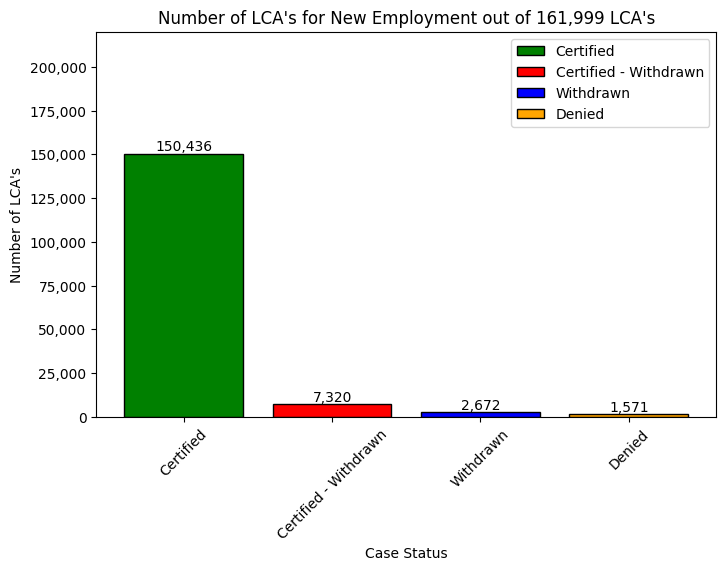

time: 362 ms (started: 2024-06-11 15:04:28 -04:00)


In [45]:
### Plot a bar chart to show the number of certified and denied LCA's for new employment

# Create the figure and axes objects
fig, ax = plt.subplots(figsize=(8, 5))

# Create the bar chart that plots a bar chart and returns the Container object
# Its parameters are the x-axis values, the y-axis values, the edge color, the colors, and the labels of the bars
container = ax.bar(new_employment['CASE_STATUS'].value_counts().index, 
                   new_employment['CASE_STATUS'].value_counts().values,
                   edgecolor='black',
                   color=['green', 'red', 'blue', 'orange'],
                   label=new_employment['CASE_STATUS'].value_counts().index)

# Set the title of the plot, x-axis label, y-axis label, y-axis limits, y-axis formatter, the legend, and the x-axis rotation
ax.set_title(f'Number of LCA\'s for New Employment out of {new_employment['CASE_STATUS'].count():,} LCA\'s')
ax.set_xlabel('Case Status');
ax.set_ylabel('Number of LCA\'s');
ax.set_ylim(0, 220000);
ax.bar_label(container, fmt='{:,.0f}', label_type='edge');
ax.legend(loc='upper right');
ax.tick_params(axis='x', rotation=45);
ax.yaxis.set_major_formatter('{:,.0f}'.format);

# Show the plot
plt.show();

More information can be found on the factors that determine the certification of an LCA in the Code of Federal Regulations (navigate to 20 CFR 655.740(a)(2)) [here](https://www.ecfr.gov/current/title-20/part-655#p-655.740(a)(2)).

Let's preview the denied ones.

In [46]:
# Preview the denied LCA's for new employment
new_employment[new_employment['CASE_STATUS'] == 'Denied'].head()

CASE_NUMBER CASE_STATUS RECEIVED_DATE DECISION_DATE  \
158  I-200-23271-388770      Denied    2023-09-28    2023-09-29   
160  I-200-23271-389183      Denied    2023-09-28    2023-09-29   
161  I-203-23271-390643      Denied    2023-09-28    2023-09-29   
165  I-200-23271-391260      Denied    2023-09-28    2023-09-29   
167  I-200-23271-391248      Denied    2023-09-28    2023-09-29   

    ORIGINAL_CERT_DATE      VISA_CLASS  \
158                NaT            H-1B   
160                NaT            H-1B   
161                NaT  E-3 Australian   
165                NaT            H-1B   
167                NaT            H-1B   

                                             JOB_TITLE    SOC_CODE  \
158                               Marketing Specialist  13-1161.00   
160                             HALAL MEAL SLAUGHTERER  51-3023.00   
161  Procurement Manager (Senior Manager of Contracts)  11-3061.00   
165                          Sales & Marketing Manager  11-2021.00   
167                                    Azure Developer  15-1252.00   

                                             SOC_TITLE FULL_TIME_POSITION  \
158  Market Research Analysts and Marketing Special...                  Y   
160                      Slaughterers and Meat Packers                  Y   
161                                Purchasing Managers                  Y   
165                                 Marketing Managers                  Y   
167                                Software Developers                  Y   

    BEGIN_DATE   END_DATE  TOTAL_WORKER_POSITIONS  NEW_EMPLOYMENT  \
158 2023-12-11 2026-12-10                       1               1   
160 2024-03-01 2027-02-28                       1               1   
161 2023-10-23 2025-10-22                       1               1   
165 2023-10-02 2026-10-01                       1               1   
167 2023-10-18 2026-10-17                       1               1   

     CONTINUED_EMPLOYMENT  CHANGE_PREVIOUS_EMPLOYMENT  \
158                     0                           0   
160                     0                           0   
161                     0                           0   
165                     0                           0   
167                     0                           0   

     NEW_CONCURRENT_EMPLOYMENT  CHANGE_EMPLOYER  AMENDED_PETITION  \
158                          0                0                 0   
160                          0                0                 0   
161                          0                0                 0   
165                          0                0                 0   
167                          0                0                 0   

                       EMPLOYER_NAME TRADE_NAME_DBA  \
158            Beyond Beauty DMV Inc     BSW Beauty   
160  SALEM HALAL MEAT PACKAGING LLC             NaN   
161        Praecipio Enterprises LLC            NaN   
165        Jurney & Associates, Inc.            NaN   
167              se38 Solutions LLC             NaN   

             EMPLOYER_ADDRESS1 EMPLOYER_ADDRESS2     EMPLOYER_CITY  \
158              130 Wesley St               NaN  South Hackensack   
160     705 SALEM QUINTON ROAD               NaN             SALEM   
161     3105 E.  Fairmount Ave                22           Phoenix   
165  782 Northwest 42nd Avenue         Suite 428             Miami   
167      2340 The Courts Drive               NaN      Chesterfield   

    EMPLOYER_STATE EMPLOYER_POSTAL_CODE          EMPLOYER_COUNTRY  \
158             NJ                07606  UNITED STATES OF AMERICA   
160             NJ                08079  UNITED STATES OF AMERICA   
161             AZ                85016  UNITED STATES OF AMERICA   
165             FL                33126  UNITED STATES OF AMERICA   
167             MO                63017  UNITED STATES OF AMERICA   

    EMPLOYER_PROVINCE  EMPLOYER_PHONE  EMPLOYER_PHONE_EXT  NAICS_CODE  \
158               NaN     13109565988                 NaN  

time: 147 ms (started: 2024-06-11 15:04:28 -04:00)


A Labor Condition Application can be denied for any reasons that include incorrectly entered information, submitting an LCA too soon before the employment start date, or unsigned documents on the part of the employer. Let's find out how many workers were present in each of the categories for the CASE_STATUS column.

In [47]:
# Find the sum of the values in the 'NEW_EMPLOYMENT' column by grouping the data by the 'CASE_STATUS' column
new_employment.groupby('CASE_STATUS')['NEW_EMPLOYMENT'].sum()

CASE_STATUS
Certified                332799
Certified - Withdrawn      7711
Denied                     3944
Withdrawn                  3456
Name: NEW_EMPLOYMENT, dtype: int64

time: 17.7 ms (started: 2024-06-11 15:04:28 -04:00)


We will now filter out the data to include only cases whose LCAs were certified.

In [48]:
# Create a new dataframe that includes only the values in the 'CASE_STATUS' column that are equal to 'Certified'
certified = new_employment[new_employment['CASE_STATUS'] == 'Certified']
certified.info()

<class 'pandas.core.frame.DataFrame'>
Index: 150436 entries, 185 to 633588
Data columns (total 96 columns):
 #   Column                          Non-Null Count   Dtype         
---  ------                          --------------   -----         
 0   CASE_NUMBER                     150436 non-null  object        
 1   CASE_STATUS                     150436 non-null  object        
 2   RECEIVED_DATE                   150436 non-null  datetime64[ns]
 3   DECISION_DATE                   150436 non-null  datetime64[ns]
 4   ORIGINAL_CERT_DATE              0 non-null       datetime64[ns]
 5   VISA_CLASS                      150436 non-null  object        
 6   JOB_TITLE                       150436 non-null  object        
 7   SOC_CODE                        150436 non-null  object        
 8   SOC_TITLE                       150436 non-null  object        
 9   FULL_TIME_POSITION              150436 non-null  object        
 10  BEGIN_DATE                      150436 non-null  datetime64

150,436 rows are present in this dataset. Let's find out how many new employees were contained in the Labor Condition Applications that were certified by the DOL.

In [49]:
# Find the sum of the values in the 'NEW_EMPLOYMENT' column
certified['NEW_EMPLOYMENT'].sum()

332799

time: 3.55 ms (started: 2024-06-11 15:04:29 -04:00)


332,799 new employees are included in the Labor Condition Applications whose case status was certified in the fiscal year 2023.

Printing out all of the rows has become tedious. For our notebook, we will need to limit how many rows appear in a singular view of the output of each code cell, to 20 rows.

In [50]:
# Display a maximum of 20 rows
pd.set_option("display.max_rows", 20)

time: 655 µs (started: 2024-06-11 15:04:29 -04:00)


## Visa Class

Our analysis involves a deep dive into insights related to the H-1B program. According to the Department of Labor, the different visa categories that Form ETA-9035 is used for are detailed below. 

The H-1B visa allows an employer to temporarily employ foreign professional workers in the U.S. on a nonimmigrant basis in a specialty occupation or as a fashion model of distinguished merit and ability. Under 20 CFR 655.715, a specialty occupation requires the theoretical and practical application of a body of specialized knowledge and a bachelor's degree or the equivalent in the specific specialty (e.g., sciences, medicine and health care, education, biotechnology, business specialties, etc.).

The H-1B1-Chile visa allows an employer to temporarily employ business professionals who are nationals of Chile under the Chile Free Trade Agreement.

The H-1B1-Singapore visa allows an employer to temporarily employ business professionals who are nationals of Singapore under the Singapore Free Trade Agreement.

The E-3 Australia visa allows an employer to temporarily employ business professionals who are nationals of Australia under Title V of the REAL ID Act of 2005 (Division B) in the Emergency Supplemental Appropriations Act for Defense, the Global War on Terror, and Tsunami Relief, 2005.

In accordance with the interests of the research question posed for this analysis, we will focus on the H-1B program. To help us do that, we will take a look at how many entries are in the VISA_CLASS column and how they are distributed.

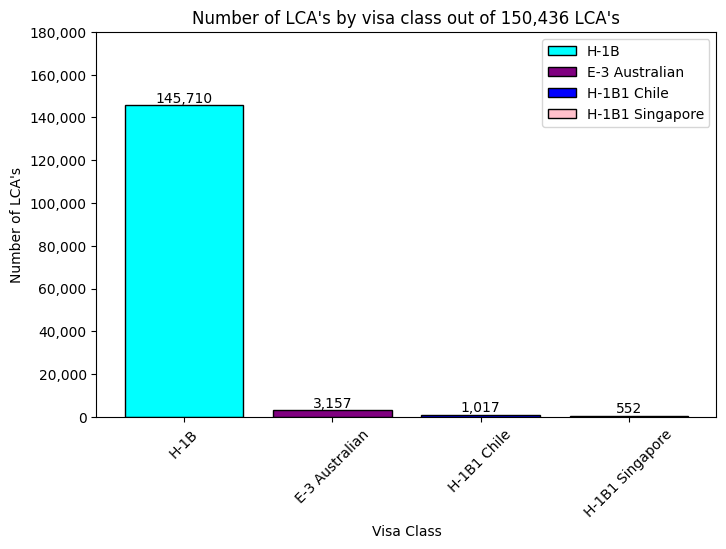

time: 258 ms (started: 2024-06-11 15:04:29 -04:00)


In [51]:
### Draw a bar graph to show the number of certified LCA's for new employment by VISA_CLASS

# Create the figure and axes objects
fig, ax = plt.subplots(figsize=(8, 5))

# Create the bar chart that plots a bar chart and returns the Container object
# Its parameters are the x-axis values, the y-axis values, the edge color, the colors of the bars, and the labels of the bars
container = ax.bar(certified['VISA_CLASS'].value_counts().index, 
                   certified['VISA_CLASS'].value_counts().values,
                   edgecolor='black',
                   color=['cyan', 'purple', 'blue', 'pink'],
                   label=certified['VISA_CLASS'].value_counts().index)

# Set the title of the plot, x-axis label, y-axis label, y-axis limits, y-axis formatter, the legend, and the x-axis rotation
ax.set_title(f'Number of LCA\'s by visa class out of {certified['VISA_CLASS'].count():,} LCA\'s')
ax.set_xlabel('Visa Class');
ax.set_ylabel('Number of LCA\'s');
ax.bar_label(container, fmt='{:,.0f}', label_type='edge');
ax.set_ylim(0, 180000)
ax.yaxis.set_major_formatter('{:,.0f}'.format)
ax.legend(loc='upper right')
ax.tick_params(axis='x', rotation=45)

# Show the plot
plt.show();

In [52]:
# ### Let's plot a pie chart to show the distribution of the number of certified LCA's by VISA_CLASS
# # Create the figure and axes objects
# fig, ax = plt.subplots(figsize=(8, 5))

# # Draw the pie chart that returns the wedges, texts, and autotexts objects of the pie chart
# # Its parameters are the values, the labels, the autopct, the colors, and the start angle of the pie chart
# wedges, texts, autotexts = ax.pie(certified['VISA_CLASS'].value_counts().values,
#                                   labels=certified['VISA_CLASS'].value_counts().index,
#                                   autopct='%1.1f%%',
#                                   colors=['cyan', 'purple', 'blue', 'pink'],
#                                   startangle=90)

# # Set the title of the pie chart
# ax.set_title(f'Percentage of LCA\'s by visa class out of {certified["VISA_CLASS"].count():,} LCA\'s')

# # Set the aspect ratio of the pie chart to be equal
# plt.show();

time: 957 µs (started: 2024-06-11 15:04:29 -04:00)


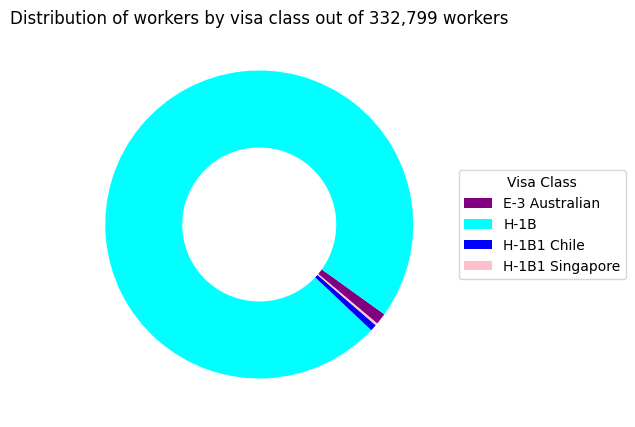

time: 196 ms (started: 2024-06-11 15:04:29 -04:00)


In [53]:
### Let's plot a pie chart to show the distribution of the number of certified LCA's by VISA_CLASS
# Create the figure and axes objects
fig, ax = plt.subplots(figsize=(8, 5), subplot_kw=dict(aspect="equal"))

# Draw the pie chart that returns the wedges, texts, and autotexts objects of the pie chart
# Its parameters are the values, the labels, the autopct, the colors, and the start angle of the pie chart
# wedges, texts = ax.pie(certified['VISA_CLASS'].value_counts().values,
#                        wedgeprops=dict(width=0.5),
#                        colors=['cyan', 'purple', 'blue', 'pink'],
#                        startangle=-40)

wedges, texts = ax.pie(certified.groupby('VISA_CLASS')['NEW_EMPLOYMENT'].sum().values,
                       wedgeprops=dict(width=0.5),
                       colors=['purple', 'cyan', 'blue', 'pink'],
                       startangle=-40)


# bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.72)
# kw = dict(arrowprops=dict(arrowstyle="-"),
#           bbox=bbox_props, zorder=0, va="center")

# for i, p in enumerate(wedges):
#     ang = (p.theta2 - p.theta1)/2. + p.theta1
#     y = np.sin(np.deg2rad(ang))
#     x = np.cos(np.deg2rad(ang))
#     horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
#     connectionstyle = f"angle,angleA=0,angleB={ang}"
#     kw["arrowprops"].update({"connectionstyle": connectionstyle})
#     ax.annotate(certified['VISA_CLASS'].value_counts().index[i], xy=(x, y), xytext=(1.35*np.sign(x), 1.4*y),
#                 horizontalalignment=horizontalalignment, **kw)

# Set the title of the pie chart
ax.set_title(f'Distribution of workers by visa class out of {certified["NEW_EMPLOYMENT"].sum():,} workers')

# Show the legend
ax.legend(wedges,
          certified.groupby('VISA_CLASS')['NEW_EMPLOYMENT'].sum().index,
          title="Visa Class",
          loc="center left",
          bbox_to_anchor=(1, 0, 0.5, 1))


# Set the aspect ratio of the pie chart to be equal
plt.show();

From this graph, we can see that a huge portion of these LCA's are devoted to the employment of H-1B workers. Let's see how many workers are in each category.

In [54]:
# Find the sum of values in the 'NEW_EMPLOYMENT' column for each 'VISA_CLASS'
certified.groupby('VISA_CLASS')['NEW_EMPLOYMENT'].sum()

VISA_CLASS
E-3 Australian       4001
H-1B               325699
H-1B1 Chile          2299
H-1B1 Singapore       800
Name: NEW_EMPLOYMENT, dtype: int64

time: 18.9 ms (started: 2024-06-11 15:04:30 -04:00)


From this graph, we can see that a huge portion of these LCA's are devoted to the employment of H-1B workers. Let's filter our dataset and focus on the H-1B visa class on its own.

In [55]:
# Create a new dataframe that includes only the values in the 'VISA_CLASS' column that are equal to 'H-1B'
# Preview the information from all of the columns in the dataset
certified_h1b = certified[certified['VISA_CLASS'] == 'H-1B']
certified_h1b.info()

<class 'pandas.core.frame.DataFrame'>
Index: 145710 entries, 185 to 633588
Data columns (total 96 columns):
 #   Column                          Non-Null Count   Dtype         
---  ------                          --------------   -----         
 0   CASE_NUMBER                     145710 non-null  object        
 1   CASE_STATUS                     145710 non-null  object        
 2   RECEIVED_DATE                   145710 non-null  datetime64[ns]
 3   DECISION_DATE                   145710 non-null  datetime64[ns]
 4   ORIGINAL_CERT_DATE              0 non-null       datetime64[ns]
 5   VISA_CLASS                      145710 non-null  object        
 6   JOB_TITLE                       145710 non-null  object        
 7   SOC_CODE                        145710 non-null  object        
 8   SOC_TITLE                       145710 non-null  object        
 9   FULL_TIME_POSITION              145710 non-null  object        
 10  BEGIN_DATE                      145710 non-null  datetime64

With the filters we've added throughout this analysis, the count of total entries has decreased from 644,607 to 170,245. Let's see how many H-1B workers there are in this data frame.

In [56]:
# Find the sum of the values in the 'NEW_EMPLOYMENT' column of the certified H-1B dataset
certified_h1b['NEW_EMPLOYMENT'].sum()

325699

time: 4.44 ms (started: 2024-06-11 15:04:30 -04:00)


## Job Titles


Now that we have filtered out the H-1B visa class, let's look at the different job titles that H-1B workers have and how they are distributed.

It would make sense to use the JOB_TITLE column, however it brings some challenges.[<sup id="fn1-back">1</sup>](#fn1) I will illustrate these challenges by creating a bar plot of the top 20 job titles from the employers who submitted an LCA for H-1B nonimmigrant workers. 

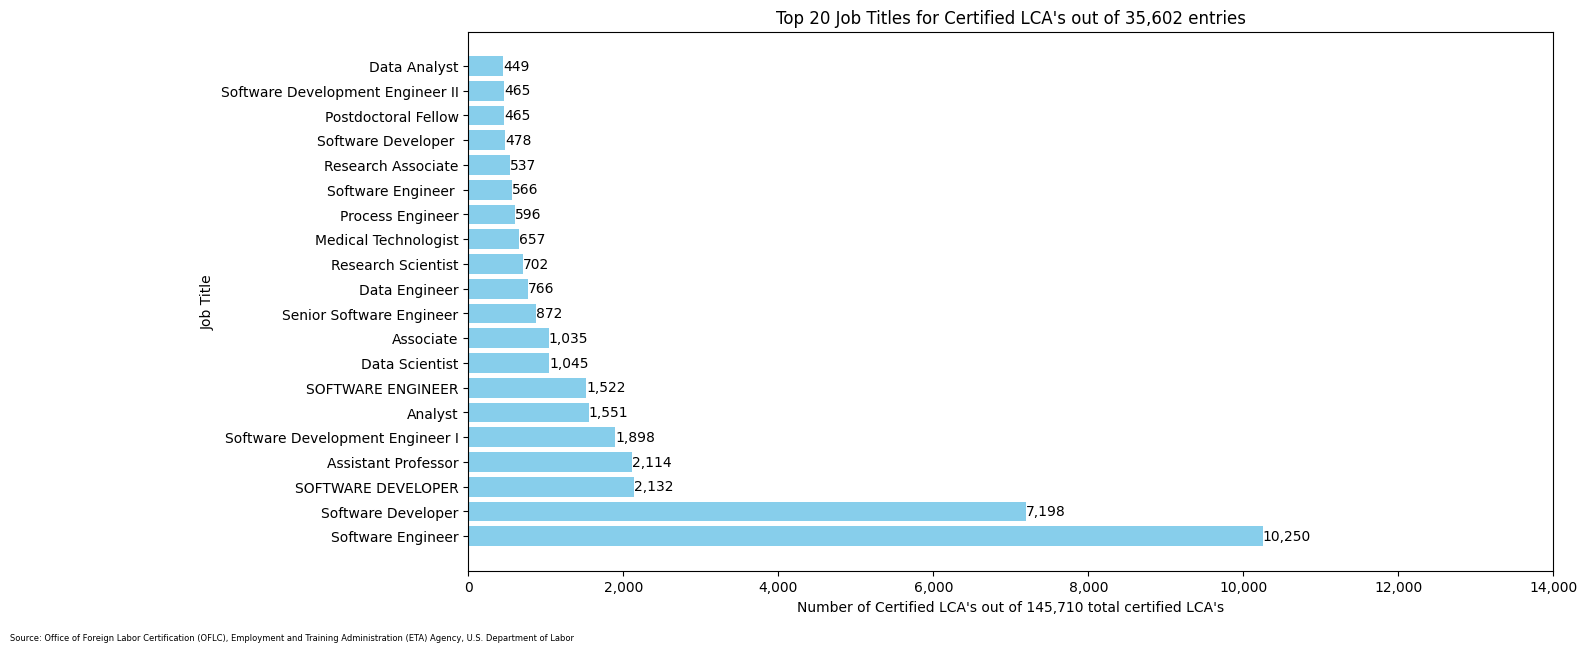

time: 765 ms (started: 2024-06-11 15:04:30 -04:00)


In [57]:
### Draw a bar chart to show the top 10 job titles
# Create the figure and axes objects
fig, ax = plt.subplots(figsize=(14, 7))

# Create the bar chart that plots a horizontal bar chart and returns the Container object
container = ax.barh(certified_h1b['JOB_TITLE'].value_counts()[0:20].index,
                    certified_h1b['JOB_TITLE'].value_counts()[0:20].values,
                    color='skyblue');
ax.bar_label(container, fmt='{:,.0f}');
ax.set_title(f'Top 20 Job Titles for Certified LCA\'s out of {certified_h1b['JOB_TITLE'].nunique():,} entries');
ax.set_ylabel('Job Title');
ax.set_xlabel(f'Number of Certified LCA\'s out of {certified_h1b.shape[0]:,} total certified LCA\'s');
ax.set_xlim(0, 14000);
ax.xaxis.set_major_formatter('{:,.0f}'.format);
ax.annotate(text='Source: Office of Foreign Labor Certification (OFLC), Employment and Training Administration (ETA) Agency, U.S. Department of Labor',
            xy=(0,0),
            xytext=(-330,-50),
            fontsize=6,
            xycoords='axes fraction',
            textcoords='offset points');

# Show the plot
plt.show();

These are the top 20 job titles out of a whopping 36,938 unique entries in the JOB_TITLE field!

And while it's certainly normal to want to get any insights from these numbers, I would like to draw your attention to the job titles that appear in this top 20 list. A quick scan of the list will reveal job titles that appear to be similar at first glance, namely the job titles "Software Engineer", "Software Development Engineer I", and "Software Developer". This presents a huge source of ambiguity when it comes to the job titles themselves and the number of entries for each of those job titles, possibly due to the different ways that employers categorize the jobs at each of their organizations.

Fortunately, a way to circumvent this problem has been to use the SOC_TITLE and SOC_CODE columns instead of the JOB_TITLE column for our analysis. The SOC title and code both come from the Standard Occupational Code (SOC) system created by the Department of Labor's Bureau of Labor Statistics, in order to collect, calculate, and share data about occupations in the U.S. labor market across multiple agencies and organizations. 

According to the page 1 of the 2018 SOC Manual, "the SOC covers all jobs in the national economy, including occupations in the public, private, and military sectors." And it has done so by creating a system such that each job title falls under a group called its _detailed occupation_. That job title's detailed occupation is one of *867* detailed occupations as defined by the SOC system. 

Each job title therefore is associated with an SOC title and a corresponding SOC code to help classify it. For example, going back to the Software Engineer job title, that would be classified under the SOC title "Software Developers" with the SOC code 15-1252. 

The classification system uses different levels beyond just the detailed occupation classification, and more information about the system including its definitions, codes, its uses, and its history can be found [here](https://www.bls.gov/soc/).

To illustrate an example of why this classification system will be used in this analysis, I will once again use the previous example of the Software Engineer job title.

In [58]:
# Create a new dataframe that includes only the values in the 'SOC_CODE' column that are equal to 15-1252, the SOC code for Software Developers
# Print the number of unique job titles that were entered for LCA's classified as software developers
software_developers = certified_h1b[certified_h1b['SOC_CODE'].str.startswith('15-1252')]
print(f"There are {software_developers['JOB_TITLE'].nunique():,} different job titles that were entered for LCA's classified as Software Developers.")

There are 6,688 different job titles that were entered for LCA's classified as Software Developers.
time: 120 ms (started: 2024-06-11 15:04:31 -04:00)


That's a lot of different job titles that are classified under this one detailed occupation. Perhaps an analysis of these job titles can be considered among future work. As of this moment, we will focus on using the SOC title and SOC code.

And I suppose it wouldn't hurt to learn more about the classification system by reading through a 285-page manual, would it?

In [59]:
# Show the counts of the different job titles that were entered for LCA's classified as software developers
software_developers['JOB_TITLE'].value_counts()

JOB_TITLE
Software Engineer                    9779
Software Developer                   7035
SOFTWARE DEVELOPER                   2107
Software Development Engineer I      1875
SOFTWARE ENGINEER                    1405
                                     ... 
Web Development and Data Analyst        1
Senior Engineer, Test Engineering       1
SOFTWARE DEVELOPER - CLOUD/CRM          1
BI/Data Engineer                        1
J2EE Developer Senior                   1
Name: count, Length: 6688, dtype: int64

time: 11.2 ms (started: 2024-06-11 15:04:31 -04:00)


That's a lot of different job titles to look at for the Software Developers classification. Let's look at what proportion of the H-1B LCA's were certified to Software Developers.

In [60]:
# Show the number of times that the SOC_CODE 15-1252 appears in the dataset
print(f"Software Developers: {software_developers.shape[0]:,}")
print(f"Total Certified LCAs for H-1B workers beginning new employment: {certified_h1b.shape[0]:,}")

Software Developers: 48,642
Total Certified LCAs for H-1B workers beginning new employment: 145,710
time: 750 µs (started: 2024-06-11 15:04:31 -04:00)


Out of the 145,710 certified LCA entries for H-1B workers beginning new employment, 48,642 of them were classified as Software Developers. That's more than 30%! Staggering! Before we add this to our results, we need to pay more specific attention to the SOC titles mentioned earlier as part of this analysis.

## TODO: SOC Titles

Examining the SOC titles and the SOC codes will allow us to make important insights about the occupations of specialty workers. The SOC title and code both come from the Standard Occupational Code (SOC) system created by the Department of Labor's Bureau of Labor Statistics, in order to collect, calculate, and share data about occupations in the U.S. labor market across multiple agencies and organizations. 

According to the page 1 of the 2018 SOC Manual, "the SOC covers all jobs in the national economy, including occupations in the public, private, and military sectors." And it has done so by creating a system such that each job title falls under a group called its _detailed occupation_. That job title's detailed occupation is one of *867* detailed occupations as defined by the SOC system. 

Each job title therefore is associated with an SOC title and a corresponding SOC code to help classify it. For example, going back to the Software Engineer job title, that would be classified under the SOC title "Software Developers" with the SOC code 15-1252. 

The classification system uses different levels beyond just the detailed occupation classification, and more information about the system including its definitions, codes, its uses, and its history can be found [here](https://www.bls.gov/soc/).

We want to examine how the different SOC titles appeared among the certified H-1B LCAs for workers beginning new employment.

In [61]:
# ### Plot a bar graph of the different SOC titles that appear in the dataset for certified H-1B LCA's for all employers

# # Create the figure and axes objects
# fig, ax = plt.subplots(figsize=(22, 14))

# # Create the bar chart that plots a horizontal bar chart and returns the Container object
# container = ax.barh(certified_h1b['SOC_TITLE'].value_counts()[0:20].index,
#                     certified_h1b['SOC_TITLE'].value_counts()[0:20].values,
#                     color='skyblue');

# # Set the title of the plot, x-axis label, y-axis label, y-axis limits, y-axis formatter, and the annotation
# ax.bar_label(container, fmt='{:,.0f}');
# ax.set_title(f'Top 20 SOC Titles for Certified LCA\'s out of {certified_h1b['SOC_TITLE'].nunique():,} entries');
# ax.set_ylabel('SOC Title');
# ax.set_xlabel(f'Number of Certified LCA\'s out of {certified_h1b.shape[0]:,} total certified LCA\'s');
# ax.set_xlim(0, 50000);
# ax.xaxis.set_major_formatter('{:,.0f}'.format);
# ax.annotate(text='Source: Office of Foreign Labor Certification (OFLC), Employment and Training Administration (ETA) Agency, U.S. Department of Labor',
#             xy=(0,0),
#             xytext=(-280,-50),
#             fontsize=6,
#             xycoords='axes fraction',
#             textcoords='offset points');

# # Show the plot
# plt.show();

time: 671 µs (started: 2024-06-11 15:04:31 -04:00)


Let's move ahead with our analysis of the SOC titles.

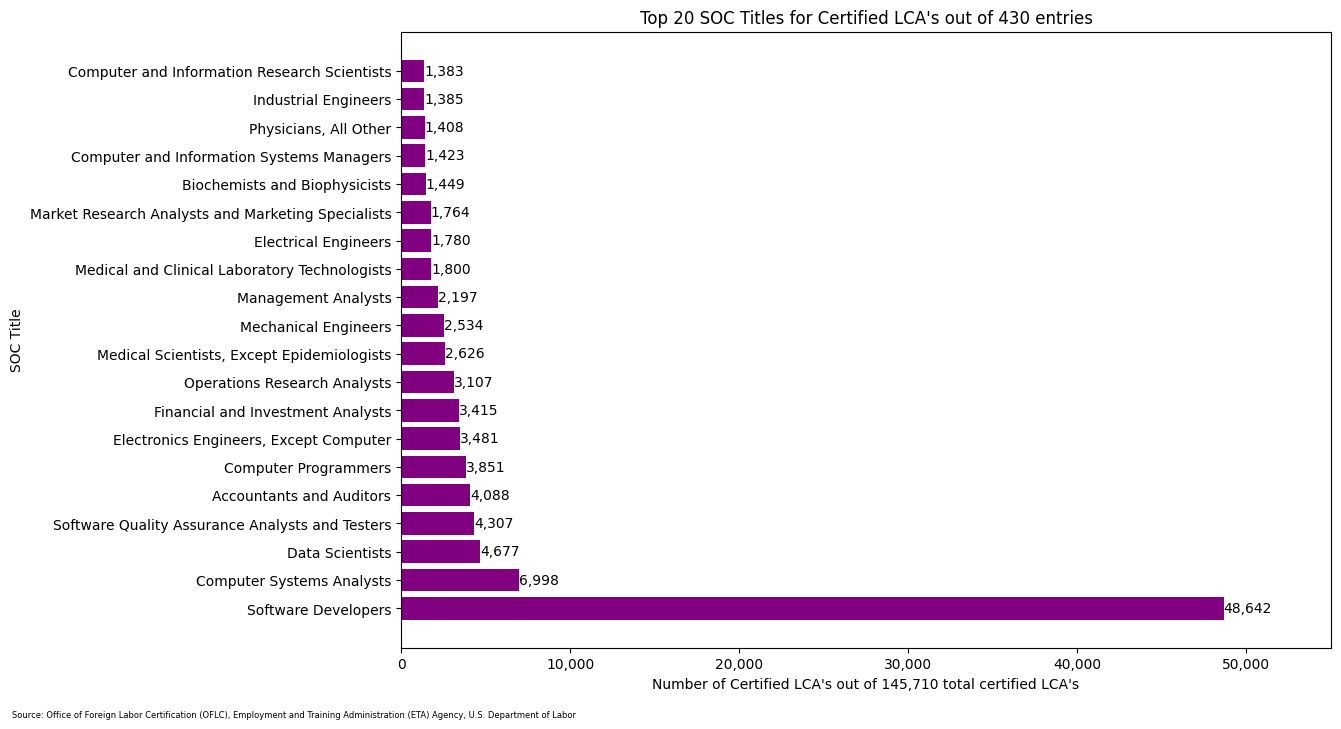

time: 649 ms (started: 2024-06-11 15:04:31 -04:00)


In [62]:
### Plot a bar graph of the top 20 SOC titles that appear in the dataset for certified LCA's for newly employed H-1B workers
# Create the figure and axes objects
fig, ax = plt.subplots(figsize=(12, 8))

# Create the bar chart that plots a horizontal bar chart and returns the Container object
container = ax.barh(certified_h1b['SOC_TITLE'].value_counts()[0:20].index,
                    certified_h1b['SOC_TITLE'].value_counts()[0:20].values, 
                    color='purple');

# Set the title of the plot, x-axis label, y-axis label, y-axis formatter, and the annotation
ax.bar_label(container, fmt='{:,.0f}');
ax.set_title(f'Top 20 SOC Titles for Certified LCA\'s out of {certified_h1b['SOC_TITLE'].nunique():,} entries');
ax.set_ylabel('SOC Title');
ax.set_xlabel(f'Number of Certified LCA\'s out of {certified_h1b.shape[0]:,} total certified LCA\'s');
ax.xaxis.set_major_formatter('{:,.0f}'.format);
ax.set_xlim(0, 55000);
ax.annotate(text='Source: Office of Foreign Labor Certification (OFLC), Employment and Training Administration (ETA) Agency, U.S. Department of Labor',
            xy=(0,0),
            xytext=(-280,-50),
            fontsize=6,
            xycoords='axes fraction',
            textcoords='offset points');

By sheer numbers, we can see that Software Developers account a large portion of the SOC titles listed in the dataset, but how much? 

In [63]:
# Divide the values of the certified_h1b['SOC_TITLE'].value_counts() by the total number of entries in the certified_h1b dataframe
# Multiply the result by 100 to get the percentage of each SOC title in the certified_h1b dataframe
certified_h1b['SOC_TITLE'].value_counts().div(certified_h1b.shape[0]).mul(100)

SOC_TITLE
Software Developers                                               33.382747
Computer Systems Analysts                                          4.802690
Data Scientists                                                    3.209800
Software Quality Assurance Analysts and Testers                    2.955871
Accountants and Auditors                                           2.805573
                                                                    ...    
Bartenders                                                         0.000686
Hosts and Hostesses, Restaurant, Lounge, and Coffee Shop           0.000686
First-Line Supervisors of Mechanics, Installers, and Repairers     0.000686
Occupational Therapy Assistants                                    0.000686
Teaching Assistants, Special Education                             0.000686
Name: count, Length: 430, dtype: float64

time: 18.5 ms (started: 2024-06-11 15:04:32 -04:00)


In [64]:
print(f"There are {certified_h1b.shape[0]:,} certified LCA's for H-1B applications whose SOC titles were accurately entered.")
print(f"There are {certified_h1b[certified_h1b['SOC_TITLE'] == 'Software Developers']['JOB_TITLE'].nunique():,} different job titles that were entered for LCA's classified as software developers.")

There are 145,710 certified LCA's for H-1B applications whose SOC titles were accurately entered.
There are 6,688 different job titles that were entered for LCA's classified as software developers.
time: 97.3 ms (started: 2024-06-11 15:04:32 -04:00)


### TODO: GitHub Copilot suggested using 15-1132 as the SOC_CODE for software developers. according to the SOC manual, it's 15-1252. Submit this correction to GitHub Copilot.

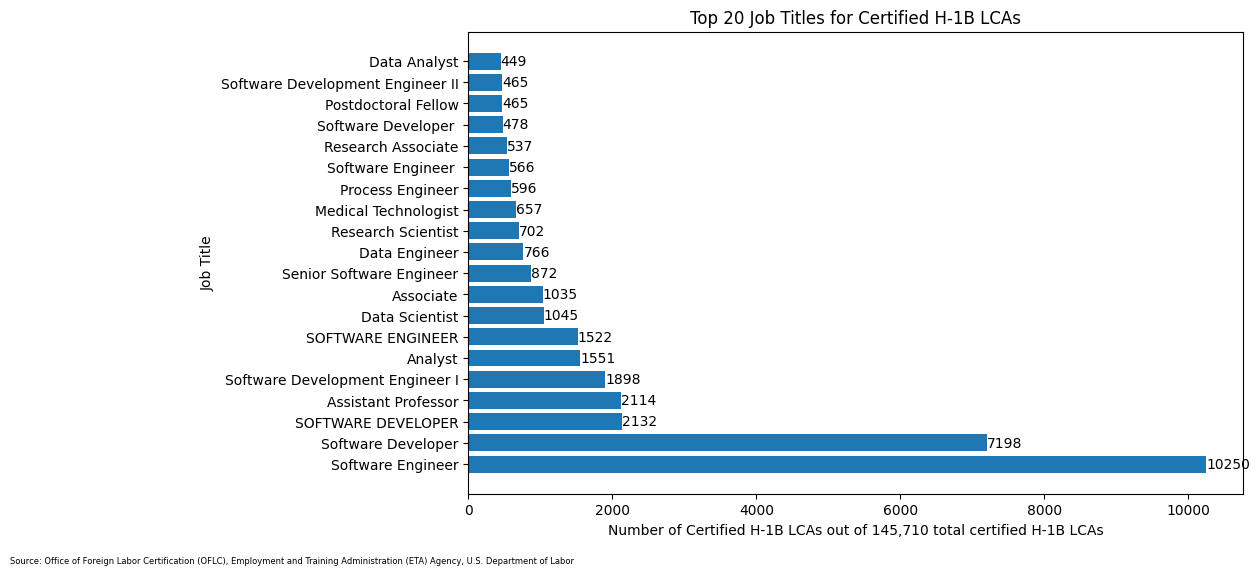

time: 592 ms (started: 2024-06-11 15:04:32 -04:00)


In [65]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.barh(certified_h1b['JOB_TITLE'].value_counts()[0:20].index, certified_h1b['JOB_TITLE'].value_counts()[0:20].values);
ax.bar_label(ax.containers[0]);
ax.title.set_text('Top 20 Job Titles for Certified H-1B LCAs');
ax.set_ylabel('Job Title');
ax.set_xlabel(f'Number of Certified H-1B LCAs out of {certified_h1b['CASE_NUMBER'].nunique():,} total certified H-1B LCAs');
ax.annotate(text='Source: Office of Foreign Labor Certification (OFLC), Employment and Training Administration (ETA) Agency, U.S. Department of Labor', xy=(0,0), xytext=(-330,-50), fontsize=6, 
             xycoords='axes fraction', textcoords='offset points');

## TODO: Wage Statistics

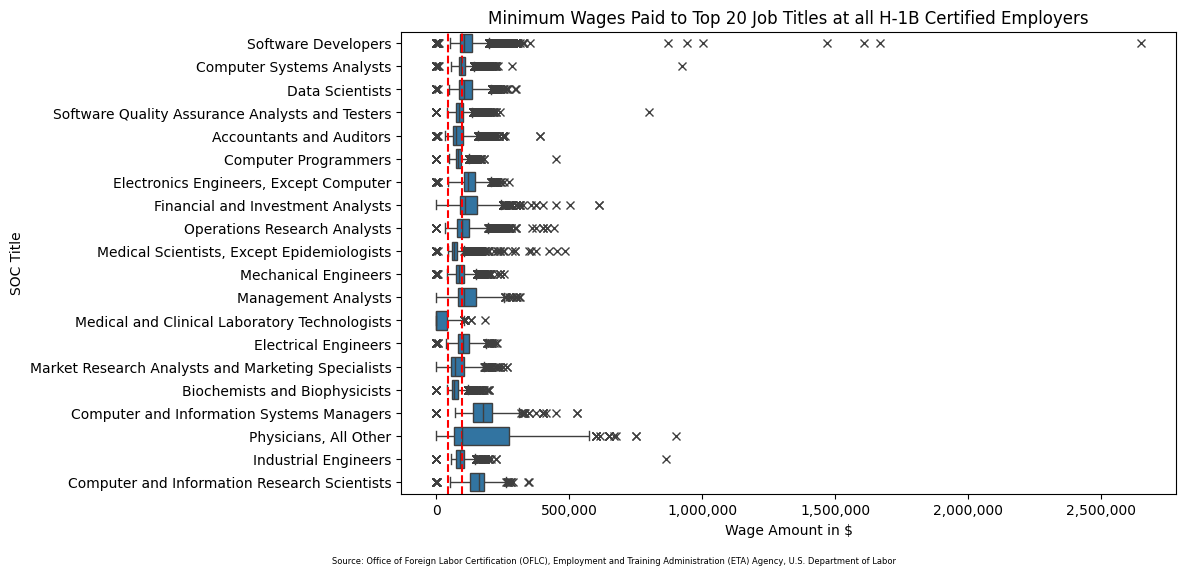

time: 865 ms (started: 2024-06-11 15:04:33 -04:00)


In [66]:
# Let's use the Seaborn package to create a boxplot of the PREVAILING_WAGE values for the top 20 jobs at colleges and universities
fig, ax = plt.subplots(figsize=(10, 6))
sns.boxplot(x='WAGE_RATE_OF_PAY_FROM', y='SOC_TITLE', 
            data=certified_h1b, order=certified_h1b['SOC_TITLE'].value_counts()[0:20].index, 
            ax=ax,
            flierprops={"marker": "x"});
ax.set_title('Minimum Wages Paid to Top 20 Job Titles at all H-1B Certified Employers');
ax.set_xlabel('Wage Amount in $');
ax.set_ylabel('SOC Title');
ax.xaxis.set_major_formatter('{:,.0f}'.format);
ax.annotate(text='Source: Office of Foreign Labor Certification (OFLC), Employment and Training Administration (ETA) Agency, U.S. Department of Labor', xy=(0,0), xytext=(-50,-50), fontsize=6, 
             xycoords='axes fraction', textcoords='offset points');

plt.axvline(x=45000, color='red', linestyle='--');
plt.axvline(x=95000, color='red', linestyle='--');

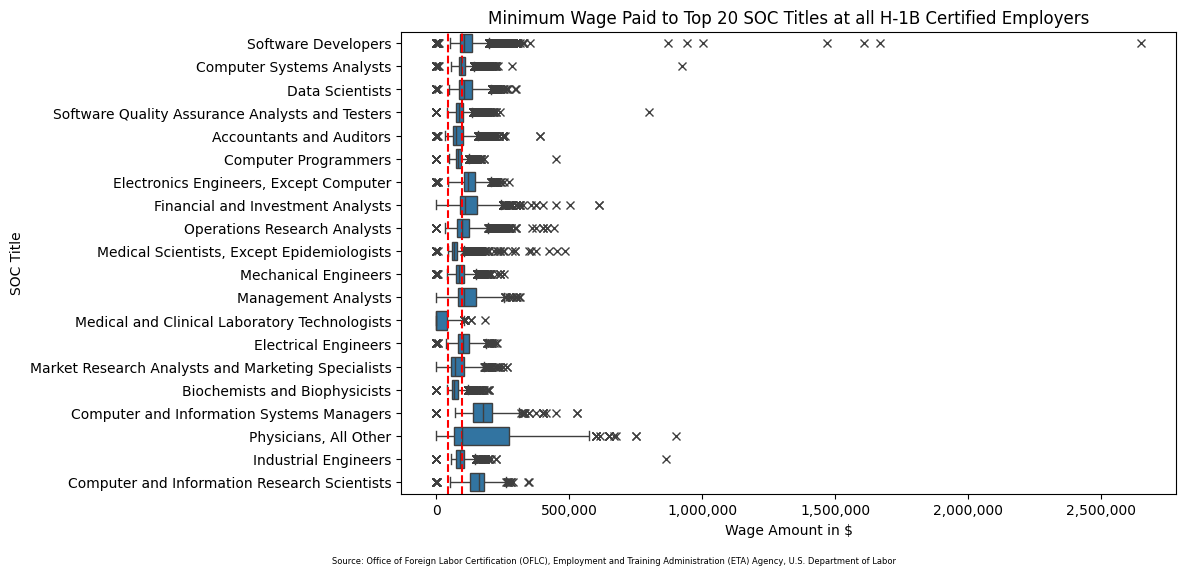

time: 799 ms (started: 2024-06-11 15:04:34 -04:00)


In [67]:
# Let's use the Seaborn package to create a boxplot of the WAGE_RATE_OF_PAY_FROM values for the top 20 jobs at colleges and universities
fig, ax = plt.subplots(figsize=(10, 6))
sns.boxplot(x='WAGE_RATE_OF_PAY_FROM', y='SOC_TITLE', 
            data=certified_h1b, order=certified_h1b['SOC_TITLE'].value_counts()[0:20].index, 
            ax=ax,
            flierprops={"marker": "x"});
ax.set_title('Minimum Wage Paid to Top 20 SOC Titles at all H-1B Certified Employers');
ax.set_xlabel('Wage Amount in $');
ax.set_ylabel('SOC Title');
ax.xaxis.set_major_formatter('{:,.0f}'.format);
ax.annotate(text='Source: Office of Foreign Labor Certification (OFLC), Employment and Training Administration (ETA) Agency, U.S. Department of Labor', xy=(0,0), xytext=(-50,-50), fontsize=6, 
             xycoords='axes fraction', textcoords='offset points');

plt.axvline(x=45000, color='red', linestyle='--');
plt.axvline(x=95000, color='red', linestyle='--');

In [68]:
# Let's use the Plotly Graph Objects to create a boxplot of the PREVAILING_WAGE values for the top 20 job titles in the certified H-1B LCAs dataset
fig = go.Figure()
for soc in certified_h1b['SOC_TITLE'].value_counts()[0:10].index:
    fig.add_trace(go.Box(x=certified_h1b[certified_h1b['SOC_TITLE'] == soc]['WAGE_RATE_OF_PAY_FROM'], name=soc))
fig.update_layout(title='Minimum Wages paid to Top 20 SOC Titles at all H-1B Certified Employers',
                  xaxis_title='Wage in $',
                  yaxis_title='SOC Title',
                  showlegend=False)
# fig.add_annotation(text='Source: Office of Foreign Labor Certification (OFLC), Employment and Training Administration (ETA) Agency, U.S. Department of Labor', xref='paper', yref='paper', x=0, y=0, xshift=-50, yshift=-50, font_size=6)
fig.show()

time: 932 ms (started: 2024-06-11 15:04:35 -04:00)


In [69]:
certified_h1b['WAGE_UNIT_OF_PAY'].info()

<class 'pandas.core.series.Series'>
Index: 145710 entries, 185 to 633588
Series name: WAGE_UNIT_OF_PAY
Non-Null Count   Dtype 
--------------   ----- 
145709 non-null  object
dtypes: object(1)
memory usage: 2.2+ MB
time: 14.2 ms (started: 2024-06-11 15:04:35 -04:00)


In [70]:
# let's see what the prevailing wage was for all of the entries whose unit of pay was the 'Year'
certified_h1b_year = certified_h1b[certified_h1b['WAGE_UNIT_OF_PAY'] == 'Year']
certified_h1b_year.info()

<class 'pandas.core.frame.DataFrame'>
Index: 136172 entries, 185 to 633588
Data columns (total 96 columns):
 #   Column                          Non-Null Count   Dtype         
---  ------                          --------------   -----         
 0   CASE_NUMBER                     136172 non-null  object        
 1   CASE_STATUS                     136172 non-null  object        
 2   RECEIVED_DATE                   136172 non-null  datetime64[ns]
 3   DECISION_DATE                   136172 non-null  datetime64[ns]
 4   ORIGINAL_CERT_DATE              0 non-null       datetime64[ns]
 5   VISA_CLASS                      136172 non-null  object        
 6   JOB_TITLE                       136172 non-null  object        
 7   SOC_CODE                        136172 non-null  object        
 8   SOC_TITLE                       136172 non-null  object        
 9   FULL_TIME_POSITION              136172 non-null  object        
 10  BEGIN_DATE                      136172 non-null  datetime64

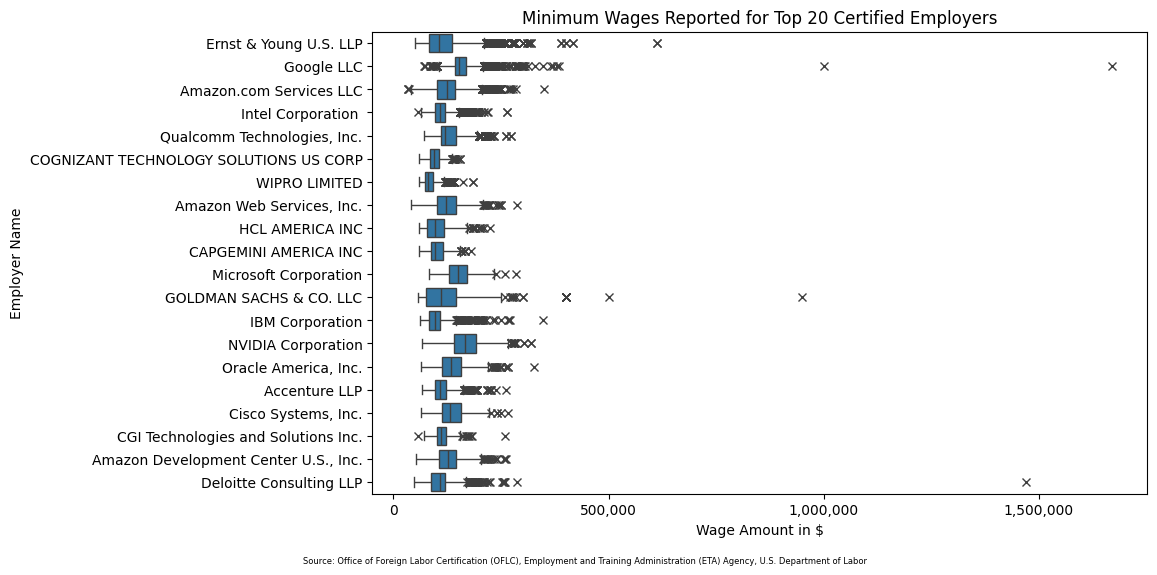

time: 571 ms (started: 2024-06-11 15:04:36 -04:00)


In [71]:
# Let's create a boxplot that shows the distribution of the prevailing wages for each of the top 30 employers
fig, ax = plt.subplots(figsize=(10, 6))
sns.boxplot(x='WAGE_RATE_OF_PAY_FROM', y='EMPLOYER_NAME', 
            data=certified_h1b_year, order=certified_h1b_year['EMPLOYER_NAME'].value_counts()[0:20].index, 
            ax=ax,
            flierprops={"marker": "x"});
ax.set_title('Minimum Wages Reported for Top 20 Certified Employers');
ax.set_xlabel('Wage Amount in $');
ax.set_xticks(np.arange(0, 2000000, 500000));
ax.set_ylabel('Employer Name');
ax.xaxis.set_major_formatter('{:,.0f}'.format)
ax.annotate(text='Source: Office of Foreign Labor Certification (OFLC), Employment and Training Administration (ETA) Agency, U.S. Department of Labor', xy=(0,0), xytext=(-50,-50), fontsize=6, 
             xycoords='axes fraction', textcoords='offset points');


In [72]:
certified_h1b_year[certified_h1b_year['WAGE_RATE_OF_PAY_FROM'] > 1000000]

CASE_NUMBER CASE_STATUS RECEIVED_DATE DECISION_DATE  \
35714   I-200-23244-315046   Certified    2023-09-01    2023-09-11   
53836   I-200-23234-283945   Certified    2023-08-22    2023-08-29   
72067   I-200-23221-252505   Certified    2023-08-09    2023-08-16   
72449   I-200-23221-252410   Certified    2023-08-09    2023-08-16   
213723  I-200-23132-017338   Certified    2023-05-12    2023-05-19   
244643  I-200-23118-977580   Certified    2023-04-28    2023-05-05   
279194  I-200-23103-930504   Certified    2023-04-13    2023-04-20   
367267  I-200-23054-798940   Certified    2023-02-23    2023-03-02   
382020  I-200-23047-781239   Certified    2023-02-16    2023-02-23   
388199  I-200-23044-768555   Certified    2023-02-13    2023-02-20   

       ORIGINAL_CERT_DATE VISA_CLASS  \
35714                 NaT       H-1B   
53836                 NaT       H-1B   
72067                 NaT       H-1B   
72449                 NaT       H-1B   
213723                NaT       H-1B   
244643                NaT       H-1B   
279194                NaT       H-1B   
367267                NaT       H-1B   
382020                NaT       H-1B   
388199                NaT       H-1B   

                                                JOB_TITLE    SOC_CODE  \
35714                                     Product Manager  13-1082.00   
53836                       Senior Front-End Web Engineer  15-1255.00   
72067                                  Software Developer  15-1252.00   
72449                                  SOFTWARE DEVELOPER  15-1252.00   
213723                                  Senior Consultant  15-1252.00   
244643  (AD) Latin America Debt Capital Markets Builde...  13-2099.00   
279194                                  Software Engineer  15-1252.00   
367267                                  Software Engineer  15-1252.00   
382020              Venture Partner and Head of Oncology   11-1011.00   
388199                         Family Medicine Physician   29-1215.00   

                                  SOC_TITLE FULL_TIME_POSITION BEGIN_DATE  \
35714        Project Management Specialists                  Y 2023-10-01   
53836   Web and Digital Interface Designers                  Y 2023-10-01   
72067                   Software Developers                  Y 2023-08-21   
72449                   Software Developers                  Y 2023-10-01   
213723                  Software Developers                  Y 2023-10-01   
244643     Financial Specialists, All Other                  Y 2023-10-01   
279194                  Software Developers                  Y 2023-10-01   
367267                  Software Developers                  Y 2023-08-18   
382020                     Chief Executives                  Y 2023-05-02   
388199           Family Medicine Physicians                  Y 2023-07-01   

         END_DATE  TOTAL_WORKER_POSITIONS  NEW_EMPLOYMENT  \
35714  2026-09-30                       1               1   
53836  2026-09-30                       1               1   
72067  2026-08-20                       1               1   
72449  2026-09-30                       1               1   
213723 2026-09-30                       1               1   
244643 2026-09-30                       1               1   
279194 2026-09-30                       1               1   
367267 2026-08-17                       1               1   
382020 2026-05-01                       1               1   
388199 2026-06-30                       1               1   

        CONTINUED_EMPLOYMENT  CHANGE_PREVIOUS_EMPLOYMENT  \
35714                      0                           0   
53836                      0                           0   
72067                      0                           0   
72449                      0                           0   
213723                     0                           0   
244643                     0                           0   
279194                     0                           0   

time: 382 ms (started: 2024-06-11 15:04:37 -04:00)


In [73]:
# # Let's plot 4 histograms of the prevailing wage for the top 4 employers
# fig, ax = plt.subplots(2, 2, figsize=(12, 12))
# fig.suptitle('Histograms of Prevailing Wage for Top 4 Employers', fontsize=16)
# for i in range(4):
#     sns.histplot(certified_h1b_year[certified_h1b_year['EMPLOYER_NAME'] == certified_h1b_year['EMPLOYER_NAME'].value_counts().index[i]]['PREVAILING_WAGE'], 
#                  bins=50, stat='percent', kde=True, ax=ax[i//2, i%2]);
#     ax[i//2, i%2].set_title(f'{certified_h1b_year["EMPLOYER_NAME"].value_counts().index[i]}');
#     ax[i//2, i%2].set_xlabel('Prevailing Wage in $');
#     ax[i//2, i%2].set_ylabel('Frequency');
#     ax[i//2, i%2].set_xticks(np.arange(0, 300000, 50000));

time: 586 µs (started: 2024-06-11 15:04:37 -04:00)


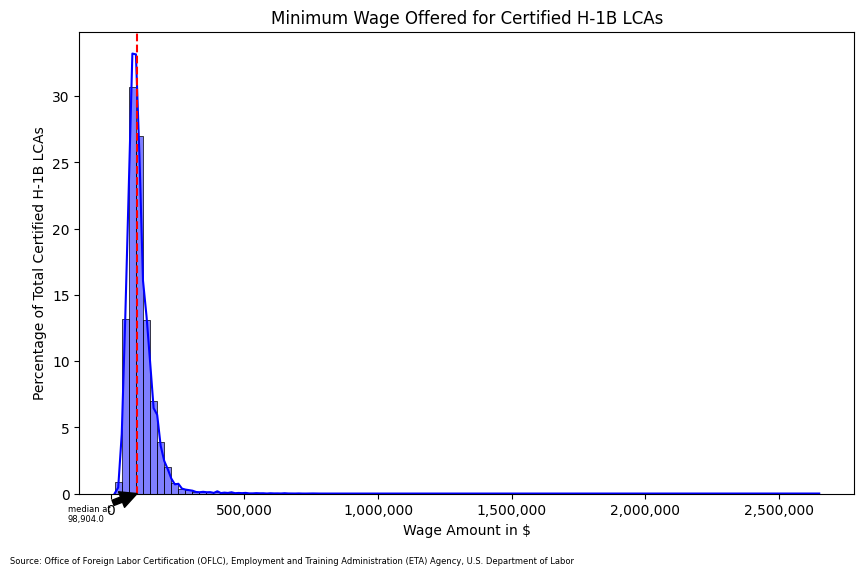

time: 813 ms (started: 2024-06-11 15:28:19 -04:00)


In [173]:
# Let's use the seaborn library to create a histogram of the PREVAILING_WAGE values
fig, ax = plt.subplots(figsize=(10, 6))
sns.histplot(certified_h1b_year, x='WAGE_RATE_OF_PAY_FROM', stat='percent', bins=100, color='blue', ax=ax, kde=True);
ax.set_title('Minimum Wage Offered for Certified H-1B LCAs');
ax.set_xlabel('Wage Amount in $');
ax.set_ylabel('Percentage of Total Certified H-1B LCAs');
ax.xaxis.set_major_formatter('{:,.0f}'.format);
ax.set_xticks(np.arange(0, 3000000, 500000));
ax.annotate(text='Source: Office of Foreign Labor Certification (OFLC), Employment and Training Administration (ETA) Agency, U.S. Department of Labor', xy=(0,0), xytext=(-50,-50), fontsize=6, 
             xycoords='axes fraction', textcoords='offset points');
ax.annotate(text=f'median at\n{certified_h1b_year['WAGE_RATE_OF_PAY_FROM'].median():,}', xy=(certified_h1b_year['WAGE_RATE_OF_PAY_FROM'].median(), 0), xytext=(-50,-20), arrowprops=dict(color='black'), fontsize=6, 
             xycoords='data', textcoords='offset points');
plt.axvline(x=certified_h1b_year['WAGE_RATE_OF_PAY_FROM'].median(), color='red', linestyle='--');


In [77]:
# using the NAICS code, let's find out which employers were colleges and universities
colleges_and_universities = certified_h1b_year[certified_h1b_year['NAICS_CODE'] == 611310]
colleges_and_universities.info()

<class 'pandas.core.frame.DataFrame'>
Index: 12235 entries, 203 to 632120
Data columns (total 96 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   CASE_NUMBER                     12235 non-null  object        
 1   CASE_STATUS                     12235 non-null  object        
 2   RECEIVED_DATE                   12235 non-null  datetime64[ns]
 3   DECISION_DATE                   12235 non-null  datetime64[ns]
 4   ORIGINAL_CERT_DATE              0 non-null      datetime64[ns]
 5   VISA_CLASS                      12235 non-null  object        
 6   JOB_TITLE                       12235 non-null  object        
 7   SOC_CODE                        12235 non-null  object        
 8   SOC_TITLE                       12235 non-null  object        
 9   FULL_TIME_POSITION              12235 non-null  object        
 10  BEGIN_DATE                      12235 non-null  datetime64[ns]
 11  END_

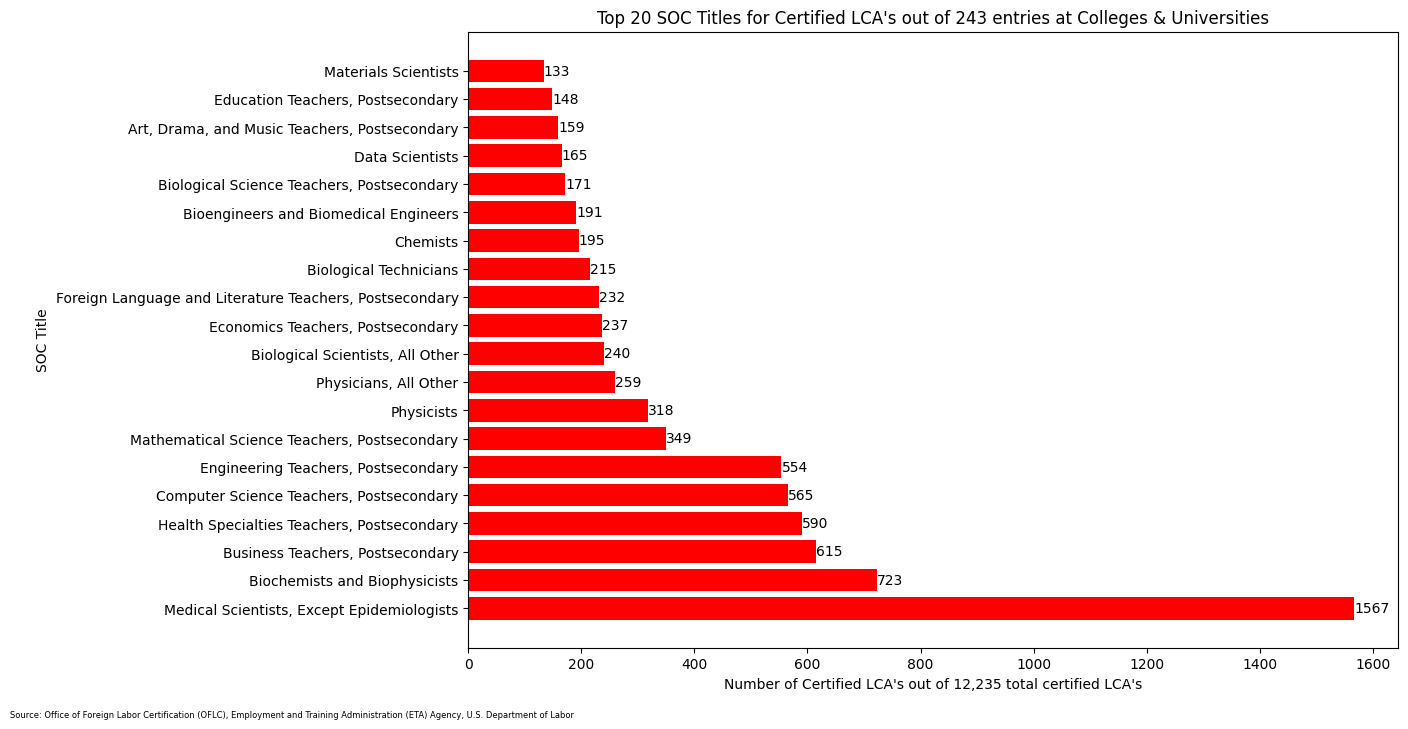

time: 516 ms (started: 2024-06-11 15:04:38 -04:00)


In [78]:
# let's plot a bar graph of the different SOC titles that appear in the dataset for certified H-1B LCA's for all employers
fig, ax = plt.subplots(figsize=(12, 8))
ax.barh(colleges_and_universities['SOC_TITLE'].value_counts()[0:20].index, colleges_and_universities['SOC_TITLE'].value_counts()[0:20].values, color='red');
ax.bar_label(ax.containers[0]);
ax.set_title(f'Top 20 SOC Titles for Certified LCA\'s out of {colleges_and_universities['SOC_TITLE'].nunique():,} entries at Colleges & Universities');
ax.set_ylabel('SOC Title');
ax.set_xlabel(f'Number of Certified LCA\'s out of {colleges_and_universities.shape[0]:,} total certified LCA\'s');
ax.annotate(text='Source: Office of Foreign Labor Certification (OFLC), Employment and Training Administration (ETA) Agency, U.S. Department of Labor', xy=(0,0), xytext=(-330,-50), fontsize=6, 
             xycoords='axes fraction', textcoords='offset points');


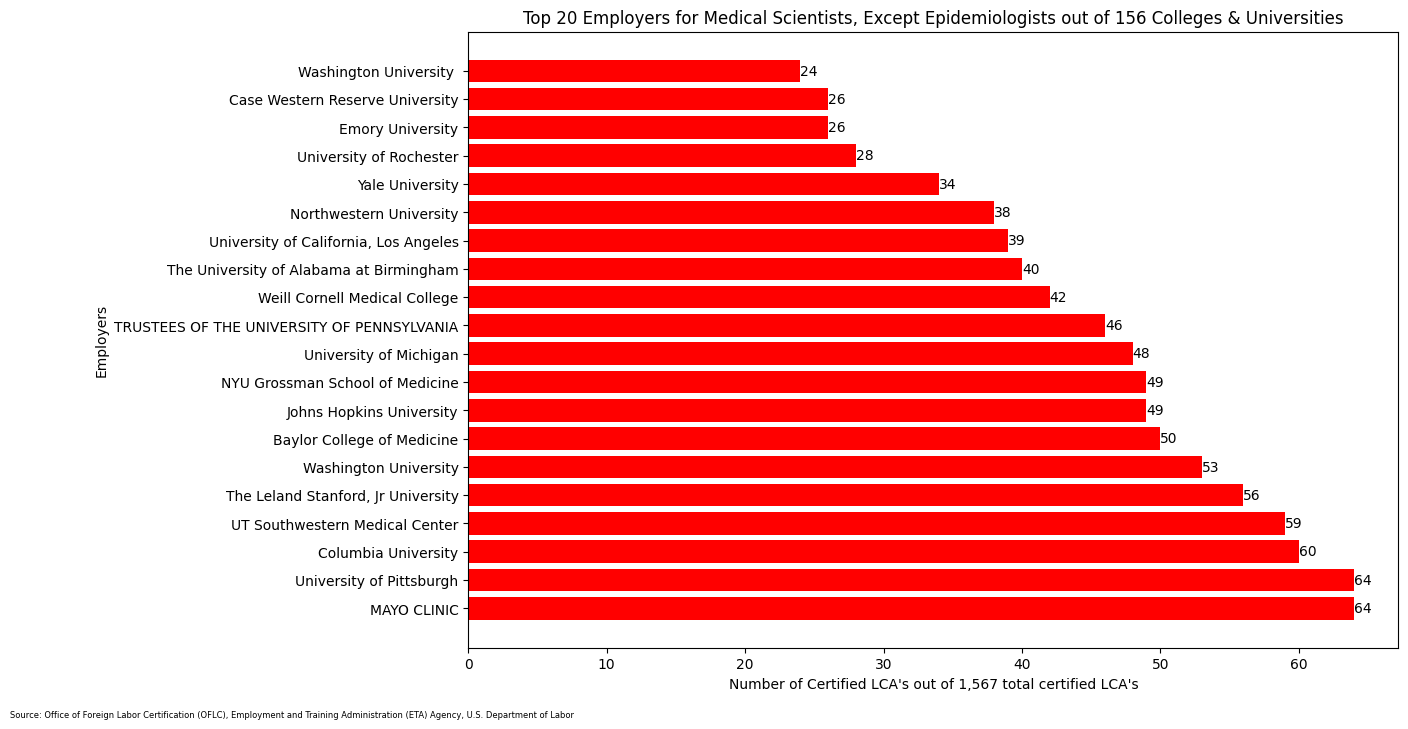

time: 641 ms (started: 2024-06-11 15:04:39 -04:00)


In [79]:
# let's plot a bar graph of the different SOC titles that appear in the dataset for certified H-1B LCA's for all employers at colleges and universities
fig, ax = plt.subplots(figsize=(12, 8))
ax.barh(colleges_and_universities[colleges_and_universities['SOC_TITLE'] == 'Medical Scientists, Except Epidemiologists']['EMPLOYER_NAME'].value_counts()[0:20].index,
        colleges_and_universities[colleges_and_universities['SOC_TITLE'] == 'Medical Scientists, Except Epidemiologists']['EMPLOYER_NAME'].value_counts()[0:20].values, 
        color='red');
ax.bar_label(ax.containers[0]);
ax.set_title(f'Top 20 Employers for Medical Scientists, Except Epidemiologists out of {colleges_and_universities[colleges_and_universities['SOC_TITLE'] == 'Medical Scientists, Except Epidemiologists']['EMPLOYER_NAME'].nunique():,} Colleges & Universities');
ax.set_ylabel('Employers');
ax.set_xlabel(f'Number of Certified LCA\'s out of {colleges_and_universities[colleges_and_universities['SOC_TITLE'] == 'Medical Scientists, Except Epidemiologists'].shape[0]:,} total certified LCA\'s');
ax.annotate(text='Source: Office of Foreign Labor Certification (OFLC), Employment and Training Administration (ETA) Agency, U.S. Department of Labor', xy=(0,0), xytext=(-330,-50), fontsize=6, 
             xycoords='axes fraction', textcoords='offset points');


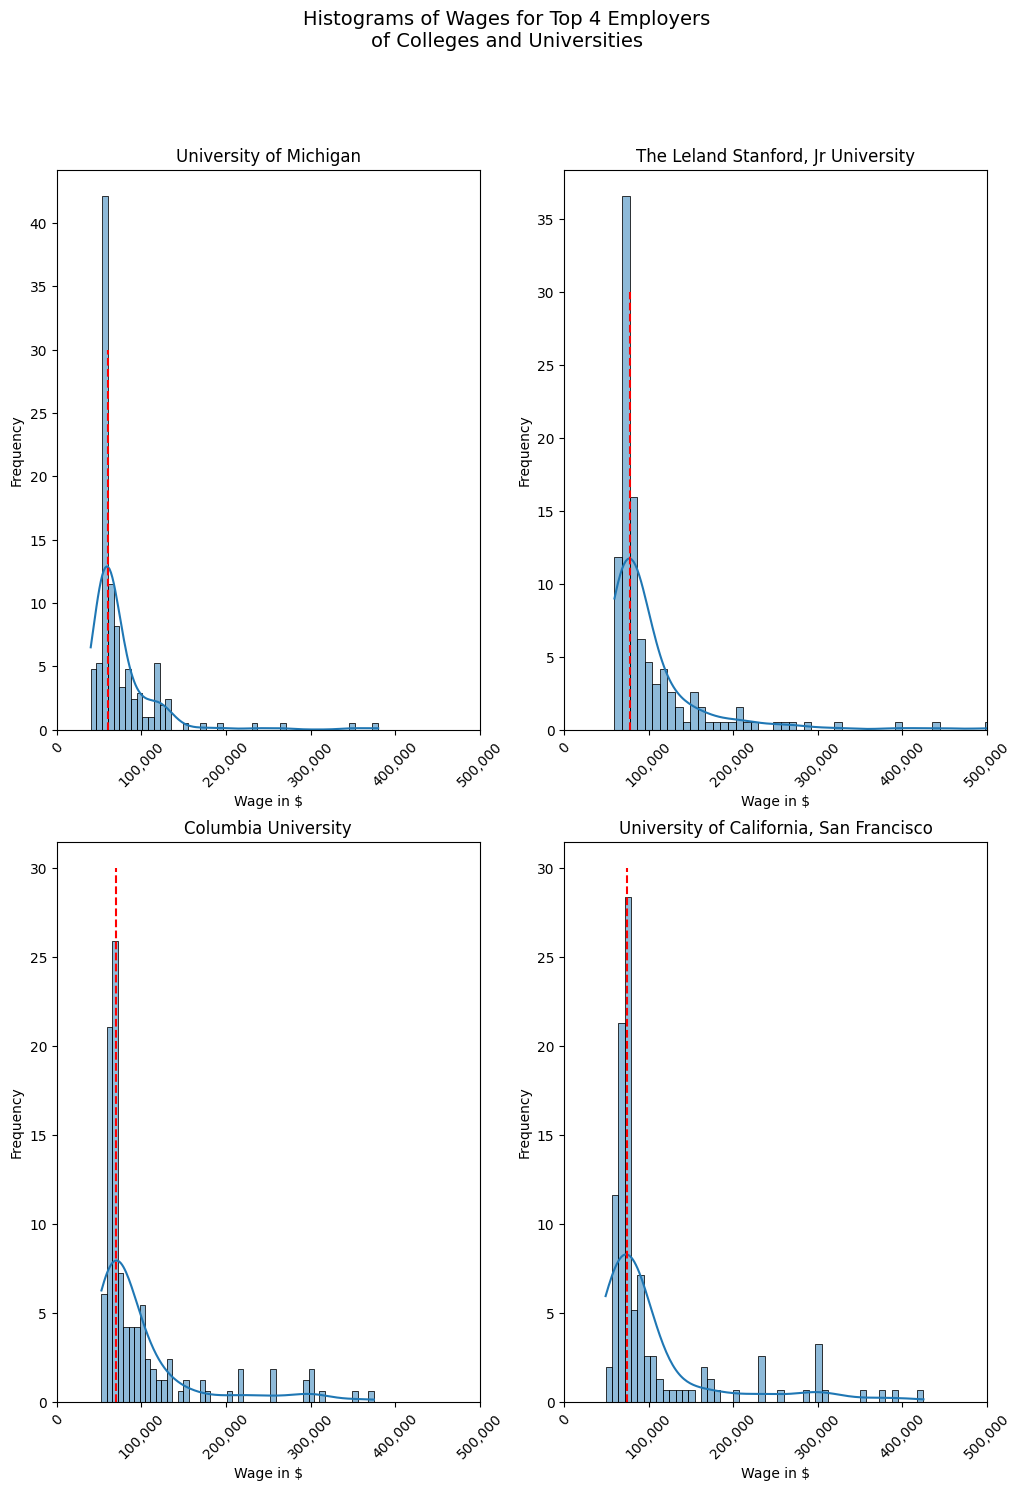

time: 1.31 s (started: 2024-06-11 15:04:40 -04:00)


In [80]:
# Let's plot 4 histograms of the prevailing wage for the top 4 employers at colleges and universities
fig, ax = plt.subplots(2, 2, figsize=(12, 16))
fig.suptitle('Histograms of Wages for Top 4 Employers\nof Colleges and Universities', fontsize=14)
for i in range(4):
    sns.histplot(colleges_and_universities[colleges_and_universities['EMPLOYER_NAME'] == colleges_and_universities['EMPLOYER_NAME'].value_counts().index[i]]['WAGE_RATE_OF_PAY_FROM'], # type: ignore
                 bins=50, stat='percent', kde=True, ax=ax[i//2, i%2]);
    ax[i//2, i%2].set_title(f'{colleges_and_universities["EMPLOYER_NAME"].value_counts().index[i]}');
    ax[i//2, i%2].set_xlabel('Wage in $');
    ax[i//2, i%2].tick_params(axis='x', rotation=45);
    ax[i//2, i%2].set_ylabel('Frequency');
    ax[i//2, i%2].vlines(x=colleges_and_universities[colleges_and_universities['EMPLOYER_NAME'] == colleges_and_universities['EMPLOYER_NAME'].value_counts().index[i]]['WAGE_RATE_OF_PAY_FROM'].median(), ymin=0, ymax=30, color='red', linestyle='--');
    ax[i//2, i%2].set_xlim(0, 500000);
    ax[i//2, i%2].set_xticks(np.arange(0, 600000, 100000));
    ax[i//2, i%2].xaxis.set_major_formatter('{x:,.0f}');

In [81]:
colleges_and_universities[colleges_and_universities['SOC_TITLE'] == 'Software Developers'].shape

(51, 96)

time: 8.76 ms (started: 2024-06-11 15:04:41 -04:00)


In [82]:
certified_h1b[certified_h1b['SOC_TITLE'] == 'Medical Scientists, Except Epidemiologists'].shape

(2626, 96)

time: 59.2 ms (started: 2024-06-11 15:04:41 -04:00)


In [83]:
certified_h1b[certified_h1b['SOC_TITLE'] == 'Software Developers'].shape

(48642, 96)

time: 122 ms (started: 2024-06-11 15:04:41 -04:00)


In [84]:
# let's dig deeper into the Mathematical Science Teachers, Postsecondary entries
colleges_and_universities[colleges_and_universities['SOC_TITLE'] == 'Mathematical Science Teachers, Postsecondary'].info()

<class 'pandas.core.frame.DataFrame'>
Index: 349 entries, 3019 to 547956
Data columns (total 96 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   CASE_NUMBER                     349 non-null    object        
 1   CASE_STATUS                     349 non-null    object        
 2   RECEIVED_DATE                   349 non-null    datetime64[ns]
 3   DECISION_DATE                   349 non-null    datetime64[ns]
 4   ORIGINAL_CERT_DATE              0 non-null      datetime64[ns]
 5   VISA_CLASS                      349 non-null    object        
 6   JOB_TITLE                       349 non-null    object        
 7   SOC_CODE                        349 non-null    object        
 8   SOC_TITLE                       349 non-null    object        
 9   FULL_TIME_POSITION              349 non-null    object        
 10  BEGIN_DATE                      349 non-null    datetime64[ns]
 11  END_D

In [85]:
# let's dig deeper into the Mathematical Science Teachers, Postsecondary entries
colleges_and_universities[colleges_and_universities['SOC_TITLE'] == 'Mathematical Science Teachers, Postsecondary']['EMPLOYER_NAME'].value_counts()

EMPLOYER_NAME
MICHIGAN STATE UNIVERSITY                  11
The Ohio State University                   7
Arizona State University                    6
University of Notre Dame du Lac             6
Columbia University                         5
                                           ..
THE TRUSTEES OF PRINCETON UNIVERSITY        1
STATE UNIVERSITY OF NEW YORK AT BUFFALO     1
Rose-Hulman Institute of Technology         1
University of Arkansas at Little Rock       1
Tennessee Technological University          1
Name: count, Length: 197, dtype: int64

time: 13.1 ms (started: 2024-06-11 15:04:41 -04:00)


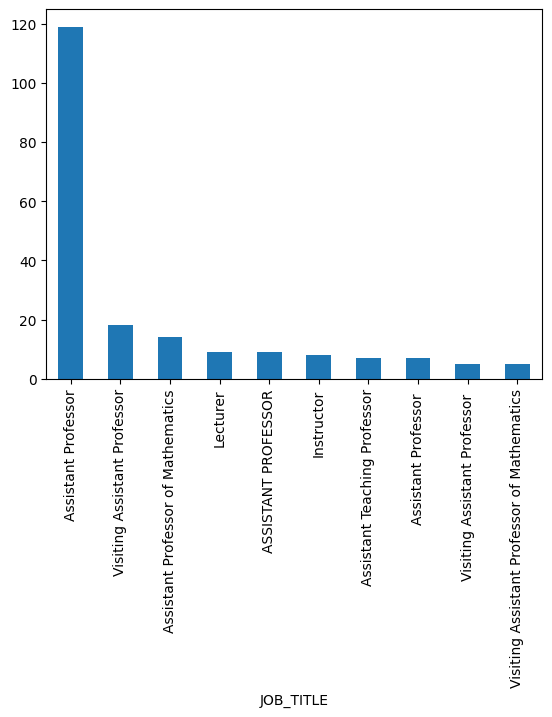

time: 326 ms (started: 2024-06-11 15:04:41 -04:00)


In [86]:
colleges_and_universities[colleges_and_universities['SOC_TITLE'] == 'Mathematical Science Teachers, Postsecondary']['JOB_TITLE'].value_counts()[0:10].plot(kind='bar');

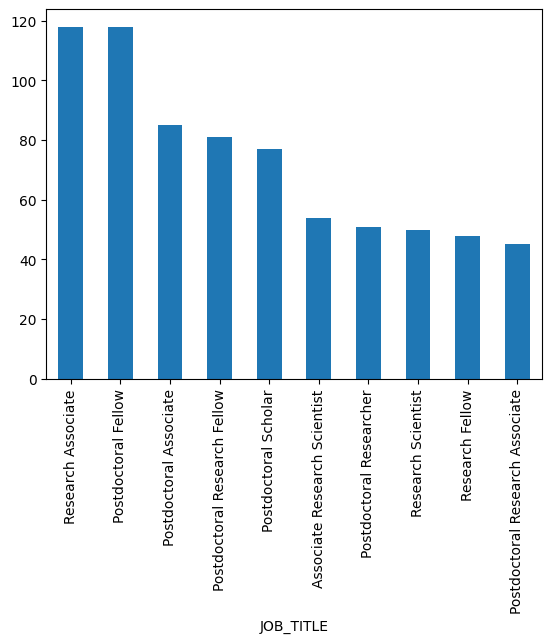

time: 231 ms (started: 2024-06-11 15:04:42 -04:00)


In [87]:
colleges_and_universities[colleges_and_universities['SOC_TITLE'] == 'Medical Scientists, Except Epidemiologists']['JOB_TITLE'].value_counts()[0:10].plot(kind='bar');

In [88]:
colleges_and_universities[colleges_and_universities['SOC_TITLE'] == 'Medical Scientists, Except Epidemiologists']['JOB_TITLE'].value_counts()[0:10]

JOB_TITLE
Research Associate                 118
Postdoctoral Fellow                118
Postdoctoral Associate              85
Postdoctoral Research Fellow        81
Postdoctoral Scholar                77
Associate Research Scientist        54
Postdoctoral Researcher             51
Research Scientist                  50
Research Fellow                     48
Postdoctoral Research Associate     45
Name: count, dtype: int64

time: 13.3 ms (started: 2024-06-11 15:04:42 -04:00)


In [89]:
occupations = ['Business Teachers', 'Foreign Language and Literature Teachers, Postsecondary', 'Art, Drama, And Music Teachers, Postsecondary', 'Economics Teachers, Postsecondary']
non_stem_colleges = colleges_and_universities[colleges_and_universities['SOC_TITLE'].isin(occupations)]
non_stem_colleges['EMPLOYER_NAME'].value_counts()

EMPLOYER_NAME
Harvard University                             13
Columbia University                            12
The Ohio State University                       8
University of Illinois                          7
Bard College                                    7
                                               ..
St. Francis College                             1
Allegheny College                               1
RANDOLPH-MACON COLLEGE                          1
Dominican University                            1
California State University, San Bernardino     1
Name: count, Length: 227, dtype: int64

time: 11.1 ms (started: 2024-06-11 15:04:42 -04:00)


In [90]:
colleges_and_universities[(colleges_and_universities['EMPLOYER_NAME'] == non_stem_colleges['EMPLOYER_NAME'].value_counts().index[0]) & (colleges_and_universities['SOC_TITLE'].isin(occupations))]

CASE_NUMBER CASE_STATUS RECEIVED_DATE DECISION_DATE  \
119421  I-200-23181-160938   Certified    2023-06-30    2023-07-10   
158639  I-200-23160-094683   Certified    2023-06-09    2023-06-16   
289338  I-200-23097-914580   Certified    2023-04-07    2023-04-14   
320899  I-200-23081-868881   Certified    2023-03-22    2023-03-29   
375295  I-200-23052-790505   Certified    2023-02-21    2023-02-28   
375442  I-200-23052-790523   Certified    2023-02-21    2023-02-28   
381360  I-200-23047-779521   Certified    2023-02-16    2023-02-23   
383561  I-200-23046-776104   Certified    2023-02-15    2023-02-22   
402900  I-200-23033-746635   Certified    2023-02-02    2023-02-09   
428556  I-200-23013-701897   Certified    2023-01-13    2023-01-20   
440273  I-200-23004-681544   Certified    2023-01-04    2023-01-11   
440409  I-200-23004-681566   Certified    2023-01-04    2023-01-11   
535904  I-200-22277-508651   Certified    2022-10-04    2022-10-12   

       ORIGINAL_CERT_DATE VISA_CLASS                      JOB_TITLE  \
119421                NaT       H-1B                       Lecturer   
158639                NaT       H-1B                Research Fellow   
289338                NaT       H-1B            Assistant Professor   
320899                NaT       H-1B  Preceptor in Russian Language   
375295                NaT       H-1B                      Preceptor   
375442                NaT       H-1B                      Preceptor   
381360                NaT       H-1B                      Preceptor   
383561                NaT       H-1B                      Preceptor   
402900                NaT       H-1B                      Preceptor   
428556                NaT       H-1B    Preceptor in Modern Turkish   
440273                NaT       H-1B                       Lecturer   
440409                NaT       H-1B            Postdoctoral Fellow   
535904                NaT       H-1B  Preceptor in Russian Language   

          SOC_CODE                                          SOC_TITLE  \
119421  25-1063.00                  Economics Teachers, Postsecondary   
158639  25-1063.00                  Economics Teachers, Postsecondary   
289338  25-1124.00  Foreign Language and Literature Teachers, Post...   
320899  25-1124.00  Foreign Language and Literature Teachers, Post...   
375295  25-1124.00  Foreign Language and Literature Teachers, Post...   
375442  25-1124.00  Foreign Language and Literature Teachers, Post...   
381360  25-1124.00  Foreign Language and Literature Teachers, Post...   
383561  25-1124.00  Foreign Language and Literature Teachers, Post...   
402900  25-1124.00  Foreign Language and Literature Teachers, Post...   
428556  25-1124.00  Foreign Language and Literature Teachers, Post...   
440273  25-1124.00  Foreign Language and Literature Teachers, Post...   
440409  25-1124.00  Foreign Language and Literature Teachers, Post...   
535904  25-1124.00  Foreign Language and Literature Teachers, Post...   

       FULL_TIME_POSITION BEGIN_DATE   END_DATE  TOTAL_WORKER_POSITIONS  \
119421                  Y 2023-07-01 2024-06-30                       1   
158639                  Y 2023-07-01 2024-06-30                       1   
289338                  Y 2023-07-01 2026-06-30                       1   
320899                  Y 2023-07-01 2026-06-30                       1   
375295                  Y 2023-08-20 2026-06-30                       1   
375442                  Y 2023-08-20 2026-06-30                       1   
381360                  Y 2023-08-16 2026-08-15                       1   
383561                  Y 2023-08-15 2026-06-30                       1   
402900                  Y 2023-08-01 2026-07-31                       1   
428556                  Y 2023-07-01 2026-06-30                       1   
440273                  Y 2023-07-01 2024-06-30                       1   
440409                  Y 2023-07-01 2026-06-30                       1   
535904                  Y 2023-04-01 2026

time: 88.6 ms (started: 2024-06-11 15:04:42 -04:00)


In [91]:
certified_h1b_year[certified_h1b_year['NAICS_CODE'] == 611310]['EMPLOYER_NAME'].unique()

array(['University of Kentucky',
       'Administrators of the Tulane Educational Fund',
       'University of Georgia; OGE', ..., 'UNIVERSITY OF WEST ALABAMA',
       'Erikson Institute', 'Hillsdale College'], dtype=object)

time: 31.8 ms (started: 2024-06-11 15:04:42 -04:00)


In [92]:
dir(colleges_and_universities['EMPLOYER_NAME'].unique())

['T',
 '__abs__',
 '__add__',
 '__and__',
 '__array__',
 '__array_finalize__',
 '__array_function__',
 '__array_interface__',
 '__array_prepare__',
 '__array_priority__',
 '__array_struct__',
 '__array_ufunc__',
 '__array_wrap__',
 '__bool__',
 '__buffer__',
 '__class__',
 '__class_getitem__',
 '__complex__',
 '__contains__',
 '__copy__',
 '__deepcopy__',
 '__delattr__',
 '__delitem__',
 '__dir__',
 '__divmod__',
 '__dlpack__',
 '__dlpack_device__',
 '__doc__',
 '__eq__',
 '__float__',
 '__floordiv__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__iadd__',
 '__iand__',
 '__ifloordiv__',
 '__ilshift__',
 '__imatmul__',
 '__imod__',
 '__imul__',
 '__index__',
 '__init__',
 '__init_subclass__',
 '__int__',
 '__invert__',
 '__ior__',
 '__ipow__',
 '__irshift__',
 '__isub__',
 '__iter__',
 '__itruediv__',
 '__ixor__',
 '__le__',
 '__len__',
 '__lshift__',
 '__lt__',
 '__matmul__',
 '__mod__',
 '__mul__',
 '__ne__',
 '__neg__',
 '

time: 18.2 ms (started: 2024-06-11 15:04:42 -04:00)


In [93]:
colleges_and_universities['EMPLOYER_NAME'].unique().__len__()

1084

time: 12.2 ms (started: 2024-06-11 15:04:42 -04:00)


In [94]:
colleges_and_universities['EMPLOYER_NAME'].unique().size

1084

time: 4.38 ms (started: 2024-06-11 15:04:42 -04:00)


In [95]:
colleges_and_universities['JOB_TITLE'].value_counts()

JOB_TITLE
Assistant Professor                                      2014
Postdoctoral Fellow                                       387
Research Associate                                        334
Postdoctoral Scholar                                      289
Postdoctoral Research Associate                           288
                                                         ... 
Clinical Ethics Fellow                                      1
Assistant Professor of Educational Technology               1
Pulmonary, Critical Care and Sleep Medicine Physician       1
Career-Line Faculty                                         1
Research Engineering/Research Associate III                 1
Name: count, Length: 3432, dtype: int64

time: 7.61 ms (started: 2024-06-11 15:04:42 -04:00)


In [96]:
colleges_and_universities['EMPLOYER_NAME'].value_counts()

EMPLOYER_NAME
University of Michigan                        209
The Leland Stanford, Jr University            194
Columbia University                           166
University of California, San Francisco       155
TRUSTEES OF THE UNIVERSITY OF PENNSYLVANIA    151
                                             ... 
University of Texas at Alrington                1
The College of New Jersey                       1
Southern Adventist University                   1
University of Central Oklahoma                  1
Hillsdale College                               1
Name: count, Length: 1084, dtype: int64

time: 20.3 ms (started: 2024-06-11 15:04:42 -04:00)


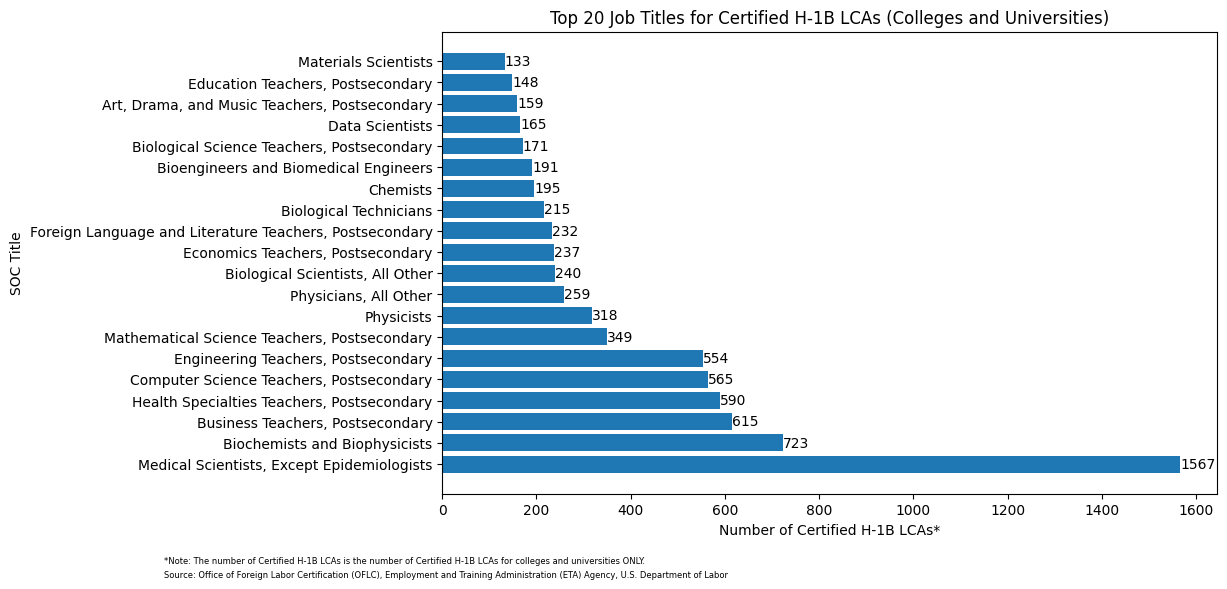

time: 708 ms (started: 2024-06-11 15:04:42 -04:00)


In [97]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.barh(colleges_and_universities['SOC_TITLE'].value_counts()[0:20].index, colleges_and_universities['SOC_TITLE'].value_counts()[0:20].values);
ax.bar_label(ax.containers[0]);
ax.title.set_text('Top 20 Job Titles for Certified H-1B LCAs (Colleges and Universities)');
ax.set_ylabel('SOC Title');
ax.set_xlabel(f'Number of Certified H-1B LCAs*');
ax.annotate(text=f'*Note: The number of Certified H-1B LCAs is the number of Certified H-1B LCAs for colleges and universities ONLY.', xy=(0,0), xytext=(-200,-50), fontsize=6, 
             xycoords='axes fraction', textcoords='offset points');
ax.annotate(text='Source: Office of Foreign Labor Certification (OFLC), Employment and Training Administration (ETA) Agency, U.S. Department of Labor', xy=(0,0), xytext=(-200,-60), fontsize=6, 
             xycoords='axes fraction', textcoords='offset points');

In [98]:
# let's see what the different job titles were for each given employer in the colleges_and_universities data frame
colleges_and_universities.groupby('EMPLOYER_NAME')['JOB_TITLE'].value_counts().sort_values(ascending=False)

EMPLOYER_NAME                            JOB_TITLE                                   
University of Michigan                   Postdoctoral Research Fellow                    94
University of California, San Francisco  Postdoctoral Scholar                            72
The Leland Stanford, Jr University       Postdoctoral Research Affiliate                 64
MAYO CLINIC                              Research Fellow                                 46
The Trustees of Princeton University     Postdoctoral Research Associate                 41
                                                                                         ..
Pitzer College                           Assistant Professor of Economics                 1
Pitt Community College                   Director of Application Development              1
Philadelphia University                  Curriculum & Instructional Design Specialist     1
Paul Smith's College                     Assistant Professor in Conservation Biology  

time: 33.9 ms (started: 2024-06-11 15:04:43 -04:00)


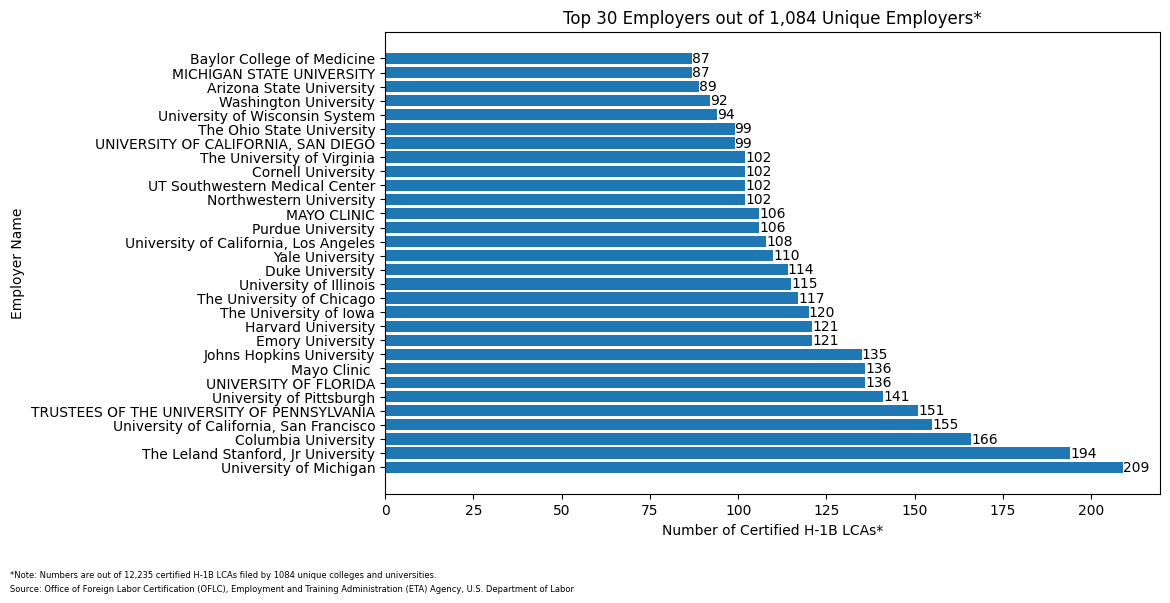

time: 745 ms (started: 2024-06-11 15:04:43 -04:00)


In [99]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.barh(colleges_and_universities['EMPLOYER_NAME'].value_counts()[0:30].index, colleges_and_universities['EMPLOYER_NAME'].value_counts()[0:30].values);
ax.bar_label(ax.containers[0]);
ax.title.set_text(f'Top 30 Employers out of {colleges_and_universities['EMPLOYER_NAME'].nunique():,} Unique Employers*');
ax.set_ylabel('Employer Name');
ax.set_xlabel(f'Number of Certified H-1B LCAs*');
ax.annotate(text=f'*Note: Numbers are out of {colleges_and_universities.shape[0]:,} certified H-1B LCAs filed by {colleges_and_universities['EMPLOYER_NAME'].unique().size} unique colleges and universities.', xy=(0,0), xytext=(-270,-60), fontsize=6, 
             xycoords='axes fraction', textcoords='offset points');
ax.annotate(text='Source: Office of Foreign Labor Certification (OFLC), Employment and Training Administration (ETA) Agency, U.S. Department of Labor', xy=(0,0), xytext=(-270,-70), fontsize=6, 
             xycoords='axes fraction', textcoords='offset points');


In [100]:
type(colleges_and_universities['EMPLOYER_NAME'].unique())

numpy.ndarray

time: 11.6 ms (started: 2024-06-11 15:04:44 -04:00)


In [101]:
# let's print out a table of the unique employer names
ls = [print(x) for x in colleges_and_universities['EMPLOYER_NAME'].unique()]

University of Kentucky
Administrators of the Tulane Educational Fund
University of Georgia; OGE
Lamar University
Harvard University
Cleveland State University
Cornell University
Louisiana State University and A&M College
Bard College
University of Pittsburgh
The University of Virginia
TRUSTEES OF THE UNIVERSITY OF PENNSYLVANIA
Temple University--A Commonwealth University
University of Texas at Arlington
The University of Texas Health Science Center at Houston
WICHITA STATE UNIVERSITY
ALBANY MEDICAL COLLEGE
SOUTHERN METHODIST UNIVERSITY
Yale University
University of Minnesota
Gettysburg College
New York University
East Carolina University
University of Massachusetts Boston
The Trustees of Princeton University
University of California, Berkeley
Oregon State University
The University of Chicago
The Pennsylvania State University
Colorado Seminary
Emory University
Menlo College
Oklahoma State University
Mayo Clinic 
The University of Iowa
West Virginia University
The University of Texas at 

In [102]:
colleges_and_universities['JOB_TITLE'].value_counts()[0:20].index

Index(['Assistant Professor', 'Postdoctoral Fellow', 'Research Associate',
       'Postdoctoral Scholar', 'Postdoctoral Research Associate',
       'Postdoctoral Associate', 'Assistant Professor ',
       'Postdoctoral Research Fellow', 'Research Scientist', 'Lecturer',
       'Instructor', 'ASSISTANT PROFESSOR', 'Postdoctoral Researcher',
       'Research Assistant Professor', 'Clinical Assistant Professor',
       'Associate Research Scientist', 'Associate Professor',
       'Research Fellow', 'Postdoctoral Research Scholar',
       'Visiting Assistant Professor'],
      dtype='object', name='JOB_TITLE')

time: 17.2 ms (started: 2024-06-11 15:04:44 -04:00)


In [103]:
# let's find colleges and universities in Pennsylvania
colleges_and_universities['WORKSITE_STATE'].value_counts()

WORKSITE_STATE
CA    1262
NY    1101
TX    1031
PA     594
IL     547
      ... 
WY      16
PR      12
VI       3
GU       2
AK       1
Name: count, Length: 54, dtype: int64

time: 10.8 ms (started: 2024-06-11 15:04:44 -04:00)


In [104]:
colleges_and_universities_pa = colleges_and_universities[colleges_and_universities['WORKSITE_STATE'] == 'PA']
colleges_and_universities_pa.info()

<class 'pandas.core.frame.DataFrame'>
Index: 594 entries, 833 to 610189
Data columns (total 96 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   CASE_NUMBER                     594 non-null    object        
 1   CASE_STATUS                     594 non-null    object        
 2   RECEIVED_DATE                   594 non-null    datetime64[ns]
 3   DECISION_DATE                   594 non-null    datetime64[ns]
 4   ORIGINAL_CERT_DATE              0 non-null      datetime64[ns]
 5   VISA_CLASS                      594 non-null    object        
 6   JOB_TITLE                       594 non-null    object        
 7   SOC_CODE                        594 non-null    object        
 8   SOC_TITLE                       594 non-null    object        
 9   FULL_TIME_POSITION              594 non-null    object        
 10  BEGIN_DATE                      594 non-null    datetime64[ns]
 11  END_DA

In [105]:
colleges_and_universities_pa['EMPLOYER_NAME'].nunique()

49

time: 6.26 ms (started: 2024-06-11 15:04:44 -04:00)


In [106]:
colleges_and_universities_pa['EMPLOYER_NAME'].unique()

array(['University of Pittsburgh',
       'TRUSTEES OF THE UNIVERSITY OF PENNSYLVANIA',
       'Temple University--A Commonwealth University',
       'Gettysburg College', 'The Pennsylvania State University',
       'Carnegie Mellon University', 'Lehigh University',
       'Drexel University', 'Thomas Jefferson University',
       'Wright Center for Graduate Medical Education',
       'Mercyhurst University', 'Duquesne University',
       'Alvernia University', 'Widener University', 'Gannon University',
       'Eastern University', 'Bucknell University', 'URSINUS COLLEGE',
       'Moravian University', 'Haverford College', 'Villanova University',
       'DeSales University', 'Slippery Rock University of Pennsylvania',
       'COMMONWEALTH UNIVERSITY OF PENNSYLVANIA', 'Allegheny College',
       'Muhlenberg College', 'Temple University Hospital, Inc',
       'Arcadia University', 'Trustees of the University of Pennsylvania',
       'Allegheny College ', 'University of Rochester',
      

time: 11.5 ms (started: 2024-06-11 15:04:44 -04:00)


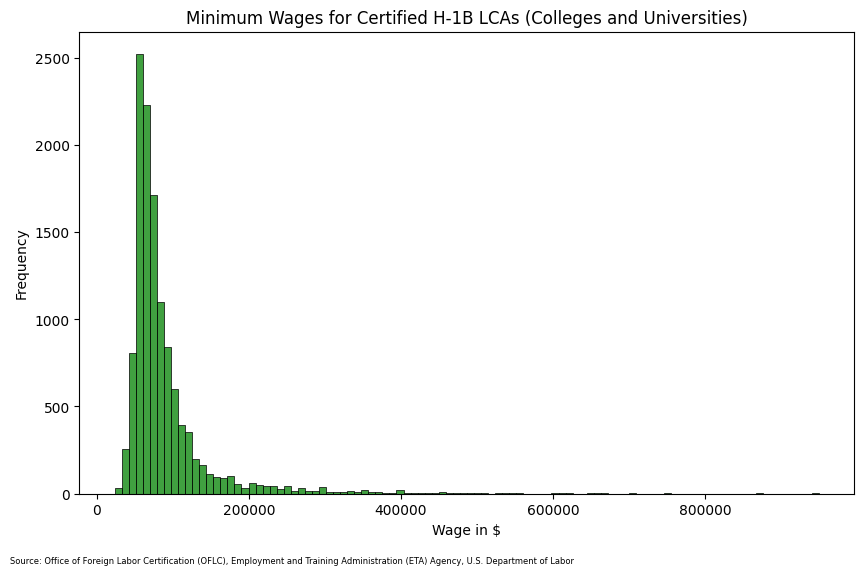

time: 798 ms (started: 2024-06-11 15:04:44 -04:00)


In [107]:
# let's use the Seaborn package to create a histogram of the PREVAILING_WAGE values for jobs at colleges and universities in Pennsylvania
fig, ax = plt.subplots(figsize=(10, 6))
sns.histplot(colleges_and_universities, x='WAGE_RATE_OF_PAY_FROM', stat='count', bins=100, color='green', ax=ax);
ax.set_title('Minimum Wages for Certified H-1B LCAs (Colleges and Universities)');
ax.set_xlabel('Wage in $');
ax.set_ylabel('Frequency');
ax.annotate(text='Source: Office of Foreign Labor Certification (OFLC), Employment and Training Administration (ETA) Agency, U.S. Department of Labor', xy=(0,0), xytext=(-50,-50), fontsize=6, 
             xycoords='axes fraction', textcoords='offset points');


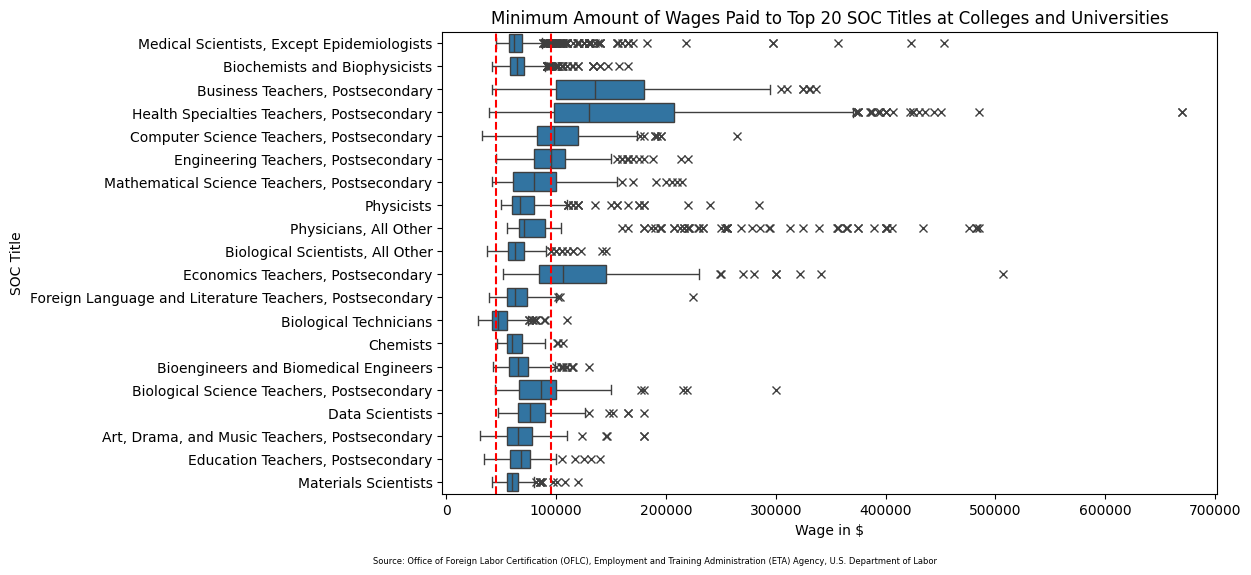

time: 709 ms (started: 2024-06-11 15:04:45 -04:00)


In [108]:
# Let's use the Seaborn package to create a boxplot of the lower bound of wage values for the top 20 jobs at colleges and universities
fig, ax = plt.subplots(figsize=(10, 6))
sns.boxplot(x='WAGE_RATE_OF_PAY_FROM', y='SOC_TITLE', 
            data=colleges_and_universities, order=colleges_and_universities['SOC_TITLE'].value_counts()[0:20].index, 
            ax=ax,
            flierprops={"marker": "x"});
ax.set_title('Minimum Amount of Wages Paid to Top 20 SOC Titles at Colleges and Universities');
ax.set_xlabel('Wage in $');
ax.set_ylabel('SOC Title');
ax.annotate(text='Source: Office of Foreign Labor Certification (OFLC), Employment and Training Administration (ETA) Agency, U.S. Department of Labor', xy=(0,0), xytext=(-50,-50), fontsize=6, 
             xycoords='axes fraction', textcoords='offset points');

plt.axvline(x=45000, color='red', linestyle='--');
plt.axvline(x=95000, color='red', linestyle='--');

## TODO: Employers

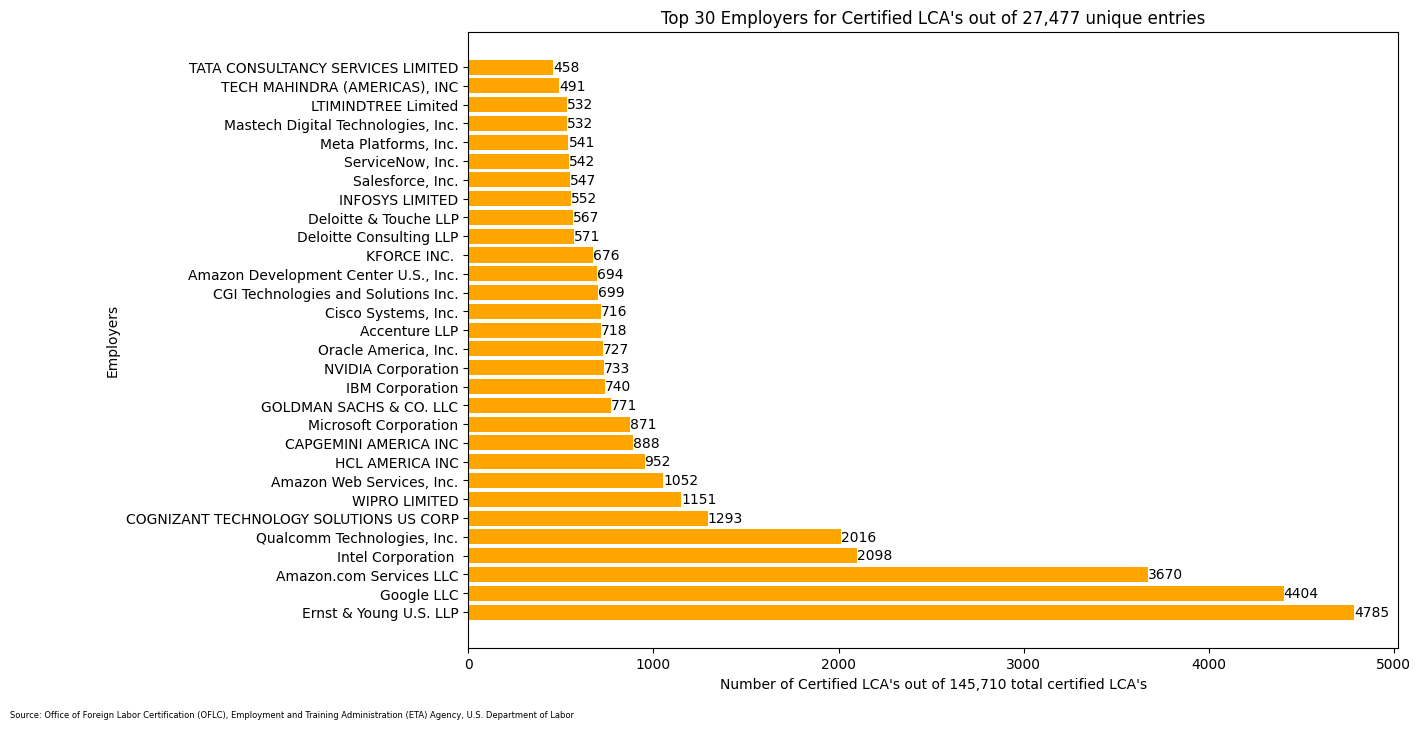

time: 808 ms (started: 2024-06-11 15:04:46 -04:00)


In [109]:
# let's plot a bar graph of the different employer names that appear in the dataset for certified H-1B LCA's for all employers
fig, ax = plt.subplots(figsize=(12, 8))
ax.barh(certified_h1b['EMPLOYER_NAME'].value_counts()[0:30].index, certified_h1b['EMPLOYER_NAME'].value_counts()[0:30].values, color='orange');
ax.bar_label(ax.containers[0]);
ax.set_title(f'Top 30 Employers for Certified LCA\'s out of {certified_h1b['EMPLOYER_NAME'].nunique():,} unique entries');
ax.set_ylabel('Employers');
ax.set_xlabel(f'Number of Certified LCA\'s out of {certified_h1b.shape[0]:,} total certified LCA\'s');
ax.annotate(text='Source: Office of Foreign Labor Certification (OFLC), Employment and Training Administration (ETA) Agency, U.S. Department of Labor', xy=(0,0), xytext=(-330,-50), fontsize=6, 
             xycoords='axes fraction', textcoords='offset points');

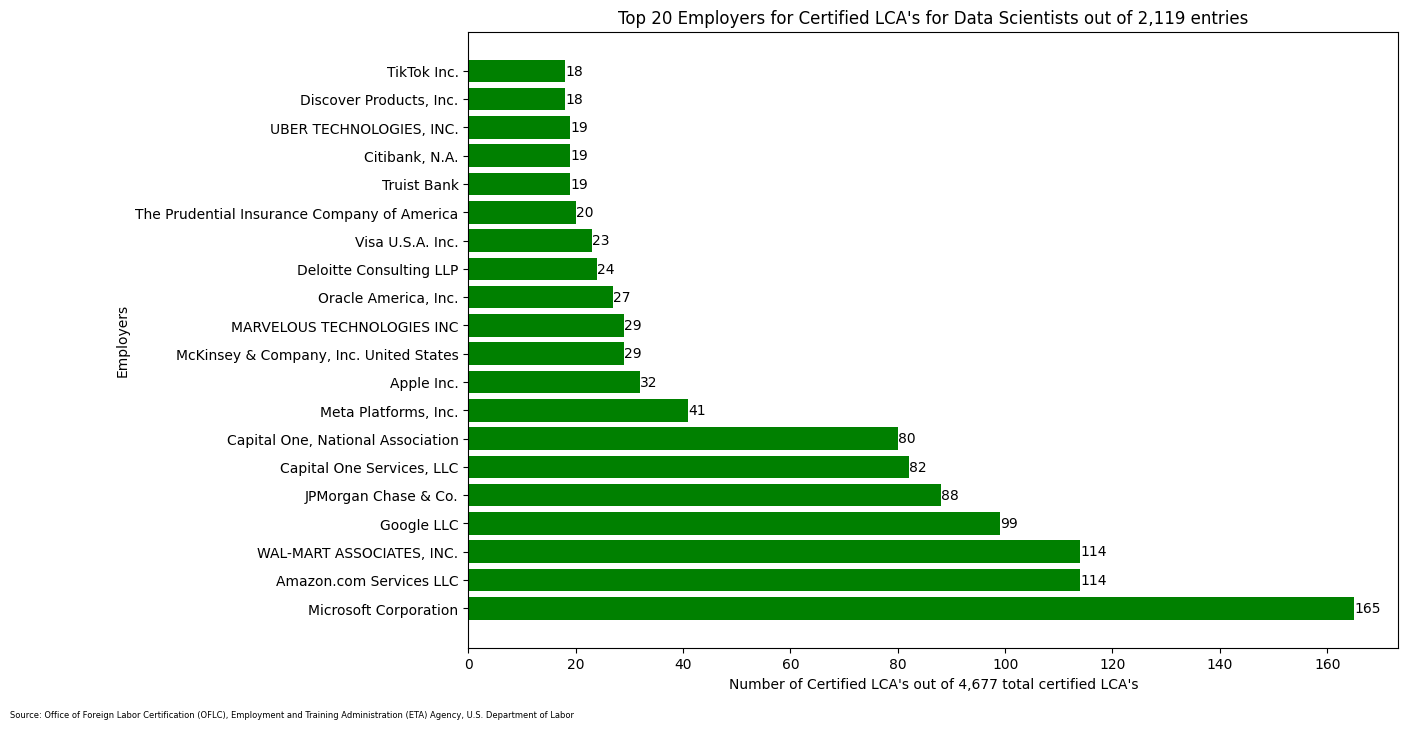

time: 677 ms (started: 2024-06-11 15:04:46 -04:00)


In [110]:
# Let's plot a bar graph that displays the top 20 employers for the SOC title "Data Scientists"
fig, ax = plt.subplots(figsize=(12, 8))
ax.barh(certified_h1b[certified_h1b['SOC_TITLE'] == 'Data Scientists']['EMPLOYER_NAME'].value_counts()[0:20].index, 
        certified_h1b[certified_h1b['SOC_TITLE'] == 'Data Scientists']['EMPLOYER_NAME'].value_counts()[0:20].values, color='green');
ax.bar_label(ax.containers[0]);
ax.set_title(f'Top 20 Employers for Certified LCA\'s for Data Scientists out of {certified_h1b[certified_h1b["SOC_TITLE"] == "Data Scientists"]["EMPLOYER_NAME"].nunique():,} entries');
ax.set_ylabel('Employers');
ax.set_xlabel(f'Number of Certified LCA\'s out of {certified_h1b[certified_h1b["SOC_TITLE"] == "Data Scientists"].shape[0]:,} total certified LCA\'s');
ax.annotate(text='Source: Office of Foreign Labor Certification (OFLC), Employment and Training Administration (ETA) Agency, U.S. Department of Labor', xy=(0,0), xytext=(-330,-50), fontsize=6, 
             xycoords='axes fraction', textcoords='offset points');

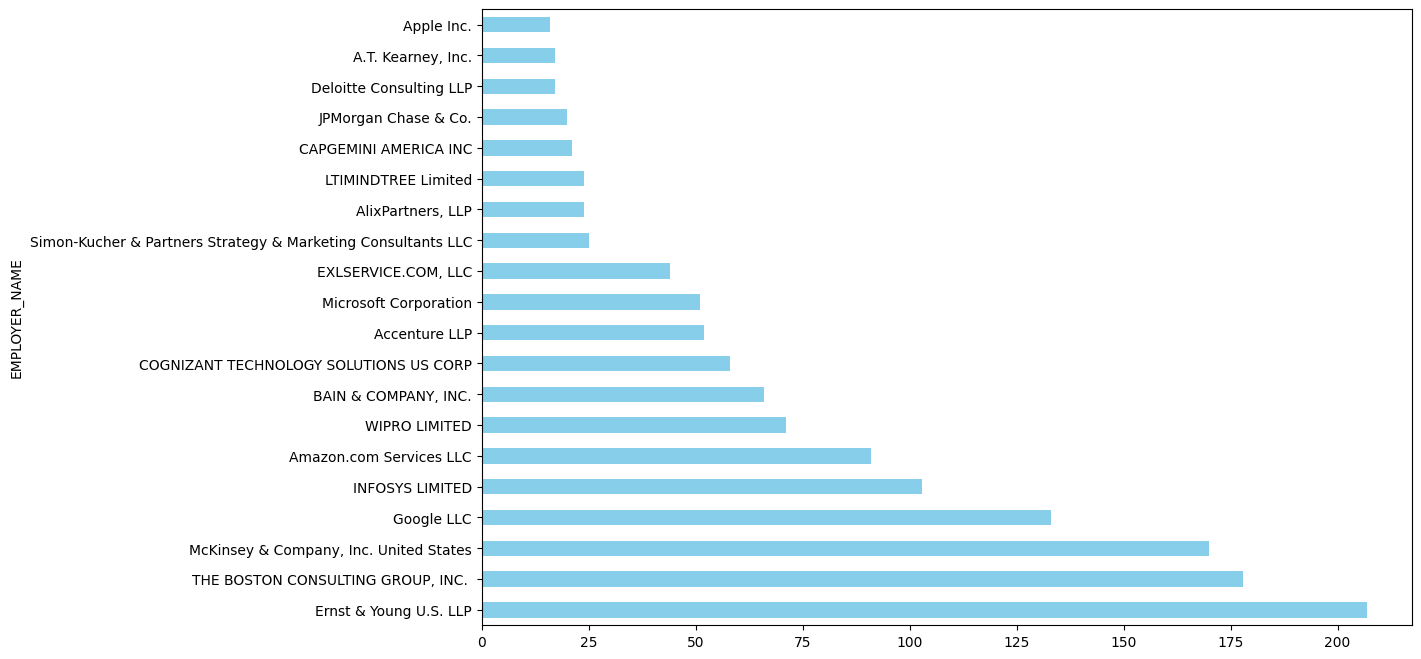

time: 485 ms (started: 2024-06-11 15:04:47 -04:00)


In [111]:
# index 14 and 17 appear to be non-STEM related, so let's investigate further by looking at the Employer Names
non_stem = certified_h1b[certified_h1b['SOC_TITLE'].isin(['Management Analysts', 'Market Research Analysts and Marketing Specialists'])]
non_stem['EMPLOYER_NAME'].value_counts()[0:20].plot(kind='barh', figsize=(12, 8), color='skyblue');

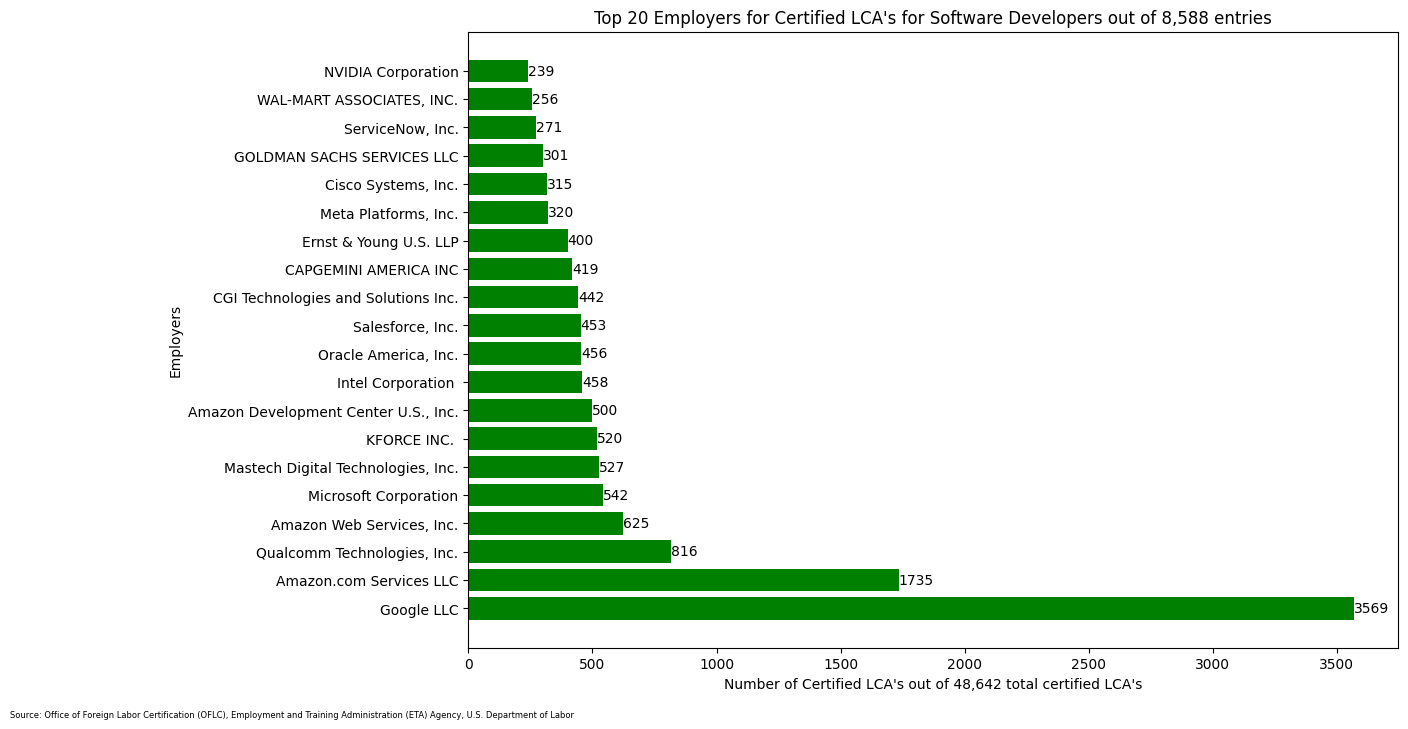

time: 1.16 s (started: 2024-06-11 15:04:48 -04:00)


In [112]:
# Let's plot a bar graph that displays the top 20 employers for the SOC title "Software Developers"
fig, ax = plt.subplots(figsize=(12, 8))
ax.barh(certified_h1b[certified_h1b['SOC_TITLE'] == 'Software Developers']['EMPLOYER_NAME'].value_counts()[0:20].index, 
        certified_h1b[certified_h1b['SOC_TITLE'] == 'Software Developers']['EMPLOYER_NAME'].value_counts()[0:20].values, color='green');
ax.bar_label(ax.containers[0]);
ax.set_title(f'Top 20 Employers for Certified LCA\'s for Software Developers out of {certified_h1b[certified_h1b["SOC_TITLE"] == "Software Developers"]["EMPLOYER_NAME"].nunique():,} entries');
ax.set_ylabel('Employers');
ax.set_xlabel(f'Number of Certified LCA\'s out of {certified_h1b[certified_h1b["SOC_TITLE"] == "Software Developers"].shape[0]:,} total certified LCA\'s');
ax.annotate(text='Source: Office of Foreign Labor Certification (OFLC), Employment and Training Administration (ETA) Agency, U.S. Department of Labor', xy=(0,0), xytext=(-330,-50), fontsize=6, 
             xycoords='axes fraction', textcoords='offset points');

Using the Reuters article linked [here](https://www.reuters.com/markets/us/us-job-growth-slows-april-unemployment-rate-rises-39-2024-05-03/), let's find out about the companies that are classified as being in the healthcare sector using the NAICS classification system.

In [113]:
# let's find out which companies are in the healthcare sector using the NAICS codes
healthcare = certified_h1b_year.copy()
healthcare.info()

<class 'pandas.core.frame.DataFrame'>
Index: 136172 entries, 185 to 633588
Data columns (total 96 columns):
 #   Column                          Non-Null Count   Dtype         
---  ------                          --------------   -----         
 0   CASE_NUMBER                     136172 non-null  object        
 1   CASE_STATUS                     136172 non-null  object        
 2   RECEIVED_DATE                   136172 non-null  datetime64[ns]
 3   DECISION_DATE                   136172 non-null  datetime64[ns]
 4   ORIGINAL_CERT_DATE              0 non-null       datetime64[ns]
 5   VISA_CLASS                      136172 non-null  object        
 6   JOB_TITLE                       136172 non-null  object        
 7   SOC_CODE                        136172 non-null  object        
 8   SOC_TITLE                       136172 non-null  object        
 9   FULL_TIME_POSITION              136172 non-null  object        
 10  BEGIN_DATE                      136172 non-null  datetime64

In [114]:
# convert column to string to make searching easier
healthcare['NAICS_CODE'] = [str(x) for x in healthcare['NAICS_CODE']]
healthcare.info()

<class 'pandas.core.frame.DataFrame'>
Index: 136172 entries, 185 to 633588
Data columns (total 96 columns):
 #   Column                          Non-Null Count   Dtype         
---  ------                          --------------   -----         
 0   CASE_NUMBER                     136172 non-null  object        
 1   CASE_STATUS                     136172 non-null  object        
 2   RECEIVED_DATE                   136172 non-null  datetime64[ns]
 3   DECISION_DATE                   136172 non-null  datetime64[ns]
 4   ORIGINAL_CERT_DATE              0 non-null       datetime64[ns]
 5   VISA_CLASS                      136172 non-null  object        
 6   JOB_TITLE                       136172 non-null  object        
 7   SOC_CODE                        136172 non-null  object        
 8   SOC_TITLE                       136172 non-null  object        
 9   FULL_TIME_POSITION              136172 non-null  object        
 10  BEGIN_DATE                      136172 non-null  datetime64

In [115]:
type(healthcare['NAICS_CODE'].values[0])

str

time: 5.3 ms (started: 2024-06-11 15:04:50 -04:00)


In [116]:
# 62 is sector 62 according to the NAICS
healthcare_companies = healthcare[healthcare['NAICS_CODE'].str.startswith('62')]
healthcare_companies.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6131 entries, 185 to 626381
Data columns (total 96 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   CASE_NUMBER                     6131 non-null   object        
 1   CASE_STATUS                     6131 non-null   object        
 2   RECEIVED_DATE                   6131 non-null   datetime64[ns]
 3   DECISION_DATE                   6131 non-null   datetime64[ns]
 4   ORIGINAL_CERT_DATE              0 non-null      datetime64[ns]
 5   VISA_CLASS                      6131 non-null   object        
 6   JOB_TITLE                       6131 non-null   object        
 7   SOC_CODE                        6131 non-null   object        
 8   SOC_TITLE                       6131 non-null   object        
 9   FULL_TIME_POSITION              6131 non-null   object        
 10  BEGIN_DATE                      6131 non-null   datetime64[ns]
 11  END_D

In [117]:
healthcare_companies['NAICS_CODE'].unique()

array(['622110', '621610', '621498', '621340', '62199', '62211', '621111',
       '622310', '62111', '621210', '6216', '62134', '624410', '621330',
       '62121', '621399', '6221', '62151', '6211', '62161', '62411',
       '6232', '624110', '622210', '621410', '62142', '621511', '621999',
       '621112', '621320', '623990', '6213', '624190', '62149', '6223',
       '621991', '62133', '621491', '623110', '62399', '621420', '624229',
       '6241', '62419', '623220', '621492', '6214', '624120', '623312',
       '621512', '62231', '62131', '6219', '621493', '624230', '62139',
       '624210', '6243', '6212', '621391', '6215', '62412', '623311',
       '621310', '6242', '624310', '62141', '62422', '62132'],
      dtype=object)

time: 3.87 ms (started: 2024-06-11 15:04:50 -04:00)


In [118]:
# let's see what companies are in the healthcare sector in PA
healthcare_companies_pa = healthcare_companies[healthcare_companies['WORKSITE_STATE'] == 'PA']
healthcare_companies_pa.info()

<class 'pandas.core.frame.DataFrame'>
Index: 417 entries, 1011 to 540440
Data columns (total 96 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   CASE_NUMBER                     417 non-null    object        
 1   CASE_STATUS                     417 non-null    object        
 2   RECEIVED_DATE                   417 non-null    datetime64[ns]
 3   DECISION_DATE                   417 non-null    datetime64[ns]
 4   ORIGINAL_CERT_DATE              0 non-null      datetime64[ns]
 5   VISA_CLASS                      417 non-null    object        
 6   JOB_TITLE                       417 non-null    object        
 7   SOC_CODE                        417 non-null    object        
 8   SOC_TITLE                       417 non-null    object        
 9   FULL_TIME_POSITION              417 non-null    object        
 10  BEGIN_DATE                      417 non-null    datetime64[ns]
 11  END_D

In [119]:
healthcare_companies_pa['EMPLOYER_NAME'].unique()

array(['Centerville Clinics, Inc.', 'Pinnacle Health Medical Services',
       'Department of Veterans Affairs',
       'University of Pittsburgh Physicians',
       'Revolutionary Home Health, Inc.', "DRISCOLL CHILDREN'S HOSPITAL",
       'Aviva Mental Health Services, Inc.',
       'UPMC Presbyterian Shadyside',
       "The Children's Hospital of Philadelphia",
       'North Penn Comprehensive Health Services', 'MedAmerica, Inc.',
       'Blue Bell Dental Associates PC', 'WellSpan Medical Group',
       'DLP Conemaugh Physician Services LLC', 'UPMC Passavant',
       'Women Against Abuse, Inc.', 'UPMC Pinnacle Hospitals',
       'Smile Team PC', 'Thomas Jefferson University Hospital',
       'Best Behavioral Healthcare, Inc.',
       'DLP Conemaugh Physician Practices, LLC', 'Dental Dreams LLC',
       "UPMC Children's Hospital of Pittsburgh",
       'OMNI Health Services, Inc.', 'Guthrie Medical Group P.C.',
       'Geisinger Clinic', 'Associates in Nephrology PC',
       'St. Mary 

time: 7.41 ms (started: 2024-06-11 15:04:50 -04:00)


In [120]:
healthcare_companies_pa['JOB_TITLE'].unique()

array(['Family Medicine Physician', 'Pain Management',
       'Cardiologist (Electrophysiologist)',
       'Assistant Professor- Cardiology', 'Registered Nurse Case Manager',
       'Pediatric Resident - Elective Rotation', 'HR Manager',
       'Software Engineer - Tech Lead', 'Postdoctoral Fellow',
       'Research Associate', 'Data Scientist (Remote)',
       'Medical & Healthcare Manager', 'Medical Lab Scientist',
       'Physician, Family Medicine', 'Internal Medicine Physician',
       'Clinical Nurse Manager', 'Clinical Scientist',
       'Director of Evaluation and Learning', 'Clinical Fellow',
       'Medical Physicist', 'General Dentist', 'Fellow',
       'Mental Health Professional', 'Physicians Assistant, Specialist',
       'Noninvasive Cardiologist', 'Dentist',
       'Pulmonary/Critical Care Physician', 'Psychology Fellow Associate',
       'Behavioral Health Counselor', 'Hospitalist',
       'Outpatient Therapist', 'Physician, Hospitalist', 'Nephrologist',
       'Intern

time: 3.94 ms (started: 2024-06-11 15:04:50 -04:00)


In [121]:
healthcare_companies_pa['JOB_TITLE'].value_counts()

JOB_TITLE
Direct Care Professional                  51
Resident - Internal Medicine              21
Medical Resident (Internal Medicine)      17
Medical Resident                           8
Outpatient Therapist                       8
                                          ..
Physician, Emergency Medicine Services     1
General Dentist                            1
Doctor Assistance                          1
ADDORE Outreach Coordinator                1
Cardiac Anesthesiologist                   1
Name: count, Length: 199, dtype: int64

time: 5.29 ms (started: 2024-06-11 15:04:50 -04:00)


In [122]:
healthcare_companies_pa.reset_index(drop=True, inplace=True)
healthcare_companies_pa

CASE_NUMBER CASE_STATUS RECEIVED_DATE DECISION_DATE  \
0    I-200-23265-371069   Certified    2023-09-22    2023-09-29   
1    I-200-23265-373139   Certified    2023-09-22    2023-09-29   
2    I-200-23264-366438   Certified    2023-09-21    2023-09-28   
3    I-200-23263-362681   Certified    2023-09-20    2023-09-27   
4    I-200-23262-360315   Certified    2023-09-19    2023-09-26   
..                  ...         ...           ...           ...   
412  I-200-22279-514410   Certified    2022-10-06    2022-10-14   
413  I-200-22279-514406   Certified    2022-10-06    2022-10-14   
414  I-200-22279-514411   Certified    2022-10-06    2022-10-14   
415  I-200-22279-514416   Certified    2022-10-06    2022-10-14   
416  I-200-22272-500942   Certified    2022-09-29    2022-10-06   

    ORIGINAL_CERT_DATE VISA_CLASS                           JOB_TITLE  \
0                  NaT       H-1B           Family Medicine Physician   
1                  NaT       H-1B                     Pain Management   
2                  NaT       H-1B  Cardiologist (Electrophysiologist)   
3                  NaT       H-1B     Assistant Professor- Cardiology   
4                  NaT       H-1B       Registered Nurse Case Manager   
..                 ...        ...                                 ...   
412                NaT       H-1B            Senior Medical Physicist   
413                NaT       H-1B           Senior Medical Physicist    
414                NaT       H-1B           Senior Medical Physicist    
415                NaT       H-1B           Senior Medical Physicist    
416                NaT       H-1B                  Research Associate   

       SOC_CODE                                          SOC_TITLE  \
0    29-1215.00                         Family Medicine Physicians   
1    29-1229.00                              Physicians, All Other   
2    29-1212.00                                      Cardiologists   
3    29-1212.00                                      Cardiologists   
4    29-1141.00                                  Registered Nurses   
..          ...                                                ...   
412  19-2012.00                                         Physicists   
413  19-2012.00                                         Physicists   
414  29-1299.00  Healthcare Diagnosing or Treating Practitioner...   
415  29-1299.00  Healthcare Diagnosing or Treating Practitioner...   
416  19-1042.00         Medical Scientists, Except Epidemiologists   

    FULL_TIME_POSITION BEGIN_DATE   END_DATE  TOTAL_WORKER_POSITIONS  \
0                    Y 2023-11-01 2026-10-31                       1   
1                    Y 2023-11-01 2026-10-31                       1   
2                    Y 2023-10-22 2026-10-17                       1   
3                    Y 2023-12-01 2026-11-30                       1   
4                    Y 2023-10-01 2026-09-30                       1   
..                 ...        ...        ...                     ...   
412                  Y 2022-11-07 2025-11-06                       1   
413                  Y 2022-11-07 2025-11-06                       1   
414                  Y 2022-11-07 2025-11-06                       1   
415                  Y 2022-11-07 2025-11-06                       1   
416                  Y 2023-01-03 2026-01-02                       1   

     NEW_EMPLOYMENT  CONTINUED_EMPLOYMENT  CHANGE_PREVIOUS_EMPLOYMENT  \
0                 1                     0                           0   
1                 1                     0                           0   
2                 1                     0                           0   
3                 1                     0                           0   
4                 1                     0                           0   
..              ...                   ...                         ...   
412               1                     0                           0   
413               1                     

time: 72.1 ms (started: 2024-06-11 15:04:50 -04:00)


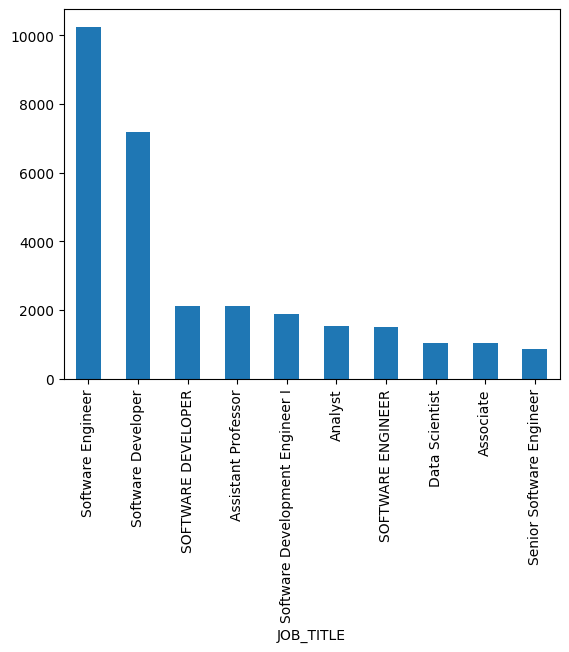

time: 227 ms (started: 2024-06-11 15:04:50 -04:00)


In [123]:
certified_h1b['JOB_TITLE'].value_counts()[0:10].plot(kind='bar');

Looking at the graph above, most of these roles fall into established STEM categories. Perhaps the roles that we can think about outside of STEM are the "Teacher" roles, "Postdoctoral Fellow" roles, and "Assistant Professor" roles. This begs the question, who is contributing the most to the LCAs that are filed for these roles? What fields or industries are they in?

Academia seems to be the most prevalent pathway for non-STEM people to stay in the U.S.

In [124]:
# I want to narrow down positions based on their relevance to STEM or non-STEM
# I will use the SOC codes for the job titles
# Let's see what those look like

certified_h1b['SOC_CODE'].unique()

array(['19-1042.00', '13-1111.00', '15-1252.00', '15-1251.00',
       '15-1299.00', '29-1216.00', '27-2022.00', '15-1244.00',
       '17-2051.00', '29-2011.00', '19-3051.00', '29-9099.00',
       '11-3121.00', '25-1052.00', '17-2141.00', '15-1253.00',
       '29-1031.00', '11-2021.00', '13-1199.00', '15-1211.00',
       '17-2112.00', '13-2054.00', '13-1161.00', '11-1021.00',
       '19-1032.00', '15-1242.00', '11-3021.00', '15-1243.00',
       '13-1082.00', '27-1021.00', '17-3011.00', '25-2031.00',
       '15-1254.00', '19-1022.00', '17-2061.00', '11-9041.00',
       '25-1126.00', '13-2011.00', '27-1011.00', '15-2051.00',
       '29-1141.00', '25-1021.00', '17-2072.00', '11-3031.00',
       '15-1212.00', '25-1011.00', '13-2051.00', '19-2031.00',
       '19-2012.00', '15-2041.00', '11-9033.00', '15-1255.00',
       '25-1042.00', '13-1081.00', '29-1051.00', '15-2021.00',
       '15-2031.00', '11-2022.00', '15-1221.00', '27-3041.00',
       '25-1066.00', '19-2041.00', '17-2011.00', '17-20

time: 17 ms (started: 2024-06-11 15:04:51 -04:00)


<Axes: xlabel='EMPLOYER_NAME'>

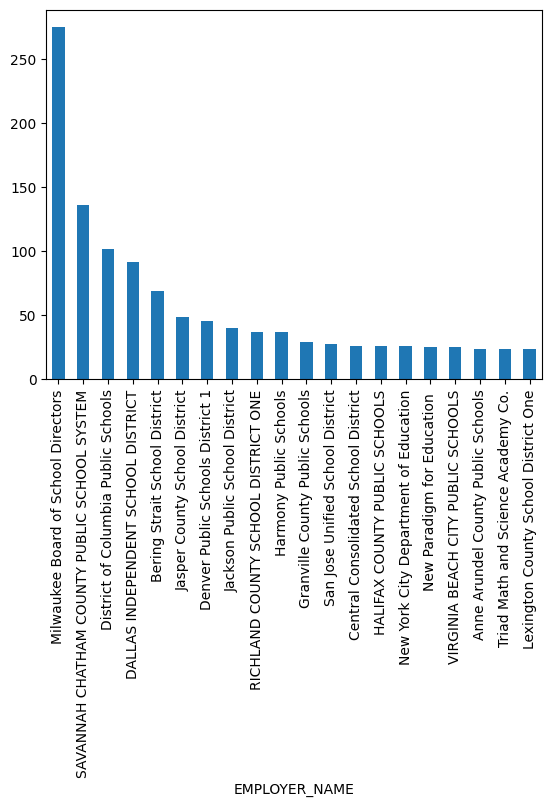

time: 515 ms (started: 2024-06-11 15:04:51 -04:00)


In [125]:
teachers = certified_h1b[certified_h1b['SOC_CODE'].str.startswith('25-20')]
teachers['EMPLOYER_NAME'].value_counts()[0:20].plot(kind='bar')

<Axes: xlabel='JOB_TITLE'>

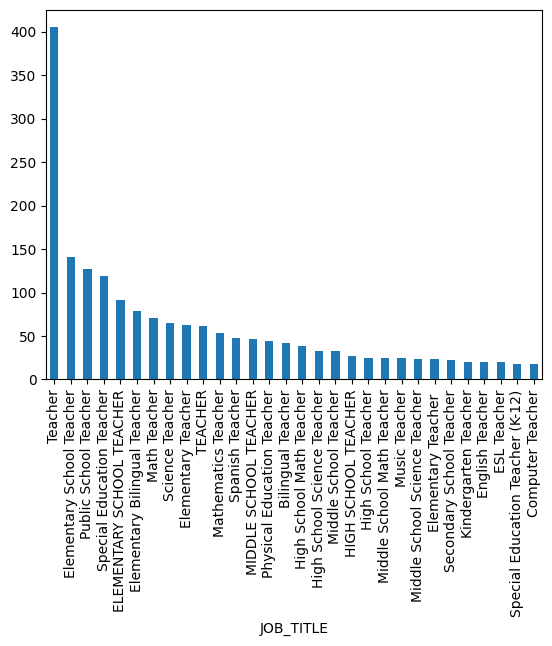

time: 451 ms (started: 2024-06-11 15:04:51 -04:00)


In [126]:
teachers['JOB_TITLE'].value_counts()[0:30].plot(kind='bar')

In [127]:
certified_h1b['SOC_CODE'].unique().size

599

time: 14.9 ms (started: 2024-06-11 15:04:52 -04:00)


In [128]:
certified_h1b['SOC_CODE'].nunique()

599

time: 15 ms (started: 2024-06-11 15:04:52 -04:00)


In [129]:
certified_h1b['SOC_TITLE'].nunique()

430

time: 22.7 ms (started: 2024-06-11 15:04:52 -04:00)


In [130]:
certified_h1b['SOC_TITLE'].unique()

array(['Medical Scientists, Except Epidemiologists',
       'Management Analysts', 'Software Developers',
       'Computer Programmers', 'Computer Occupations, All Other',
       'General Internal Medicine Physicians', 'Coaches and Scouts',
       'Network and Computer Systems Administrators', 'Civil Engineers',
       'Medical and Clinical Laboratory Technologists',
       'Urban and Regional Planners',
       'Healthcare Practitioners and Technical Workers, All Other',
       'Human Resources Managers', 'Chemistry Teachers, Postsecondary',
       'Mechanical Engineers',
       'Software Quality Assurance Analysts and Testers',
       'Dietitians and Nutritionists', 'Marketing Managers',
       'Business Operations Specialists, All Other',
       'Computer Systems Analysts', 'Industrial Engineers',
       'Financial Risk Specialists',
       'Market Research Analysts and Marketing Specialists',
       'General and Operations Managers', 'Foresters',
       'Database Administrators',
  

time: 31.4 ms (started: 2024-06-11 15:04:52 -04:00)


In [131]:
certified_h1b[certified_h1b['SOC_TITLE'].str.contains('software', case=False)]['SOC_TITLE'].value_counts()

SOC_TITLE
Software Developers                                48642
Software Quality Assurance Analysts and Testers     4307
Name: count, dtype: int64

time: 230 ms (started: 2024-06-11 15:04:52 -04:00)


In [132]:
certified_h1b[certified_h1b['SOC_TITLE'].str.contains('software', case=False)]['SOC_TITLE'].size

52949

time: 193 ms (started: 2024-06-11 15:04:52 -04:00)


In [133]:
print(f"We have uncovered that the H-1B certified roles for new employment that contain the word \"software\" in them total to {certified_h1b[certified_h1b['SOC_TITLE'].str.contains('software', case=False)]['SOC_TITLE'].size:,} out of the total {certified_h1b.shape[0]:,} roles that were awarded certified status for an H-1B Labor Condition Application.")

We have uncovered that the H-1B certified roles for new employment that contain the word "software" in them total to 52,949 out of the total 145,710 roles that were awarded certified status for an H-1B Labor Condition Application.
time: 210 ms (started: 2024-06-11 15:04:52 -04:00)


In [134]:
# let's see how many full time positions that were applied for
data['FULL_TIME_POSITION'].value_counts()

FULL_TIME_POSITION
Y    450989
N      7347
Name: count, dtype: int64

time: 95.2 ms (started: 2024-06-11 15:04:53 -04:00)


## TODO: Time-series analysis by grouping LCA's on the datetime columns to examine patterns in how LCA submissions are made by employers

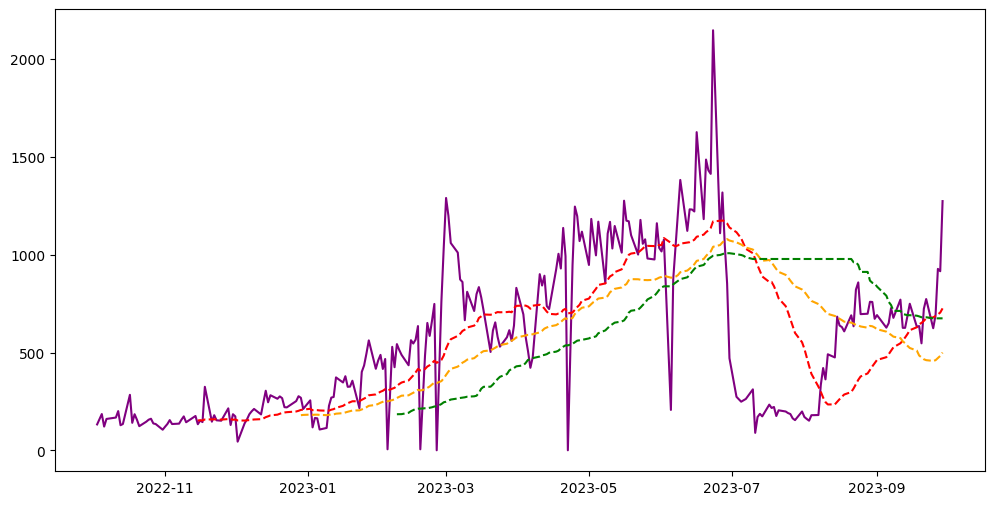

time: 393 ms (started: 2024-06-11 15:04:53 -04:00)


In [135]:
# Let's use the DECISION_DATE to determine how certified LCAs changed in their numbers over time by counting the number of records received each day for the entire year
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(certified_h1b['DECISION_DATE'].value_counts().sort_index(), linestyle='-', color='purple');
ax.plot(certified_h1b['DECISION_DATE'].value_counts().sort_index().rolling(window=30).mean(), linestyle='--', color='red');
ax.plot(certified_h1b['DECISION_DATE'].value_counts().sort_index().rolling(window=60).mean(), linestyle='--', color='orange');
ax.plot(certified_h1b['DECISION_DATE'].value_counts().sort_index().rolling(window=90).median(), linestyle='--', color='green');

Count the number of records that appear in the data frame for a given date and label that value `count`. Create a table that whose records contain the date and the corresponding `count` value. Sort the table by the date from earliest to latest. Look back 30 `count` values, calculate the mean of those 30 `count` values, and record that mean in a table. Plot the means from this table on a graph.

In [136]:
%%time

fig = go.Figure(go.Scatter(x=certified_h1b['DECISION_DATE'].value_counts().sort_index().index, 
                           y=certified_h1b['DECISION_DATE'].value_counts().sort_index().values,
                           mode='lines',
                           name='Daily Counts',
                           line=dict(color='red')))
fig.show()

CPU times: user 14.5 ms, sys: 6.25 ms, total: 20.8 ms
Wall time: 41.3 ms
time: 42.9 ms (started: 2024-06-11 15:04:53 -04:00)


In [137]:
fig = go.Figure(go.Scatter(x=colleges_and_universities['DECISION_DATE'].value_counts().sort_index().index, y=colleges_and_universities['DECISION_DATE'].value_counts().sort_index().values, mode='lines', name='Daily Counts'))
fig.show()

time: 12.1 ms (started: 2024-06-11 15:04:53 -04:00)


## TO-DO: Contingency tables to compare categorical variables i.e. New employment for H-1B vs. Continued Employment for H-1B

## TO-DO: Conditional distribution of Case Status by Visa Class

## TO-DO: Conditional distribution of Case Status by H-1B Employer Type (use the NAICS Code) (add the citation to 65,000 limit, U.S.C citation for institutions of higher education)

Let's try to find the relationship between the case status of a Labor Condition Application and the employer filing the Labor Condition Application. Can we say that the type of the employer benefits the outcome of the Labor Condition Application submitted on behalf of an employer's future employee?

First, we will give context about the H-1B program.

The H-1B visa allows an employer to temporarily employ foreign professional workers in the U.S. on a nonimmigrant basis in a specialty occupation or as a fashion model of distinguished merit and ability. Under 20 CFR 655.715, a specialty occupation requires the theoretical and practical application of a body of specialized knowledge and a bachelor's degree or the equivalent in the specific specialty (e.g., sciences, medicine and health care, education, biotechnology, business specialties, etc.).

It is the most popular visa class out of the 4 visa classes that require the filing of a Labor Condition Application. And when employers seek to employ foreign workers, specific employers are subject to the annual 65,000 "cap" set by U.S. Congress that restricts the number of H-1B nonimmigrant visas allocated to foreign workers within a given year. These employers are termed "H-1B cap-subject" employers. Other employers are exempt from the Congress-mandated cap and are termed "H-1B cap-exempt" employers.

H-1B cap-exempt employers have specific criteria that is required of them to be defined this way. The criteria that specifies which organizations qualify for cap-exemption is defined in the U.S. Code, and these organizations include:
- Institutions of higher education
- Nonprofit research organizations
- Government research organizations

According to the U.S. Code, colleges and universities are included among institutions of higher education, and the dataset that we are using for this analysis contains a field that can help us isolate these exact organizations as cap-exempt employers.

Our dataset contains a field called NAICS_CODE. This represents the code that each employer is given according to the North American Industry Classification System that categorizes employers according to the industry that they are in. 

We will use it to isolate colleges and universities, which meet the definition described in the U.S. Code as being institutions of higher education that are exempt from the annual H-1B cap.

## TO-DO: Conditional distribution of Case Status by Employer Name?

## TO-DO: Conditional distribution of Case Status by Role

## TO-DO: Conditional distribution of Case Status by Employment Renewal Type (New, Continuing, New Concurrent, Changing Employer, Amended Petition) 

## TO-DO: Conditional distribution of Case Status by Position Type (Full-Time or not Full-Time) 

## Rough Work

Let's compute the same analyses for the CONTINUED_EMPLOYMENT, CHANGE_PREVIOUS_EMPLOYMENT, NEW_CONCURRENT_EMPLOYMENT, CHANGE_EMPLOYER, and AMENDED_PETITION columns.

In [138]:
# Create a new list of columns for the different types of employment conditions for the LCAs
cols_list = ['CONTINUED_EMPLOYMENT', 'CHANGE_PREVIOUS_EMPLOYMENT', 'NEW_CONCURRENT_EMPLOYMENT', 'CHANGE_EMPLOYER', 'AMENDED_PETITION']

# Check how many unique values are in each of the columns in the cols_list
# List the unique values in the 'NEW_EMPLOYMENT' column in ascending order
for col in cols_list:
    print(f'{col}: {data[col].nunique()}')

CONTINUED_EMPLOYMENT: 39
CHANGE_PREVIOUS_EMPLOYMENT: 18
NEW_CONCURRENT_EMPLOYMENT: 15
CHANGE_EMPLOYER: 19
AMENDED_PETITION: 20
time: 22.6 ms (started: 2024-06-11 15:04:53 -04:00)


In [139]:
[data[col].value_counts().sort_index().index for col in cols_list] 

[Index([   0,    1,    2,    3,    4,    5,    6,    7,    8,    9,   10,   12,
          13,   15,   16,   19,   20,   23,   24,   25,   30,   31,   35,   40,
          41,   45,   50,   60,   65,   70,   80,   85,   90,   95,  100,  110,
         150,  300, 1098],
       dtype='int64', name='CONTINUED_EMPLOYMENT'),
 Index([0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 12, 15, 20, 24, 25, 223, 300, 1098], dtype='int64', name='CHANGE_PREVIOUS_EMPLOYMENT'),
 Index([0, 1, 2, 3, 4, 5, 6, 7, 8, 15, 24, 223, 250, 300, 1098], dtype='int64', name='NEW_CONCURRENT_EMPLOYMENT'),
 Index([0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 12, 14, 15, 20, 24, 25, 50, 300, 1098], dtype='int64', name='CHANGE_EMPLOYER'),
 Index([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20, 24, 25, 30, 50, 250, 300,
        1098],
       dtype='int64', name='AMENDED_PETITION')]

time: 26.1 ms (started: 2024-06-11 15:04:53 -04:00)


In [140]:
[data[col].value_counts().sort_index().head() for col in cols_list]

[CONTINUED_EMPLOYMENT
 0    348977
 1    102317
 2      1825
 3       200
 4      1048
 Name: count, dtype: int64,
 CHANGE_PREVIOUS_EMPLOYMENT
 0    426016
 1     26327
 2      1395
 3       189
 4       991
 Name: count, dtype: int64,
 NEW_CONCURRENT_EMPLOYMENT
 0    455175
 1      3016
 2        23
 3         5
 4         8
 Name: count, dtype: int64,
 CHANGE_EMPLOYER
 0    368566
 1     83655
 2      1499
 3       220
 4      1059
 Name: count, dtype: int64,
 AMENDED_PETITION
 0    365088
 1     85287
 2      1839
 3       723
 4      1035
 Name: count, dtype: int64]

time: 66.5 ms (started: 2024-06-11 15:04:53 -04:00)


In [141]:
# Duplicated values
data_2 = initial_data.copy()
data_2.duplicated().sum()

98001

time: 8.12 s (started: 2024-06-11 15:04:53 -04:00)


In [142]:
data_2.drop_duplicates(inplace=True)
data_2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 546606 entries, 0 to 633773
Data columns (total 96 columns):
 #   Column                          Non-Null Count   Dtype         
---  ------                          --------------   -----         
 0   CASE_NUMBER                     546606 non-null  object        
 1   CASE_STATUS                     546606 non-null  object        
 2   RECEIVED_DATE                   546606 non-null  datetime64[ns]
 3   DECISION_DATE                   546606 non-null  datetime64[ns]
 4   ORIGINAL_CERT_DATE              33482 non-null   datetime64[ns]
 5   VISA_CLASS                      546606 non-null  object        
 6   JOB_TITLE                       546606 non-null  object        
 7   SOC_CODE                        546606 non-null  object        
 8   SOC_TITLE                       546606 non-null  object        
 9   FULL_TIME_POSITION              546606 non-null  object        
 10  BEGIN_DATE                      546606 non-null  datetime64[n

In [143]:
data_2.head(20)

CASE_NUMBER            CASE_STATUS RECEIVED_DATE DECISION_DATE  \
0   I-200-23244-317261  Certified - Withdrawn    2023-09-01    2023-09-30   
1   I-202-23242-306442  Certified - Withdrawn    2023-08-30    2023-09-30   
2   I-200-23242-308144  Certified - Withdrawn    2023-08-30    2023-09-30   
3   I-200-23172-131625  Certified - Withdrawn    2023-06-21    2023-09-30   
4   I-200-23170-125146  Certified - Withdrawn    2023-06-19    2023-09-30   
5   I-200-23170-123899  Certified - Withdrawn    2023-06-19    2023-09-30   
6   I-200-23046-776502  Certified - Withdrawn    2023-02-15    2023-09-30   
7   I-203-22333-610021  Certified - Withdrawn    2022-11-29    2023-09-30   
8   I-200-22216-395597  Certified - Withdrawn    2022-08-03    2023-09-30   
9   I-203-23274-403704              Withdrawn    2023-09-30    2023-09-30   
10  I-200-23273-403071              Withdrawn    2023-09-30    2023-09-30   
11  I-203-23273-401458              Withdrawn    2023-09-29    2023-09-30   
12  I-200-23267-376298  Certified - Withdrawn    2023-09-24    2023-09-29   
13  I-200-23267-376300  Certified - Withdrawn    2023-09-24    2023-09-29   
14  I-200-23267-376246  Certified - Withdrawn    2023-09-23    2023-09-29   
15  I-200-23265-372409  Certified - Withdrawn    2023-09-22    2023-09-29   
16  I-200-23265-370209  Certified - Withdrawn    2023-09-22    2023-09-29   
17  I-200-23265-371438  Certified - Withdrawn    2023-09-22    2023-09-29   
18  I-200-23261-354674  Certified - Withdrawn    2023-09-18    2023-09-29   
19  I-200-23260-353051  Certified - Withdrawn    2023-09-17    2023-09-29   

   ORIGINAL_CERT_DATE       VISA_CLASS  \
0          2023-09-11             H-1B   
1          2023-09-07  H-1B1 Singapore   
2          2023-09-07             H-1B   
3          2023-06-28             H-1B   
4          2023-06-26             H-1B   
5          2023-06-26             H-1B   
6          2023-02-22             H-1B   
7          2022-12-06   E-3 Australian   
8          2022-08-10             H-1B   
9                 NaT   E-3 Australian   
10                NaT             H-1B   
11                NaT   E-3 Australian   
12         2023-09-29             H-1B   
13         2023-09-29             H-1B   
14         2023-09-29             H-1B   
15         2023-09-29             H-1B   
16         2023-09-29             H-1B   
17         2023-09-29             H-1B   
18         2023-09-25             H-1B   
19         2023-09-22             H-1B   

                                 JOB_TITLE    SOC_CODE  \
0                     Analyst, Business Sr  15-2031.00   
1         Board Certified Behavior Analyst  19-3034.00   
2           Manager - Software Engineering  15-1252.00   
3                       SOFTWARE DEVELOPER  15-1252.00   
4                       SOFTWARE DEVELOPER  15-1252.00   
5                       SOFTWARE DEVELOPER  15-1252.00   
6        Senior Manager, Americas Division  13-1111.00   
7              Vice President, Engineering  11-3021.00   
8                         BUSINESS ANALYST  15-1211.00   
9                           CEO of BioBrew  11-1021.00   
10                  Architectural Designer  17-1011.00   
11     Staff Research Engineer, Superlunar  15-1252.00   
12                          Technical Lead  15-1251.00   
13                         DevOps Engineer  15-1242.00   
14              SAP - Technical Consultant  15-1299.08   
15                        Systems Analyst   15-1211.00   
16               Interior Design Graduate   27-1025.00   
17  Digital Software Engineer Lead Analyst  15-1253.00   
18    Quality Assurance Engineer – Level 3  15-1253.00   
19      Network And Security Administrator  15-1244.00   

                                          SOC_TITLE FULL_TIME_POSITION  \
0                      Operations Research Analysts                  Y   
1                              School Psychologists                  Y   
2                               Software Developers                  

time: 80.9 ms (started: 2024-06-11 15:05:09 -04:00)


In [144]:
# Create a new column called "COLLEGE_OR_UNIV" in the data_2 dataframe which will contain strings that describe the type of employer
# It will contain the string "Yes" if the employer is a college or university and "No" if the employer is not a college or university
# The column will be created by checking if the NAICS_CODE column contains the string "611310"
# This represents the NAICS code for colleges and universities
data_2['COLLEGE_OR_UNIV'] = ['Yes' if '611310' in str(x) else 'No' for x in data_2['NAICS_CODE']]
data_2['COLLEGE_OR_UNIV'].value_counts()

COLLEGE_OR_UNIV
No     515293
Yes     31313
Name: count, dtype: int64

time: 175 ms (started: 2024-06-11 15:05:09 -04:00)


This tells us that 31,455 of the 546,888 entries were made by employers who are classified as colleges and universities by the NAICS code. In other words, there were at least 31,313 applications submitted by H-1B cap-exempt employers. The at least specification is crucial because the criteria used for identifying H-1B cap-exempt employers from this dataset does not identify all H-1B cap-exempt employers. The NAICS code does not classify for nonprofit research organizations or governmental research organizations. (Add citation from the NAICS Code Manual)

Let's see how the frequencies for the case status were distributed by the employer type.

In [145]:
# Create a contingency table for the CASE_STATUS and COLLEGE_OR_UNIV categories with the numbers displayed
pd.crosstab(index=data_2['CASE_STATUS'], 
            columns=data_2['COLLEGE_OR_UNIV'],
            rownames=['Case Status'],
            colnames=['College or University?'], 
            margins=True,
            margins_name='Total')

College or University?      No    Yes   Total
Case Status                                  
Certified               476235  24737  500972
Certified - Withdrawn    27759   5723   33482
Denied                    2592     32    2624
Withdrawn                 8707    821    9528
Total                   515293  31313  546606

time: 341 ms (started: 2024-06-11 15:05:09 -04:00)


Let's change these numbers to percentages.

In [146]:
# Create a contingency table for the CASE_STATUS and COLLEGE_OR_UNIV categories with the percentages displayed
pd.crosstab(index=data_2['CASE_STATUS'], 
            columns=data_2['COLLEGE_OR_UNIV'],
            rownames=['Case Status'],
            colnames=['College or University?'], 
            margins=True,
            margins_name='Total',
            normalize='all')

College or University?        No       Yes     Total
Case Status                                         
Certified               0.871258  0.045256  0.916514
Certified - Withdrawn   0.050784  0.010470  0.061254
Denied                  0.004742  0.000059  0.004801
Withdrawn               0.015929  0.001502  0.017431
Total                   0.942714  0.057286  1.000000

time: 376 ms (started: 2024-06-11 15:05:10 -04:00)


Let's condition on the rows by looking at the values of the Case Status column.

In [147]:
# Create a contingency table for the CASE_STATUS and COLLEGE_OR_UNIV categories with columns normalized by the index
pd.crosstab(index=data_2['CASE_STATUS'], 
            columns=data_2['COLLEGE_OR_UNIV'],
            rownames=['Case Status'],
            colnames=['College or University?'], 
            margins=True,
            margins_name='Total',
            normalize='index')

College or University?        No       Yes
Case Status                               
Certified               0.950622  0.049378
Certified - Withdrawn   0.829072  0.170928
Denied                  0.987805  0.012195
Withdrawn               0.913833  0.086167
Total                   0.942714  0.057286

time: 258 ms (started: 2024-06-11 15:05:10 -04:00)


Out of the applications whose Case Status was determined to be Denied as of September 30, 2023, 1.2% were colleges and universities.

Let's condition on the columns by looking at the values of the newly created COLLEGE_OR_UNIV column.

In [148]:
# Create a contingency table for the CASE_STATUS and COLLEGE_OR_UNIV categories with index normalized by the columns
pd.crosstab(index=data_2['CASE_STATUS'], 
            columns=data_2['COLLEGE_OR_UNIV'],
            rownames=['Case Status'],
            colnames=['College or University?'], 
            margins=True,
            margins_name='Total',
            normalize='columns')

College or University?        No       Yes     Total
Case Status                                         
Certified               0.924202  0.789991  0.916514
Certified - Withdrawn   0.053870  0.182768  0.061254
Denied                  0.005030  0.001022  0.004801
Withdrawn               0.016897  0.026219  0.017431

time: 246 ms (started: 2024-06-11 15:05:10 -04:00)


Out of all of the Labor Condition Applications that were filed by employers, 92.4% of the applications were certified, but 78.8% of the colleges and universities were certified.

In [149]:
# Create a contingency table for the CASE_STATUS and VISA_CLASS categories with all numbers normalized
pd.crosstab(index=data_2['CASE_STATUS'], 
            columns=data_2['VISA_CLASS'],
            rownames=['Case Status'],
            colnames=['Visa Class'], 
            margins=True,
            margins_name='Total',
            normalize='all')

Visa Class             E-3 Australian      H-1B  H-1B1 Chile  H-1B1 Singapore  \
Case Status                                                                     
Certified                    0.016782  0.893492     0.003674         0.002567   
Certified - Withdrawn        0.001321  0.059465     0.000258         0.000210   
Denied                       0.000498  0.004114     0.000152         0.000037   
Withdrawn                    0.000430  0.016859     0.000091         0.000051   
Total                        0.019030  0.973930     0.004175         0.002865   

Visa Class                Total  
Case Status                      
Certified              0.916514  
Certified - Withdrawn  0.061254  
Denied                 0.004801  
Withdrawn              0.017431  
Total                  1.000000

time: 260 ms (started: 2024-06-11 15:05:11 -04:00)


In [150]:
# Create a contingency table for the CASE_STATUS and VISA_CLASS categories with all numbers normalized
pd.crosstab(index=data_2['CASE_STATUS'], 
            columns=data_2['VISA_CLASS'],
            rownames=['Case Status'],
            colnames=['Visa Class'], 
            margins=True,
            margins_name='Total')

Visa Class             E-3 Australian    H-1B  H-1B1 Chile  H-1B1 Singapore  \
Case Status                                                                   
Certified                        9173  488388         2008             1403   
Certified - Withdrawn             722   32504          141              115   
Denied                            272    2249           83               20   
Withdrawn                         235    9215           50               28   
Total                           10402  532356         2282             1566   

Visa Class              Total  
Case Status                    
Certified              500972  
Certified - Withdrawn   33482  
Denied                   2624  
Withdrawn                9528  
Total                  546606

time: 257 ms (started: 2024-06-11 15:05:11 -04:00)


In [151]:
# Create a contingency table for the CASE_STATUS against the VISA_CLASS and COLLEGE_OR_UNIV categories
pd.crosstab(index=data_2['CASE_STATUS'], 
            columns=[data_2['VISA_CLASS'], data_2['COLLEGE_OR_UNIV']],
            rownames=['Case Status'],
            colnames=['Visa Class', 'College or University?'], 
            margins=True,
            margins_name='Total',
            normalize='all')

Visa Class             E-3 Australian                H-1B            \
College or University?             No       Yes        No       Yes   
Case Status                                                           
Certified                    0.016471  0.000311  0.848576  0.044915   
Certified - Withdrawn        0.001259  0.000062  0.049061  0.010404   
Denied                       0.000498  0.000000  0.004056  0.000059   
Withdrawn                    0.000415  0.000015  0.015373  0.001486   
Total                        0.018642  0.000388  0.917066  0.056864   

Visa Class             H-1B1 Chile           H-1B1 Singapore            \
College or University?          No       Yes              No       Yes   
Case Status                                                              
Certified                 0.003655  0.000018        0.002556  0.000011   
Certified - Withdrawn     0.000256  0.000002        0.000209  0.000002   
Denied                    0.000152  0.000000        0.000037  0.000000   
Withdrawn                 0.000090  0.000002        0.000051  0.000000   
Total                     0.004153  0.000022        0.002852  0.000013   

Visa Class                 Total  
College or University?            
Case Status                       
Certified               0.916514  
Certified - Withdrawn   0.061254  
Denied                  0.004801  
Withdrawn               0.017431  
Total                   1.000000

time: 378 ms (started: 2024-06-11 15:05:11 -04:00)


In [152]:
# Create a contingency table for the CASE_STATUS and VISA_CLASS categories
pd.crosstab(index=data_2['CASE_STATUS'], 
            columns=[data_2['VISA_CLASS'], data_2['COLLEGE_OR_UNIV']],
            rownames=['Case Status'],
            colnames=['Visa Class', 'College or University?'], 
            margins=True,
            margins_name='Total',
            normalize='index')

Visa Class             E-3 Australian                H-1B            \
College or University?             No       Yes        No       Yes   
Case Status                                                           
Certified                    0.017971  0.000339  0.925874  0.049007   
Certified - Withdrawn        0.020548  0.001015  0.800938  0.169852   
Denied                       0.103659  0.000000  0.844893  0.012195   
Withdrawn                    0.023825  0.000840  0.881927  0.085223   
Total                        0.018642  0.000388  0.917066  0.056864   

Visa Class             H-1B1 Chile           H-1B1 Singapore            
College or University?          No       Yes              No       Yes  
Case Status                                                             
Certified                 0.003988  0.000020        0.002789  0.000012  
Certified - Withdrawn     0.004181  0.000030        0.003405  0.000030  
Denied                    0.031631  0.000000        0.007622  0.000000  
Withdrawn                 0.005143  0.000105        0.002939  0.000000  
Total                     0.004153  0.000022        0.002852  0.000013

time: 540 ms (started: 2024-06-11 15:05:12 -04:00)


In [153]:
# Create a contingency table for the CASE_STATUS and VISA_CLASS categories
pd.crosstab(index=data_2['CASE_STATUS'], 
            columns=[data_2['VISA_CLASS'], data_2['COLLEGE_OR_UNIV']],
            rownames=['Case Status'],
            colnames=['Visa Class', 'College or University?'], 
            margins=True,
            margins_name='Total',
            normalize='columns')

Visa Class             E-3 Australian                H-1B            \
College or University?             No       Yes        No       Yes   
Case Status                                                           
Certified                    0.883513  0.801887  0.925316  0.789878   
Certified - Withdrawn        0.067517  0.160377  0.053498  0.182968   
Denied                       0.026693  0.000000  0.004423  0.001030   
Withdrawn                    0.022277  0.037736  0.016763  0.026124   

Visa Class             H-1B1 Chile           H-1B1 Singapore            \
College or University?          No       Yes              No       Yes   
Case Status                                                              
Certified                 0.880176  0.833333        0.896087  0.857143   
Certified - Withdrawn     0.061674  0.083333        0.073124  0.142857   
Denied                    0.036564  0.000000        0.012829  0.000000   
Withdrawn                 0.021586  0.083333        0.017960  0.000000   

Visa Class                 Total  
College or University?            
Case Status                       
Certified               0.916514  
Certified - Withdrawn   0.061254  
Denied                  0.004801  
Withdrawn               0.017431

time: 356 ms (started: 2024-06-11 15:05:12 -04:00)


In [154]:
# Create a contingency table for the CASE_STATUS and VISA_CLASS categories with the columns normalized by the index
pd.crosstab(index=data_2['CASE_STATUS'], 
            columns=data_2['VISA_CLASS'],
            rownames=['Case Status'],
            colnames=['Visa Class'], 
            margins=True,
            margins_name='Total',
            normalize='columns')

Visa Class             E-3 Australian      H-1B  H-1B1 Chile  H-1B1 Singapore  \
Case Status                                                                     
Certified                    0.881850  0.917409     0.879930         0.895913   
Certified - Withdrawn        0.069410  0.061057     0.061788         0.073436   
Denied                       0.026149  0.004225     0.036372         0.012771   
Withdrawn                    0.022592  0.017310     0.021911         0.017880   

Visa Class                Total  
Case Status                      
Certified              0.916514  
Certified - Withdrawn  0.061254  
Denied                 0.004801  
Withdrawn              0.017431

time: 263 ms (started: 2024-06-11 15:05:12 -04:00)


In [155]:
# Create a contingency table for the CASE_STATUS and VISA_CLASS categories with the index normalized by the columns
pd.crosstab(index=data_2['CASE_STATUS'], 
            columns=data_2['VISA_CLASS'],
            rownames=['Case Status'],
            colnames=['Visa Class'], 
            margins=True,
            margins_name='Total',
            normalize='index')

Visa Class             E-3 Australian      H-1B  H-1B1 Chile  H-1B1 Singapore
Case Status                                                                  
Certified                    0.018310  0.974881     0.004008         0.002801
Certified - Withdrawn        0.021564  0.970790     0.004211         0.003435
Denied                       0.103659  0.857088     0.031631         0.007622
Withdrawn                    0.024664  0.967149     0.005248         0.002939
Total                        0.019030  0.973930     0.004175         0.002865

time: 262 ms (started: 2024-06-11 15:05:13 -04:00)


In [156]:
# Create a contingency table for the CASE_STATUS and FULL_TIME_POSITION categories
pd.crosstab(index=data_2['CASE_STATUS'], 
            columns=data_2['FULL_TIME_POSITION'],
            rownames=['Case Status'],
            colnames=['Full Time Position?'], 
            margins=True,
            margins_name='Total')

Full Time Position?       N       Y   Total
Case Status                                
Certified              7339  493633  500972
Certified - Withdrawn   523   32959   33482
Denied                  191    2433    2624
Withdrawn               210    9318    9528
Total                  8263  538343  546606

time: 245 ms (started: 2024-06-11 15:05:13 -04:00)


In [157]:
data_2['WAGE_UNIT_OF_PAY'].value_counts()

WAGE_UNIT_OF_PAY
Year         514067
Hour          31761
Month           586
Week             98
Bi-Weekly        93
Name: count, dtype: int64

time: 24.8 ms (started: 2024-06-11 15:05:13 -04:00)


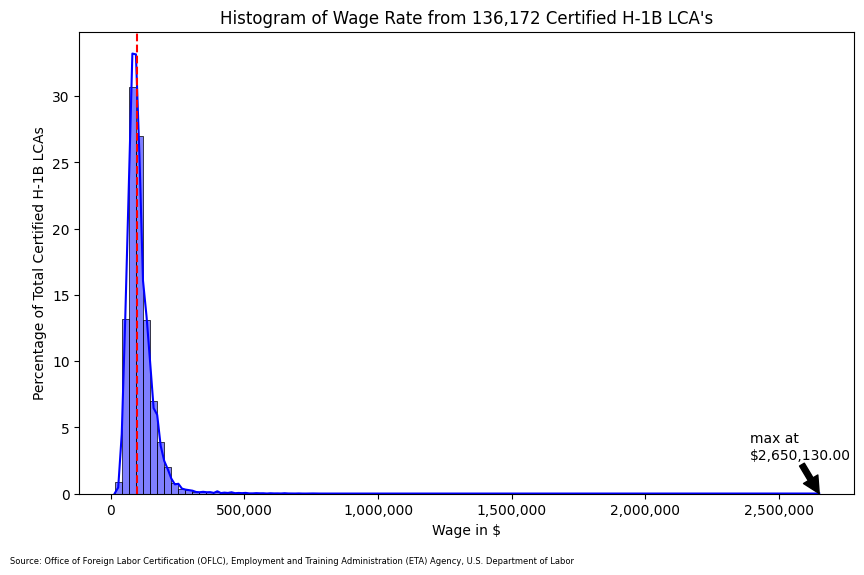

time: 1.03 s (started: 2024-06-11 15:05:13 -04:00)


In [158]:
# Let's use the seaborn library to create a histogram of the PREVAILING_WAGE values
fig, ax = plt.subplots(figsize=(10, 6))
sns.histplot(certified_h1b_year, x='WAGE_RATE_OF_PAY_FROM', stat='percent', bins=100, color='blue', ax=ax, kde=True);
ax.set_title(f'Histogram of Wage Rate from {certified_h1b_year.shape[0]:,} Certified H-1B LCA\'s');
ax.set_xlabel(f'Wage in $');
# ax.set_xlim(0, 1000000);
ax.xaxis.set_major_formatter('{:,.0f}'.format)
ax.set_ylabel('Percentage of Total Certified H-1B LCAs');
ax.annotate(text='Source: Office of Foreign Labor Certification (OFLC), Employment and Training Administration (ETA) Agency, U.S. Department of Labor', xy=(0,0), xytext=(-50,-50), fontsize=6, 
             xycoords='axes fraction', textcoords='offset points');
ax.annotate(text=f'median at\n${certified_h1b_year['WAGE_RATE_OF_PAY_FROM'].median():,.2f}', xy=(certified_h1b_year['WAGE_RATE_OF_PAY_FROM'].median(), 35), xytext=(50,-25), arrowprops=dict(color='black'), fontsize=10, 
             xycoords='data', textcoords='offset points');
ax.annotate(text=f'max at\n${certified_h1b_year['WAGE_RATE_OF_PAY_FROM'].max():,.2f}', xy=(certified_h1b_year['WAGE_RATE_OF_PAY_FROM'].max(), 0), xytext=(-50,25), arrowprops=dict(color='black'), fontsize=10, 
             xycoords='data', textcoords='offset points');
plt.axvline(x=certified_h1b_year['WAGE_RATE_OF_PAY_FROM'].median(), color='red', linestyle='--');


In [159]:
certified_h1b_year[certified_h1b_year['WAGE_RATE_OF_PAY_FROM'] == certified_h1b_year['WAGE_RATE_OF_PAY_FROM'].max()]

CASE_NUMBER CASE_STATUS RECEIVED_DATE DECISION_DATE  \
72449  I-200-23221-252410   Certified    2023-08-09    2023-08-16   

      ORIGINAL_CERT_DATE VISA_CLASS           JOB_TITLE    SOC_CODE  \
72449                NaT       H-1B  SOFTWARE DEVELOPER  15-1252.00   

                 SOC_TITLE FULL_TIME_POSITION BEGIN_DATE   END_DATE  \
72449  Software Developers                  Y 2023-10-01 2026-09-30   

       TOTAL_WORKER_POSITIONS  NEW_EMPLOYMENT  CONTINUED_EMPLOYMENT  \
72449                       1               1                     0   

       CHANGE_PREVIOUS_EMPLOYMENT  NEW_CONCURRENT_EMPLOYMENT  CHANGE_EMPLOYER  \
72449                           0                          0                0   

       AMENDED_PETITION EMPLOYER_NAME TRADE_NAME_DBA EMPLOYER_ADDRESS1  \
72449                 0  MAHAUGHA LLC            NaN    2650 ROUTE 130   

      EMPLOYER_ADDRESS2 EMPLOYER_CITY EMPLOYER_STATE EMPLOYER_POSTAL_CODE  \
72449           SUITE K      CRANBURY             NJ                08512   

               EMPLOYER_COUNTRY EMPLOYER_PROVINCE  EMPLOYER_PHONE  \
72449  UNITED STATES OF AMERICA               NaN     16092354355   

       EMPLOYER_PHONE_EXT  NAICS_CODE EMPLOYER_POC_LAST_NAME  \
72449                 NaN      541511                CHOPADA   

      EMPLOYER_POC_FIRST_NAME EMPLOYER_POC_MIDDLE_NAME EMPLOYER_POC_JOB_TITLE  \
72449                 ARCHANA                      NaN                MANAGER   

      EMPLOYER_POC_ADDRESS1 EMPLOYER_POC_ADDRESS2 EMPLOYER_POC_CITY  \
72449        2650 ROUTE 130               SUITE K          CRANBURY   

      EMPLOYER_POC_STATE EMPLOYER_POC_POSTAL_CODE      EMPLOYER_POC_COUNTRY  \
72449                 NJ                    08512  UNITED STATES OF AMERICA   

      EMPLOYER_POC_PROVINCE  EMPLOYER_POC_PHONE  EMPLOYER_POC_PHONE_EXT  \
72449                   NaN         16092354355                     NaN   

             EMPLOYER_POC_EMAIL AGENT_REPRESENTING_EMPLOYER  \
72449  IMMIGRATION@MAHAUGHA.COM                          No   

      AGENT_ATTORNEY_LAST_NAME AGENT_ATTORNEY_FIRST_NAME  \
72449                      NaN                       NaN   

      AGENT_ATTORNEY_MIDDLE_NAME AGENT_ATTORNEY_ADDRESS1  \
72449                        NaN                     NaN   

      AGENT_ATTORNEY_ADDRESS2 AGENT_ATTORNEY_CITY AGENT_ATTORNEY_STATE  \
72449                     NaN                 NaN                  NaN   

      AGENT_ATTORNEY_POSTAL_CODE AGENT_ATTORNEY_COUNTRY  \
72449                        NaN                    NaN   

      AGENT_ATTORNEY_PROVINCE  AGENT_ATTORNEY_PHONE  AGENT_ATTORNEY_PHONE_EXT  \
72449                     NaN                   NaN                       NaN   

      AGENT_ATTORNEY_EMAIL_ADDRESS LAWFIRM_NAME_BUSINESS_NAME  \
72449                          NaN                        NaN   

      STATE_OF_HIGHEST_COURT NAME_OF_HIGHEST_STATE_COURT  WORKSITE_WORKERS  \
72449                    NaN                         NaN               1.0   

      SECONDARY_ENTITY SECONDARY_ENTITY_BUSINESS_NAME WORKSITE_ADDRESS1  \
72449               No                            NaN    2650 ROUTE 130   

      WORKSITE_ADDRESS2 WORKSITE_CITY WORKSITE_COUNTY WORKSITE_STATE  \
72449           SUITE K      CRANBURY       MIDDLESEX             NJ   

      WORKSITE_POSTAL_CODE  WAGE_RATE_OF_PAY_FROM  WAGE_RATE_OF_PAY_TO  \
72449                08512              2650130.0                  NaN   

      WAGE_UNIT_OF_PAY  PREVAILING_WAGE PW_UNIT_OF_PAY PW_TRACKING_NUMBER  \
72449             Year          89253.0           Year                NaN   

      PW_WAGE_LEVEL           PW_OES_YEAR PW_OTHER_SOURCE  PW_OTHER_YEAR  \
72449             I  7/1/2023 - 6/30/2024             NaN            NaN   

      PW_SURVEY_PUBLISHER PW_SURVEY_NAME  TOTAL_WORKSITE_LOCATIONS  \
72449                 NaN            NaN                         1   

      AGREE_TO_LC_STATEMENT H_1B_DEPENDENT WILLFUL_VIOLATOR SUPPORT_H1B  \
72449                   Yes           

time: 39.6 ms (started: 2024-06-11 15:05:14 -04:00)


In [160]:
data_3 = initial_data.copy()
data_3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 644607 entries, 0 to 644606
Data columns (total 96 columns):
 #   Column                          Non-Null Count   Dtype         
---  ------                          --------------   -----         
 0   CASE_NUMBER                     644607 non-null  object        
 1   CASE_STATUS                     644607 non-null  object        
 2   RECEIVED_DATE                   644607 non-null  datetime64[ns]
 3   DECISION_DATE                   644607 non-null  datetime64[ns]
 4   ORIGINAL_CERT_DATE              41957 non-null   datetime64[ns]
 5   VISA_CLASS                      644607 non-null  object        
 6   JOB_TITLE                       644607 non-null  object        
 7   SOC_CODE                        644607 non-null  object        
 8   SOC_TITLE                       644607 non-null  object        
 9   FULL_TIME_POSITION              644607 non-null  object        
 10  BEGIN_DATE                      644607 non-null  datetim

In [161]:
data_3['TOTAL_WORKER_POSITIONS'].sum()

1151767

time: 4.27 ms (started: 2024-06-11 15:05:17 -04:00)


In [162]:
# Print out the sums of the columns in cols_list_2
cols_list_2 = ['NEW_EMPLOYMENT', 'CONTINUED_EMPLOYMENT', 'CHANGE_PREVIOUS_EMPLOYMENT', 'NEW_CONCURRENT_EMPLOYMENT', 'CHANGE_EMPLOYER', 'AMENDED_PETITION']

sum_counter = 0

for col in cols_list_2:
    print(f'{col}: {data_3[col].sum()}')
    sum_counter += data_3[col].sum()

print(f'The total number of workers for whom Labor Condition Applications were submitted in FY2023 is {sum_counter:,}.')

NEW_EMPLOYMENT: 456060
CONTINUED_EMPLOYMENT: 210342
CHANGE_PREVIOUS_EMPLOYMENT: 95576
NEW_CONCURRENT_EMPLOYMENT: 8175
CHANGE_EMPLOYER: 187546
AMENDED_PETITION: 207285
The total number of workers for whom Labor Condition Applications were submitted in FY2023 is 1,164,984.
time: 13.8 ms (started: 2024-06-11 15:05:17 -04:00)


In [163]:
# For each record, the value of the TOTAL_WORKER_POSITIONS must be less than or equal to the sum of the values in the columns in cols_list_2
# Let's check if this is true

# Compute the sum of the values in the columns in cols_list_2 for each record
# Check if the TOTAL_WORKER_POSITIONS is less than or equal to this sum
# Do this for all records
data_3['TOTAL_WORKER_POSITIONS'].le(data_3[cols_list_2].sum(axis=1)).all()

False

time: 87.9 ms (started: 2024-06-11 15:05:17 -04:00)


In [164]:
# There's a row with 1098 in each of the columns in cols_list_2 and 1098 in the TOTAL_WORKER_POSITIONS column
data_3[data_3['TOTAL_WORKER_POSITIONS'] == 1098]

CASE_NUMBER CASE_STATUS RECEIVED_DATE DECISION_DATE  \
61357  I-200-23232-279388      Denied    2023-08-20    2023-08-23   

      ORIGINAL_CERT_DATE VISA_CLASS JOB_TITLE    SOC_CODE  \
61357                NaT       H-1B   Manager  11-1021.00   

                             SOC_TITLE FULL_TIME_POSITION BEGIN_DATE  \
61357  General and Operations Managers                  Y 2024-01-15   

        END_DATE  TOTAL_WORKER_POSITIONS  NEW_EMPLOYMENT  \
61357 2026-12-01                    1098            1098   

       CONTINUED_EMPLOYMENT  CHANGE_PREVIOUS_EMPLOYMENT  \
61357                  1098                        1098   

       NEW_CONCURRENT_EMPLOYMENT  CHANGE_EMPLOYER  AMENDED_PETITION  \
61357                       1098             1098              1098   

                 EMPLOYER_NAME TRADE_NAME_DBA  \
61357  Amazon.Com Services Llc            NaN   

                          EMPLOYER_ADDRESS1 EMPLOYER_ADDRESS2  \
61357  450W 33rd street, New York, NY 10001               NaN   

          EMPLOYER_CITY EMPLOYER_STATE EMPLOYER_POSTAL_CODE  \
61357  5 Manhattan West             NY                10001   

               EMPLOYER_COUNTRY EMPLOYER_PROVINCE  EMPLOYER_PHONE  \
61357  UNITED STATES OF AMERICA               NaN     18882804331   

       EMPLOYER_PHONE_EXT  NAICS_CODE EMPLOYER_POC_LAST_NAME  \
61357                 NaN       44511                 Arinde   

      EMPLOYER_POC_FIRST_NAME EMPLOYER_POC_MIDDLE_NAME EMPLOYER_POC_JOB_TITLE  \
61357                Temitope                     Mary                Manager   

                                   EMPLOYER_POC_ADDRESS1  \
61357  1, Arinde close Toll gate bus stop Otta Ogun S...   

      EMPLOYER_POC_ADDRESS2 EMPLOYER_POC_CITY EMPLOYER_POC_STATE  \
61357                   NaN        Ogun State                NaN   

      EMPLOYER_POC_POSTAL_CODE EMPLOYER_POC_COUNTRY EMPLOYER_POC_PROVINCE  \
61357                   112264              NIGERIA       Sango/Toll gate   

       EMPLOYER_POC_PHONE  EMPLOYER_POC_PHONE_EXT        EMPLOYER_POC_EMAIL  \
61357       2347067121376                     NaN  temitopemary13@gmail.com   

      AGENT_REPRESENTING_EMPLOYER AGENT_ATTORNEY_LAST_NAME  \
61357                          No                      NaN   

      AGENT_ATTORNEY_FIRST_NAME AGENT_ATTORNEY_MIDDLE_NAME  \
61357                       NaN                        NaN   

      AGENT_ATTORNEY_ADDRESS1 AGENT_ATTORNEY_ADDRESS2 AGENT_ATTORNEY_CITY  \
61357                     NaN                     NaN                 NaN   

      AGENT_ATTORNEY_STATE AGENT_ATTORNEY_POSTAL_CODE AGENT_ATTORNEY_COUNTRY  \
61357                  NaN                        NaN                    NaN   

      AGENT_ATTORNEY_PROVINCE  AGENT_ATTORNEY_PHONE  AGENT_ATTORNEY_PHONE_EXT  \
61357                     NaN                   NaN                       NaN   

      AGENT_ATTORNEY_EMAIL_ADDRESS LAWFIRM_NAME_BUSINESS_NAME  \
61357                          NaN                        NaN   

      STATE_OF_HIGHEST_COURT NAME_OF_HIGHEST_STATE_COURT  WORKSITE_WORKERS  \
61357                    NaN                         NaN            1098.0   

      SECONDARY_ENTITY SECONDARY_ENTITY_BUSINESS_NAME  \
61357               No                            NaN   

                          WORKSITE_ADDRESS1 WORKSITE_ADDRESS2  \
61357  450W 33rd street, New York, NY 10001               NaN   

          WORKSITE_CITY WORKSITE_COUNTY WORKSITE_STATE WORKSITE_POSTAL_CODE  \
61357  5 Manhattan West        NEW YORK             NY                10001   

       WAGE_RATE_OF_PAY_FROM  WAGE_RATE_OF_PAY_TO WAGE_UNIT_OF_PAY  \
61357                24610.0              24620.0            Month   

       PREVAILING_WAGE PW_UNIT_OF_PAY PW_TRACKING_NUMBER PW_WAGE_LEVEL  \
61357           1257.0          Month                NaN           NaN   

      PW_OES_YEAR PW_OTHER_SOURCE  PW_OTHER_YEAR PW_SURVEY_PUBLISHER  \
61357         NaN             DBA         2023.0                 NaN   

      P

time: 46.6 ms (started: 2024-06-11 15:05:17 -04:00)


In [165]:
data_3_without_1098 = data_3[data_3['TOTAL_WORKER_POSITIONS'] != 1098]
data_3_without_1098['TOTAL_WORKER_POSITIONS'].le(data_3_without_1098[cols_list_2].sum(axis=1)).all()

False

time: 714 ms (started: 2024-06-11 15:05:17 -04:00)


In [166]:
# Display the current time
print("Notebook run time:", datetime.datetime.now())

Notebook run time: 2024-06-11 15:05:18.098303
time: 731 µs (started: 2024-06-11 15:05:18 -04:00)


## References

## Key Insights

- At least 832,904 workers had Labor Condition Applications submitted on their behalf by 60,516 unique employers.
- 347,910 of these were NEW employees who had Labor Condition Applications filed on their behalf.
- The following table shows how case statuses were distributed among the newly employed:

    | Case Status Determination | Number of Workers |
    | ------------------------- | ----------------- |
    | Certified                 | $332,799$         |
    | Certified - Withdrawn     | $7,711$           |
    | Denied                    | $3,944$           |
    | Withdrawn                 | $3,456$           |
    | _**Total**_               | _**$347,910$**_   |

- The following table shows how the 347,910 certified workers were distributed by visa class:

    | Visa Class | Number of Workers |
    | ---------- | ----------------- |
    | E-3 Australian | $4,001$ |
    |H-1B |               $325,699$|
    |H-1B1 Chile|          $2,299$|
    |H-1B1 Singapore       |$800$|

- In the process of cleaning the data, information on 52,479 workers was lost in the process of cleaning the data due to incomplete entry of SOC titles on the part of employers. This represents close to 10% of the data. 

## Recommendations

5. Employers need to study and comply to the definitions set forth by the Department of Labor for correct entry of the SOC titles.

## Notes

 [<sup id="fn1">1</sup>](#fn1-back) Considerations were made to use a helper function in Python called string.capwords linked [here](https://docs.python.org/3/library/string.html#string.capwords) to use job titles for the analysis. The function splits the provided word, such as "Software Engineer II", into a list of separate words, capitalizes each word, and joins the capitalized words all while removing whitespace characters. The benefit was that it standardized entries that had been entered by employers differently into one form (Think SOFTWARE ENGINEER and Software ENGINEER both being grouped into Software Engineer). But a new unassailable problem arose in that employer and industry-specific entries such as "Software Engineer II" and ".NET Developer" would be returned as "Software Engineer Ii" and ".net Developer", which would have compromised the integrity of the data even more.

2. While investigating whether the dataset has duplicate values or not, I used two different methods. My first method was to use the unique identifier column CASE_NUMBER, which looks through the column, returns True if a value is duplicated, and counts the number of True values. This method identified 101,027 duplicate values. My second method was to use the entire dataset, which looks through all rows, returns True if a row is duplicated, and counts the number of True values. This method identified 97,719 duplicate values. I used the second method which looks through duplicate rows. The appearance of duplicate values in the CASE_NUMBER column prompts further investigation.

3. Looking through some of the job titles that were entered under the detailed occupations that do not appear in the SOC definitions, entries such as "System Architect" and "Associate Consultant" appear to be ambiguous. And any task to try and redefine these job titles according to the definitions listed in the SOC manual, without any additional information from the employer would prove to be a tedious task. For the purposes of this analysis, I have therefore decided to remove these entries from the LCA dataframe for more conclusive results with correctly entered information.

## Future Work
1. Investigate the appearance of duplicate values in the CASE_NUMBER column in relation to the other columns.